# data import

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import scikitplot as skplt
import bokeh
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

## combined test data

In [4]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_not_combined = pd.read_csv("data/exported/df_not_combined.csv", index_col = 0)
df_yeast_not_combined = pd.read_csv("data/exported/df_yeast_not_combined.csv", index_col = 0)
df_yeast_combined = pd.read_csv("data/exported/df_yeast_combined.csv", index_col = 0)

In [5]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object"})

In [6]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category",
                                  "modified_status_rolling_max":"object"})
df_combined = df_combined.astype({"ref_number":"object"})

In [7]:
df_yeast_not_combined = df_yeast_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_not_combined = df_yeast_not_combined.astype({"ref_number":"object"})

In [8]:
df_yeast_combined = df_yeast_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_combined = df_yeast_combined.astype({"ref_number":"object"})

In [9]:
df_combined["modified"] = df_combined.modified_status.astype(int) + df_combined.modified_status_rolling_max
label_dict = {2.0:"Modified",1.0:"Modified Neighbour",0.0:"Unmodified"}
label_enc = [label_dict[elm] for elm in df_combined.modified.values]
df_combined["modified"] = label_enc

## yeast data

In [60]:

df_yeast_combined_predicted = pd.read_csv("data/exported/df_yeast_combined_predicted.csv", index_col = 0)
df_yeast_combined_predicted.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

# limitation preprocessor combined

In [10]:
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

In [11]:
numeric_features_combined_limited = ["dwell_time_median","dwell_time_rolling_min","dwell_time_diff_to_median"]

#preprocessing pipeline to scale numeric and onehot encode categorical values


preprocessor_combined_limited = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined_limited)
    ])

# umap

In [12]:
import umap
umap = umap.UMAP()

In [13]:
embedding = umap.fit_transform(preprocessor_combined_limited.fit_transform(df_combined))

umap_df = pd.DataFrame(embedding)
umap_df["modified"] = df_combined.modified.astype("category")
umap_df.columns = ["umap_dim_1","umap_dim_2","modified_status"]

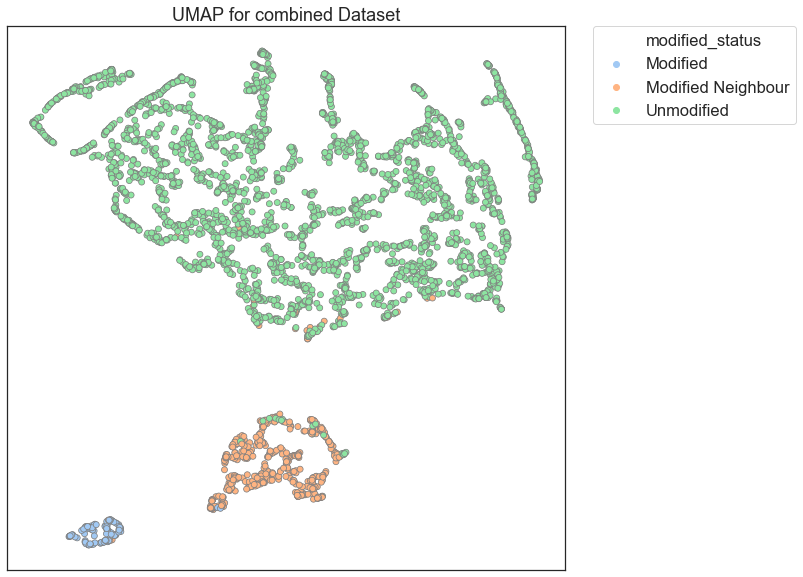

In [14]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_df, hue="modified_status", edgecolor="grey")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
plt.title("UMAP for combined Dataset")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([]);

# TSNE

In [15]:
from sklearn.manifold import TSNE

In [16]:
tsne = TSNE(random_state=7, perplexity = 50)
tsne_combined = tsne.fit_transform(preprocessor_combined_limited.fit_transform(df_combined))
df_combined_w_tsne = pd.concat([df_combined.modified,pd.Series(tsne_combined[:,0]).rename("tsne_d1"),
                  pd.Series(tsne_combined[:,1]).rename("tsne_d2")],axis=1, )

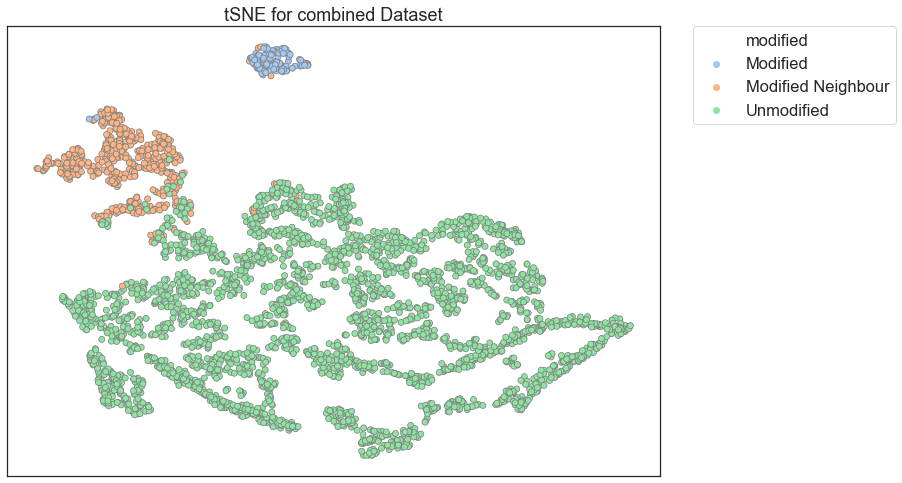

In [17]:
sns.scatterplot(data = df_combined_w_tsne, x = "tsne_d1", y = "tsne_d2", hue = "modified", edgecolor="grey")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
plt.title("tSNE for combined Dataset")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([]);
    

# dwell time rolling min to dwell time median

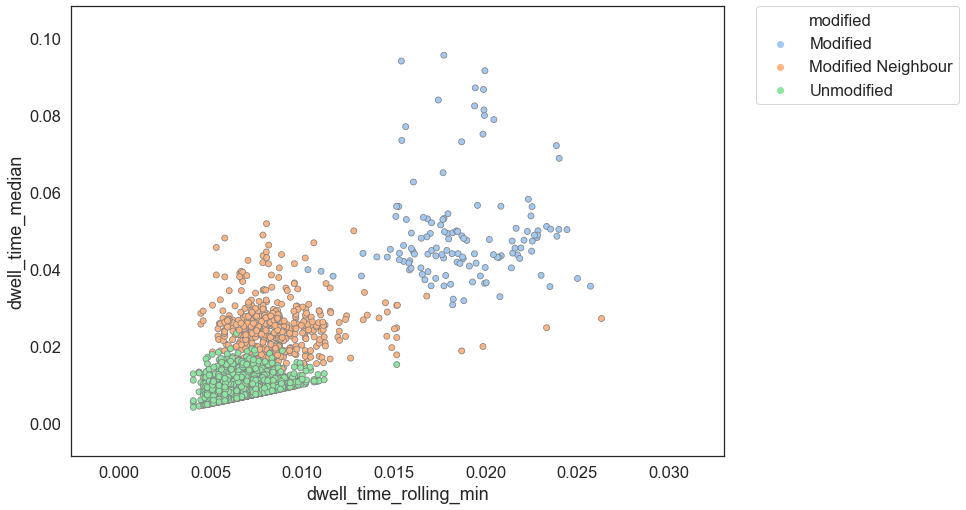

In [31]:
sns.scatterplot(data=df_combined, x="dwell_time_rolling_min", y="dwell_time_median", hue="modified", edgecolor="grey")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

# dwell time according to mod status

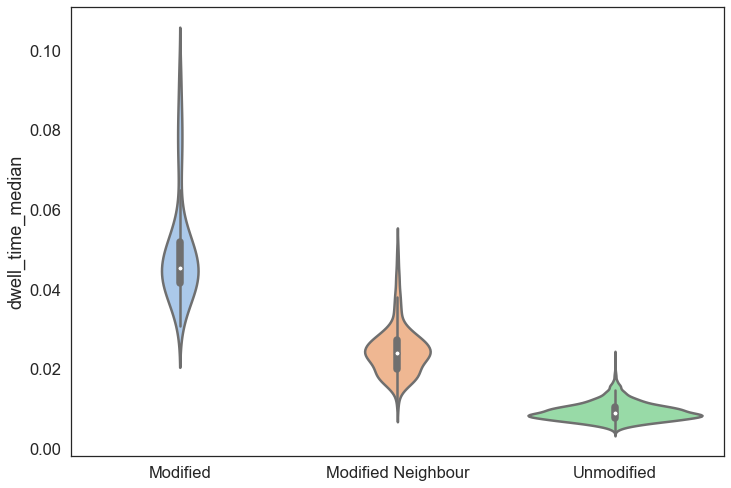

In [76]:
sns.violinplot(data=df_combined, y="dwell_time_median", x="modified")
plt.xlabel("");

# yeast data

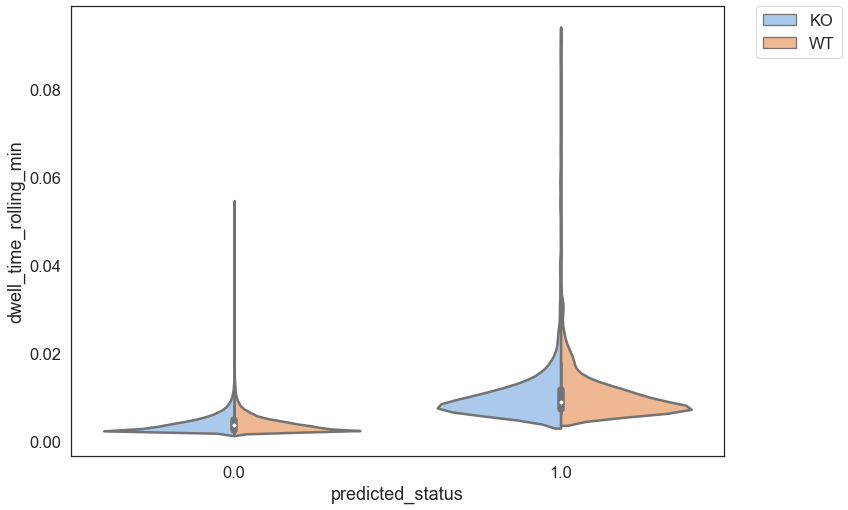

In [37]:
sns.violinplot(data=df_yeast_combined_predicted, x="predicted_status", y="dwell_time_rolling_min", hue="file_type", split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

## umap

In [74]:
df_yeast_combined_predicted.predicted_status.value_counts()

0.0    569990
1.0      2213
Name: predicted_status, dtype: int64

In [71]:
fnord = df_yeast_combined_predicted.sample(50000)

In [72]:
embedding = umap.fit_transform(preprocessor_combined_limited.fit_transform(fnord))

umap_yeast_df = pd.DataFrame(embedding)
umap_yeast_df["modified"] = fnord.predicted_status.astype("category")
umap_yeast_df.columns = ["umap_dim_1","umap_dim_2","modified_status"]

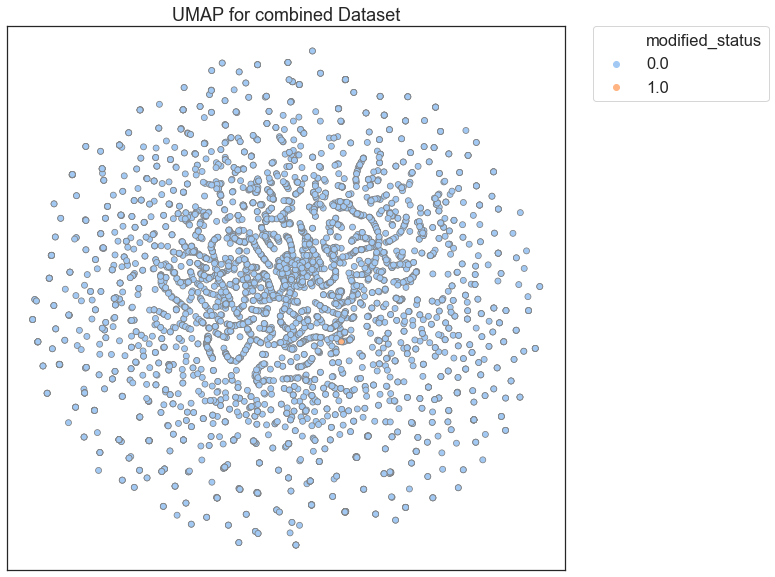

In [73]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_yeast_df, hue="modified_status", edgecolor="grey")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
plt.title("UMAP for combined Dataset")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([]);

In [52]:
# interactive plot for numeric features to see if base identity is correlated to values

@interact(base = ["base_1","base_2","base_3","base_4","base_5"], 
          y_axis = list(df_not_combined.columns[df_not_combined.dtypes ==  "float"]))
def test_plot(base, y_axis):
    sns.boxplot(data = df_not_combined, y = y_axis,x="modified_status", hue=base, hue_order=["A","G","C","T"])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True);

interactive(children=(Dropdown(description='base', options=('base_1', 'base_2', 'base_3', 'base_4', 'base_5'),…

# dna features

In [220]:
df_dnaviewer = df_combined[["ref_number","file_name","base_3","dwell_time_median","dwell_time_rolling_min",
                            "dwell_time_diff_to_median","modified_status"]]

In [365]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    if seriesObj.any():
        columnNames = list(seriesObj[seriesObj == True].index)
        # Iterate over list of columns and fetch the rows indexes where value exists
        for col in columnNames:
            rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row))
        # Return a list of tuples indicating the positions of value in the dataframe
    else:
        listOfPos = False
    return listOfPos

In [ ]:
from dna_features_viewer import GraphicFeature, GraphicRecord

In [375]:
import imageio

In [485]:
def sequencing_plot(i):
    font =  {'size': 16, 
             'weight':'bold'}
    
    start_i = i
    stop_i =i+15
    
    start,stop = 0,15
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(
        4, 1,  figsize=(12, 10), sharex=True, gridspec_kw={"height_ratios": [1,1,1,1]}
    )
    df_temp = df_dnaviewer[(df_dnaviewer["file_name"]=="modified_rep_1.tsv") &
                (df_dnaviewer["ref_number"]=="ref_0000")][start_i:stop_i].reset_index()
    sequence = "".join(df_temp.base_3.values)

    modified_positions = getIndexes(df_temp[["base_3","modified_status"]], 1.0)
    #print(modified_positions)

    features = [
        GraphicFeature(
        start = 5, end = 10, color="#adebad", label = "read frame", linewidth= 2.5),
        GraphicFeature(
        start = 7, end = 8, color = "#663300", label = "center", box_color=None,
            linewidth= 2.5, box_linewidth = 0,label_link_color=None,fontdict=font)
    ]

    
        
    record = GraphicRecord(sequence=sequence, features=features,
                          ticks_resolution = 1)
    record.plot(ax=ax1, figure_width=8)
    #record.plot_sequence(ax=ax1, guides_intensity = 1, y_offset=3, fontdict=font)
    ax1.set_xticklabels(list(sequence))
    if modified_positions:
        for elm in modified_positions:

            ax1.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2)
            ax2.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2)
            ax3.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2)
            ax4.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2)
    ax2.bar(x=range(0,stop-start),height=df_temp.dwell_time_median, edgecolor="grey")
    ax2.set_ylabel("Dwell Time\nMedian")
    ax2.set_ylim(0,0.08)
    ax3.bar(x=range(0,stop-start),height=df_temp.dwell_time_rolling_min, edgecolor="grey")
    ax3.set_ylabel("Dwell Time\nRolling Minimum")
    ax3.set_ylim(0,0.03)
    ax4.bar(x=range(0,stop-start),height=df_temp.dwell_time_diff_to_median, edgecolor="grey")
    ax4.set_ylabel("Dwell Time\nDiff to Median")
    ax4.set_ylim(0,0.08)
    ax1.set_xticklabels(list(sequence), fontdict={"weight":"bold"} )
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.show()
    plt.close()
    #plt.savefig("gif/frame_"+str(i))
    #plt.show();

    return image
    

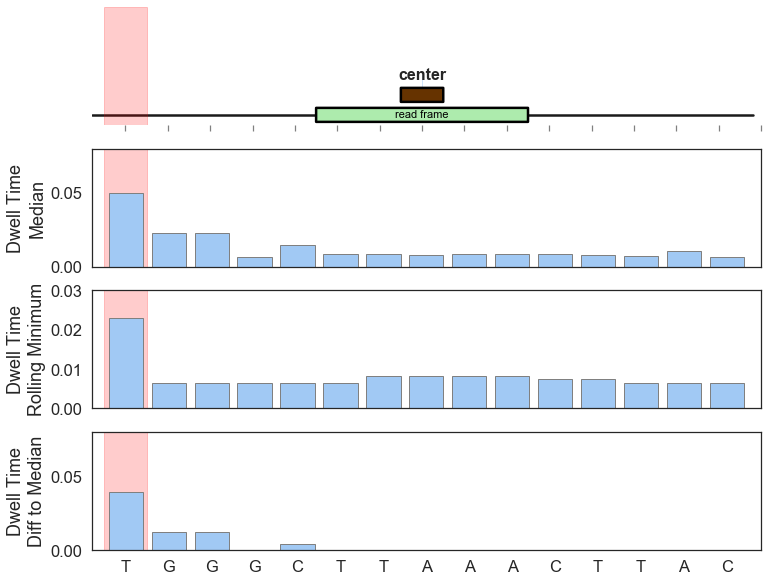

In [486]:
a = sequencing_plot(0)

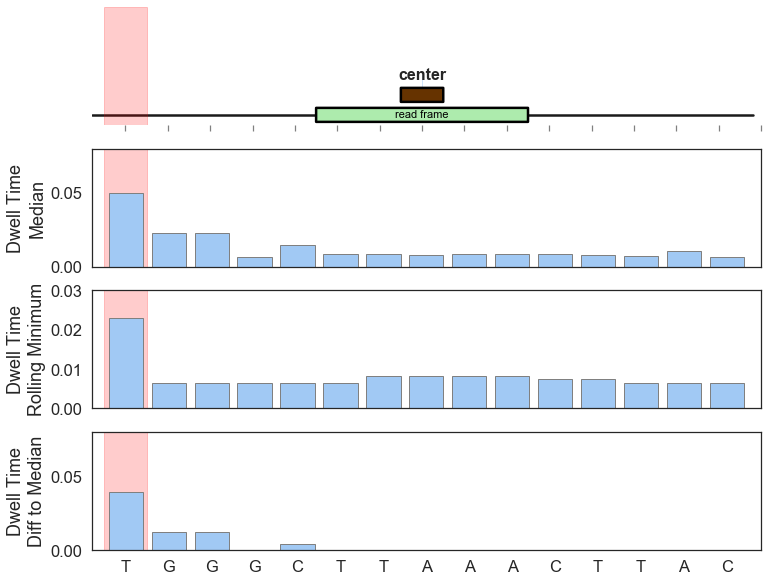

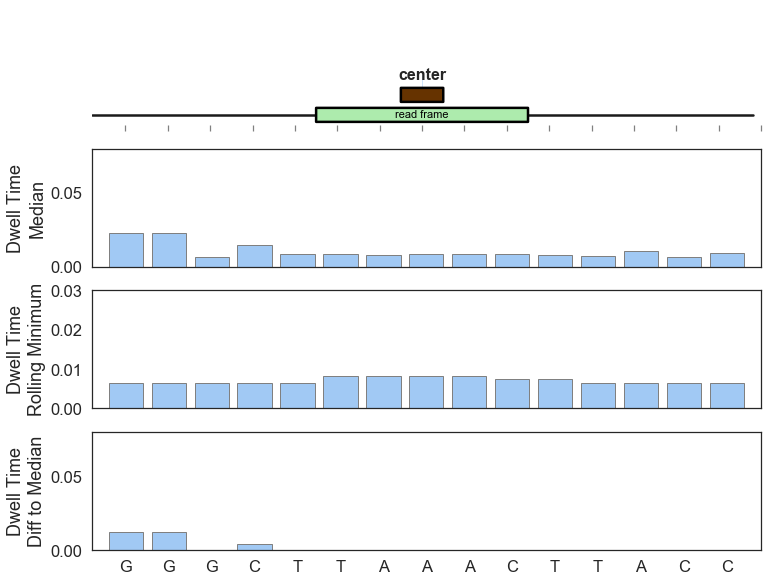

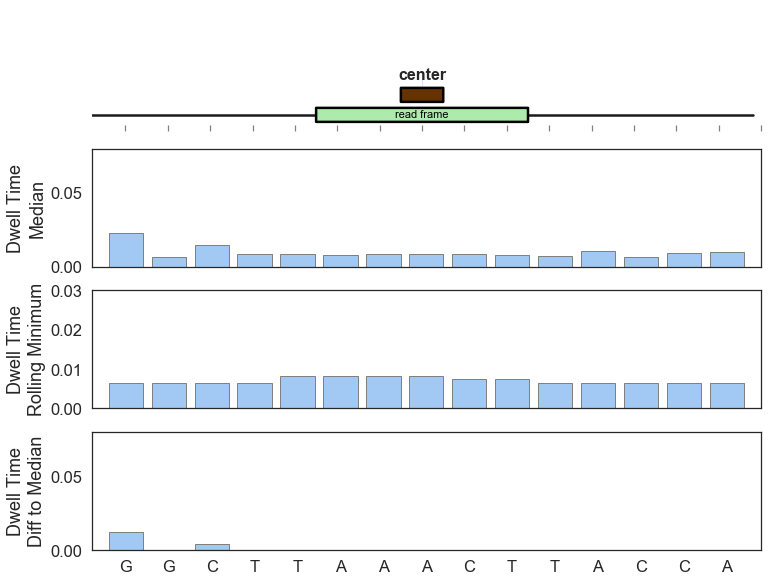

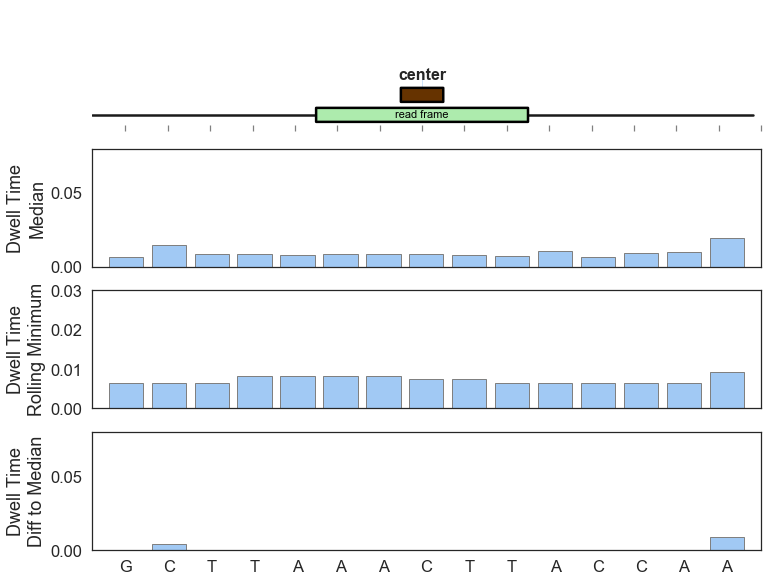

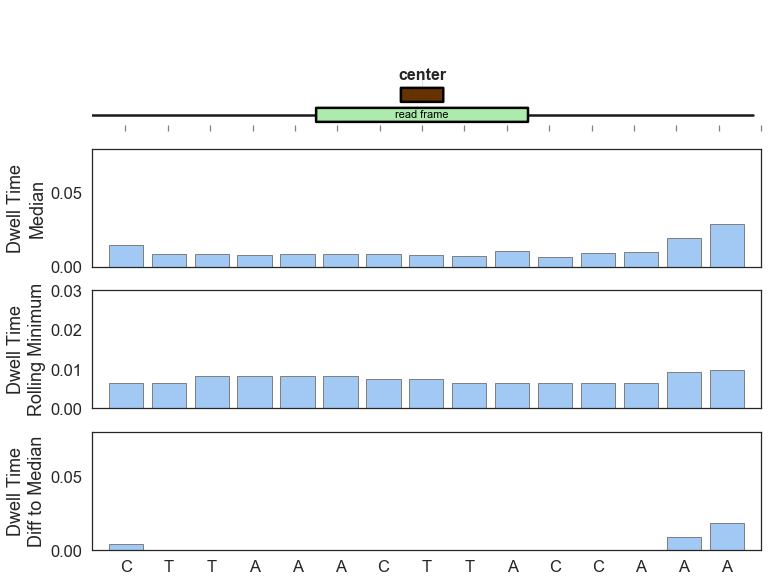

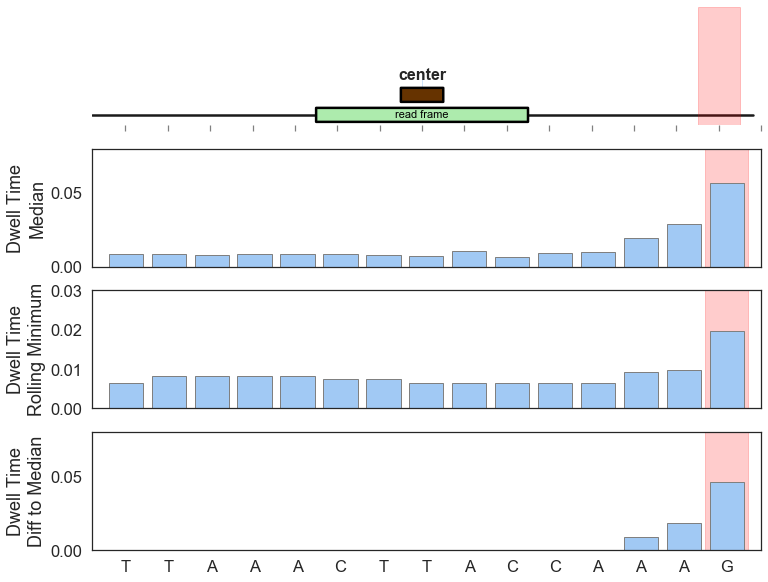

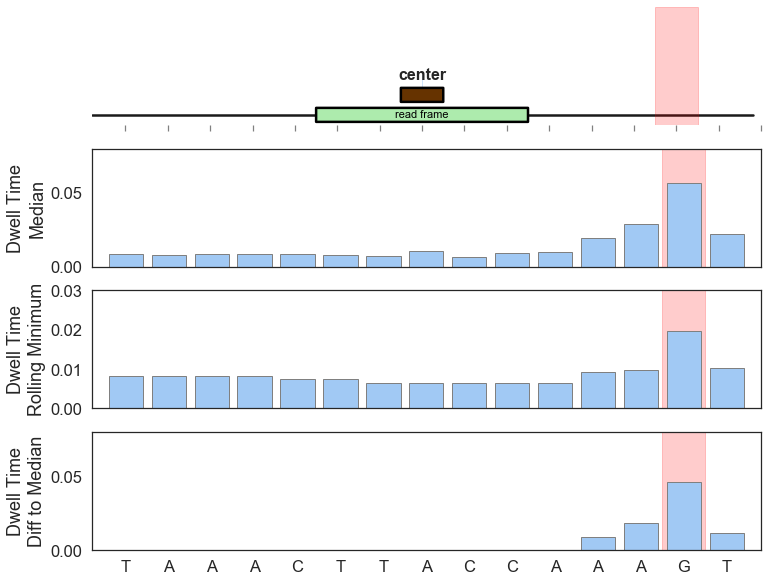

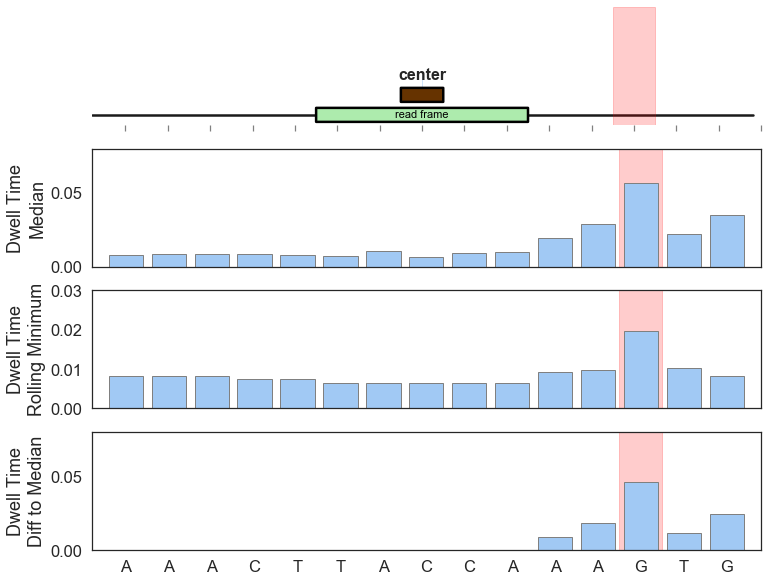

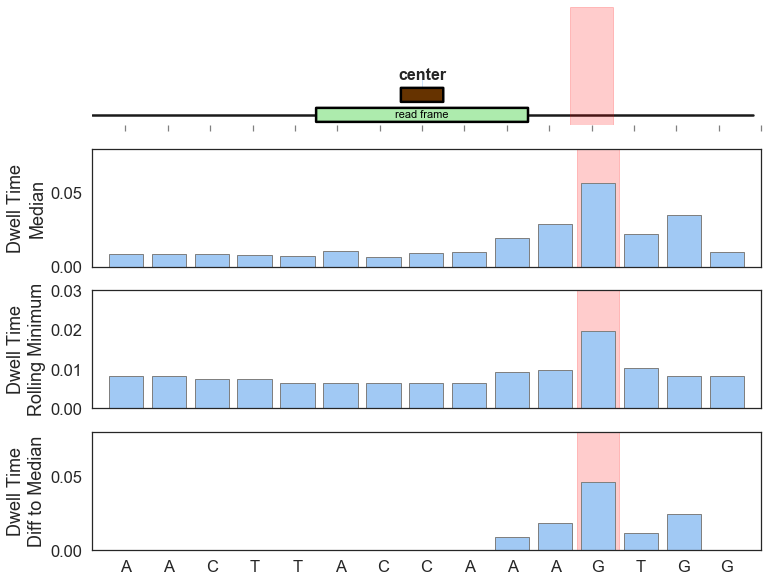

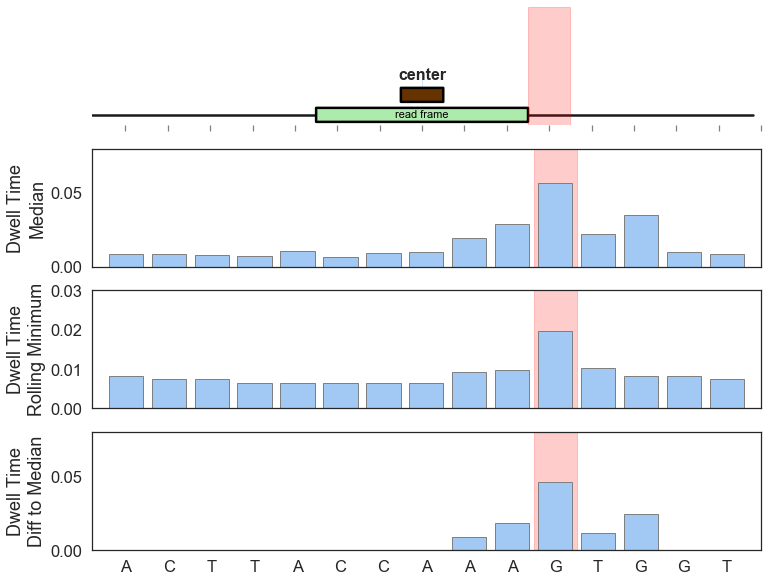

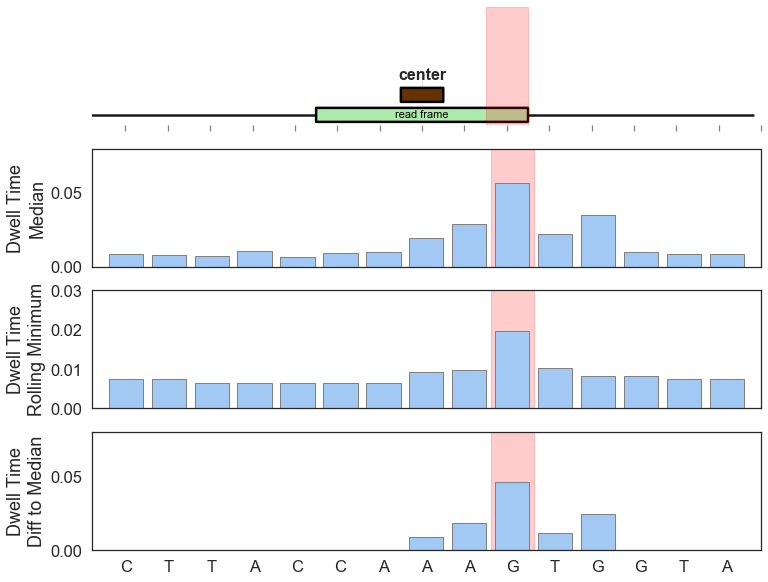

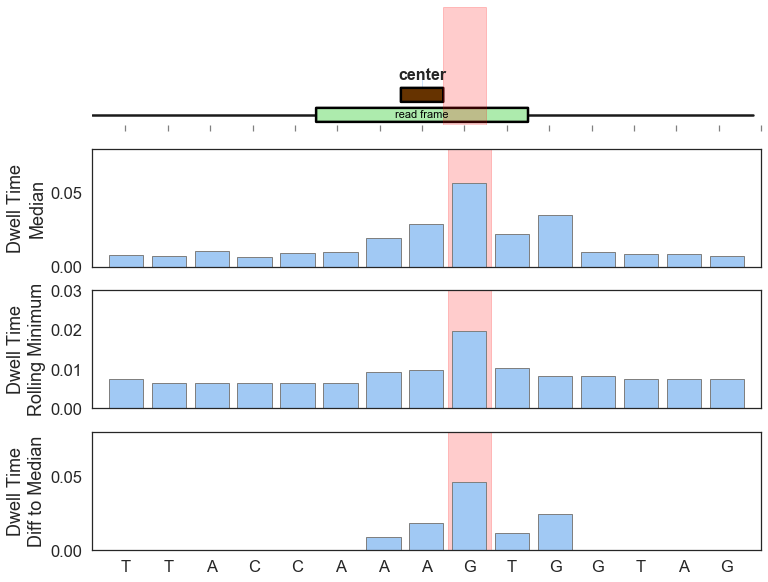

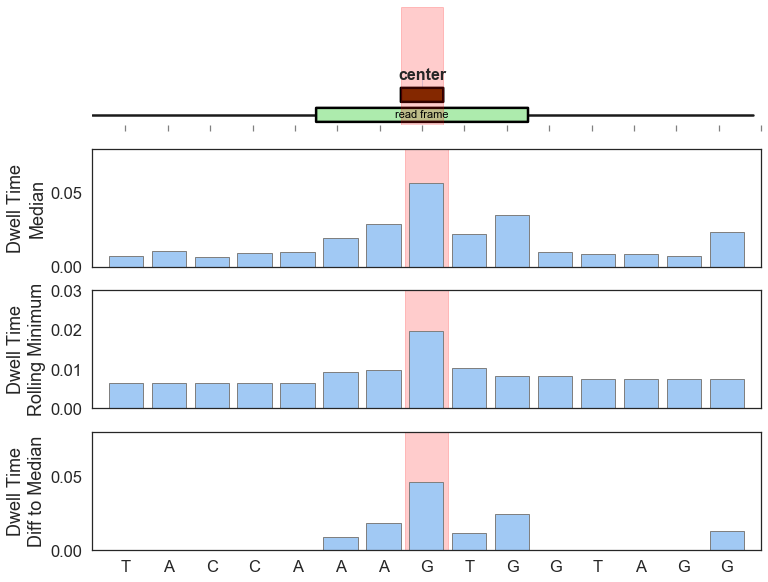

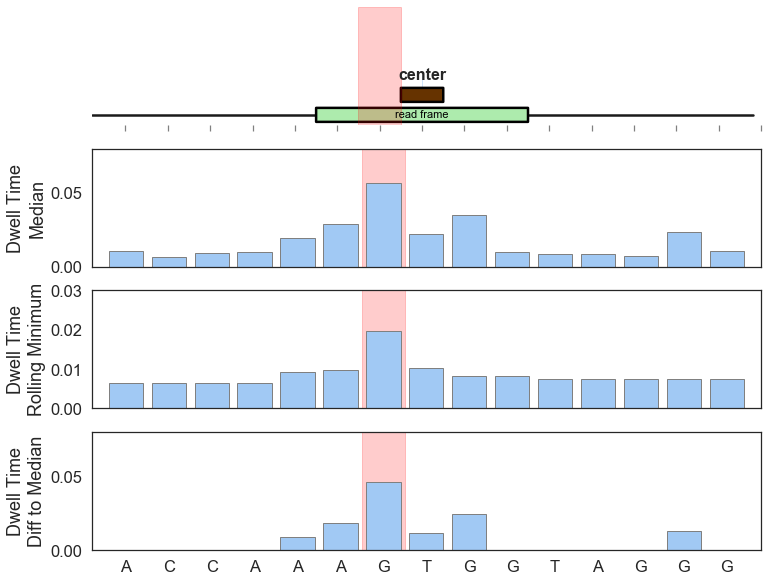

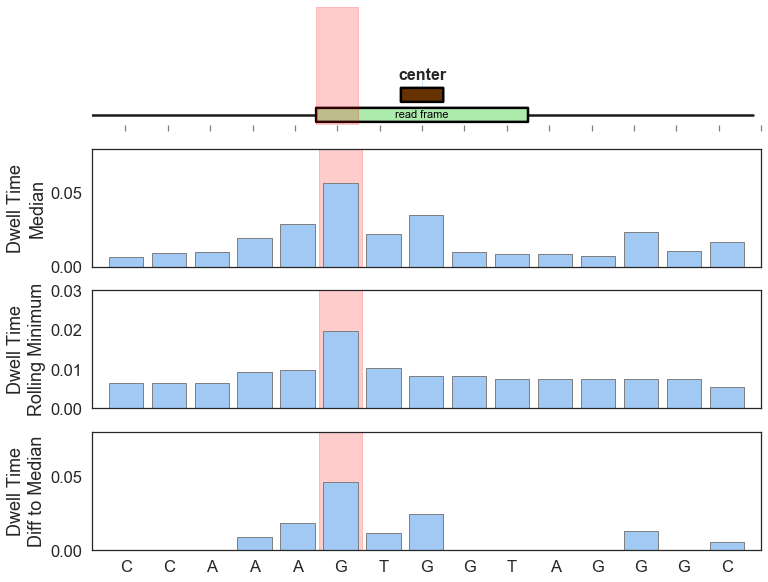

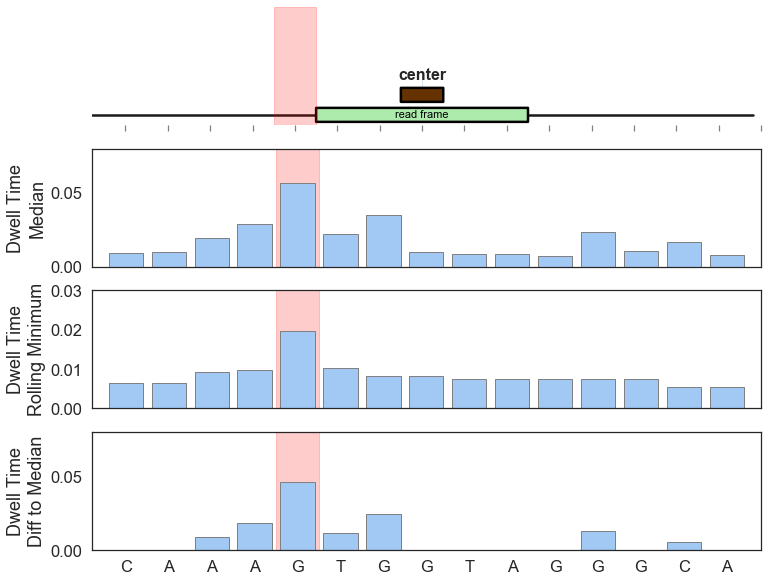

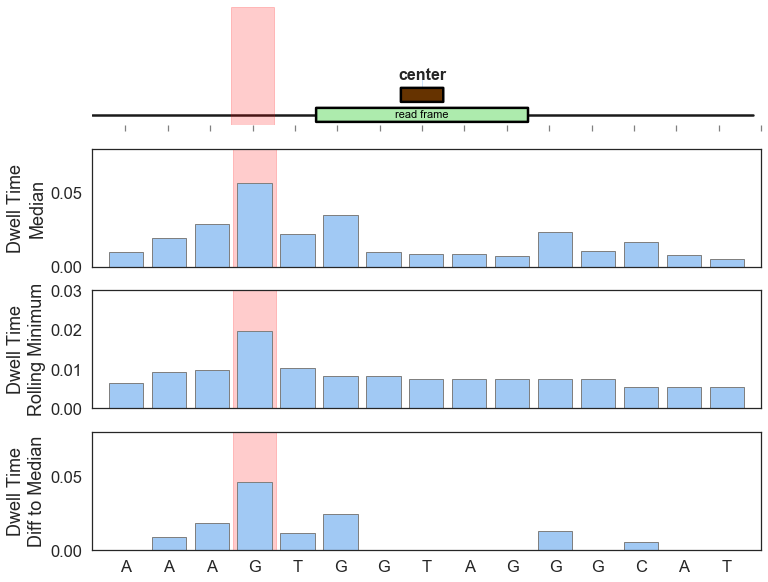

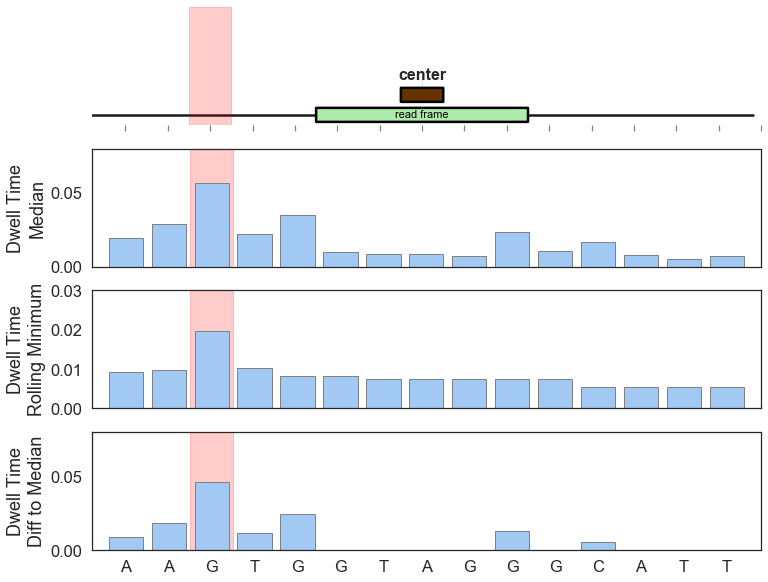

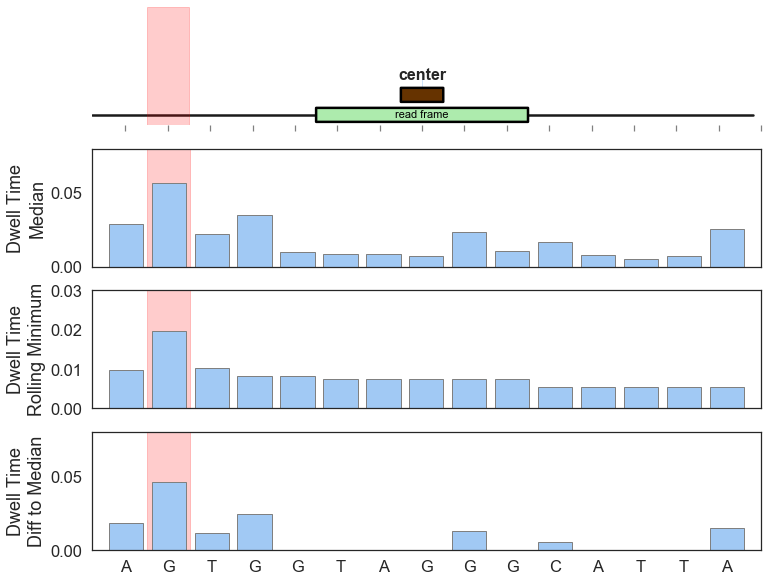

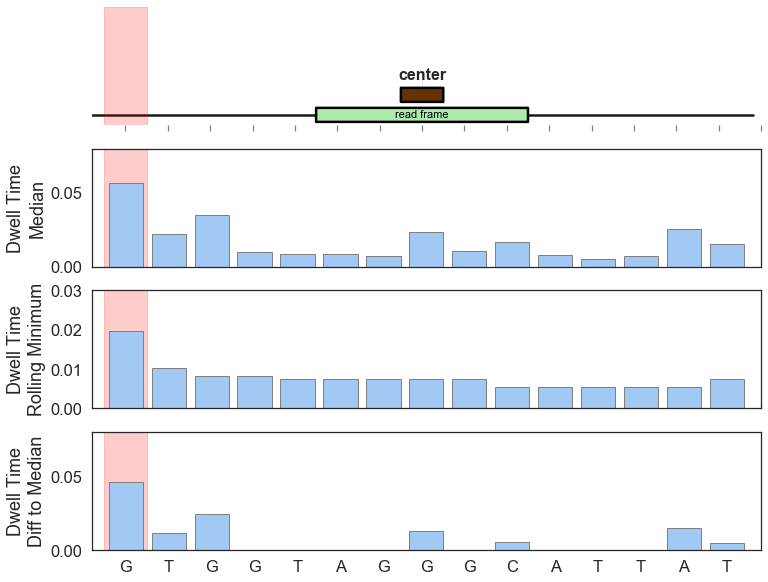

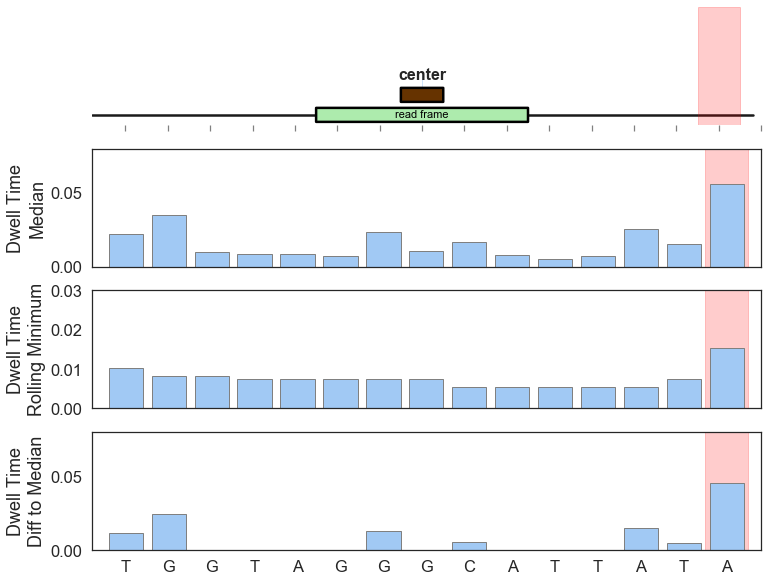

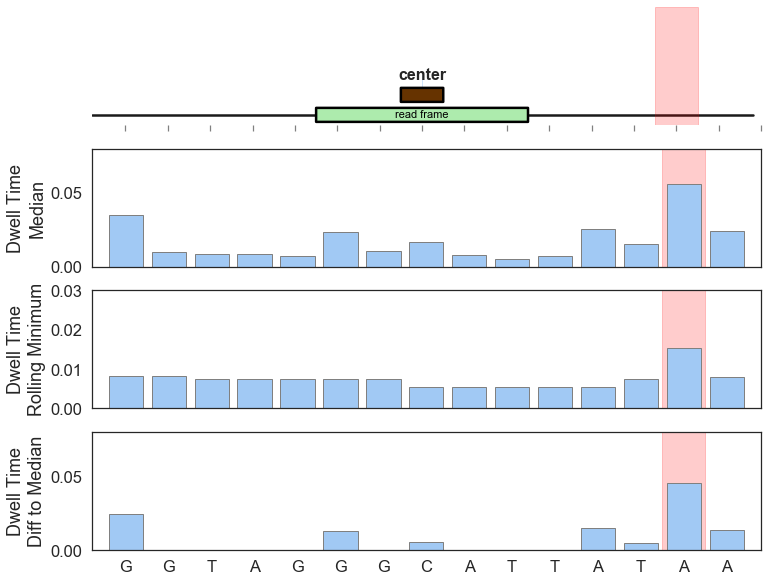

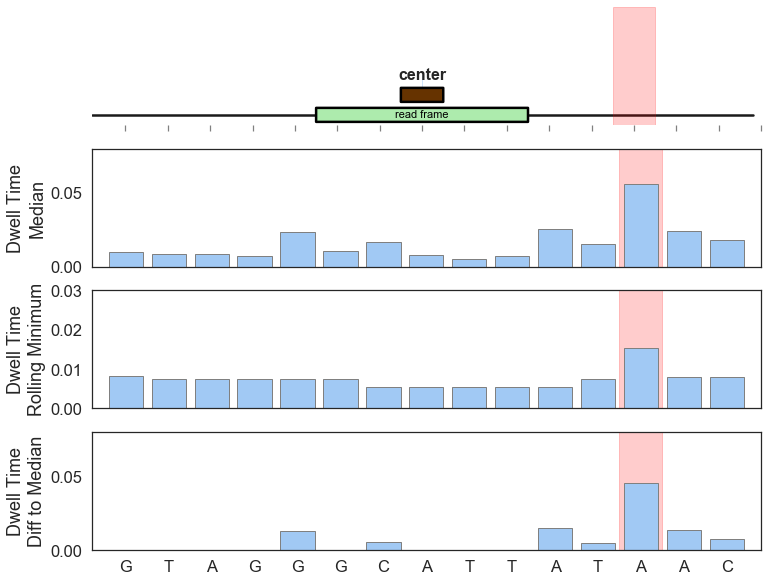

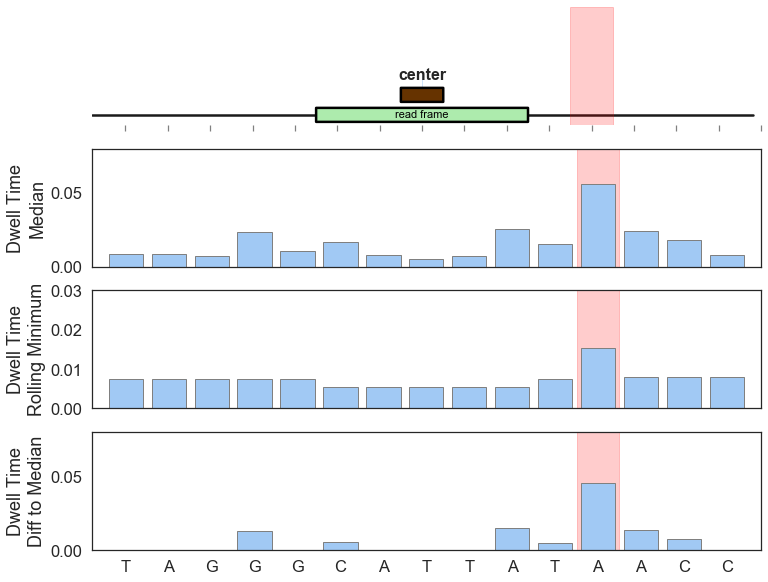

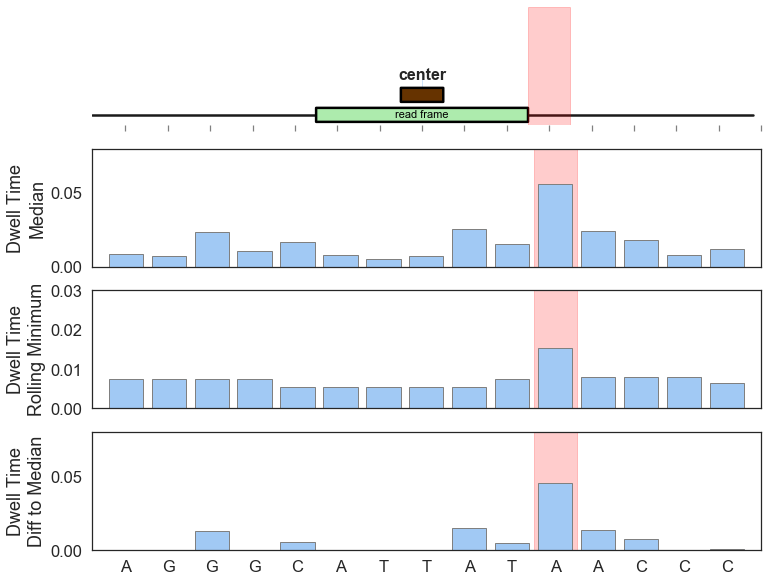

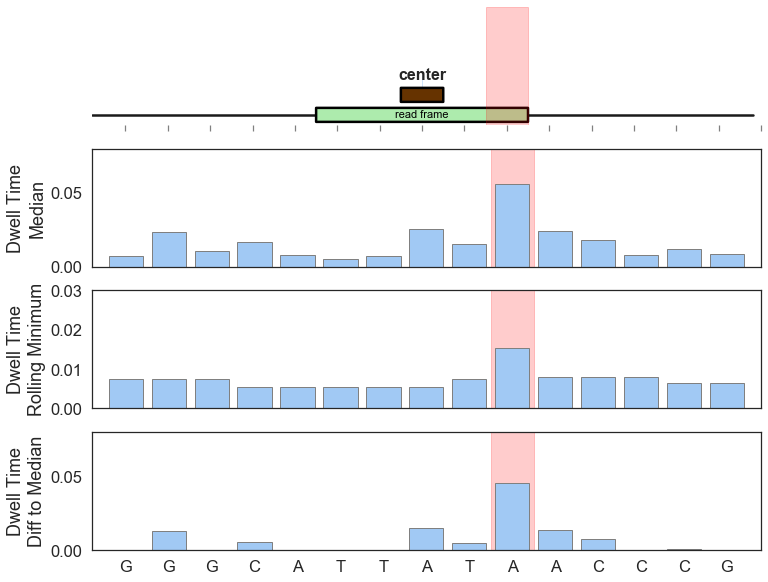

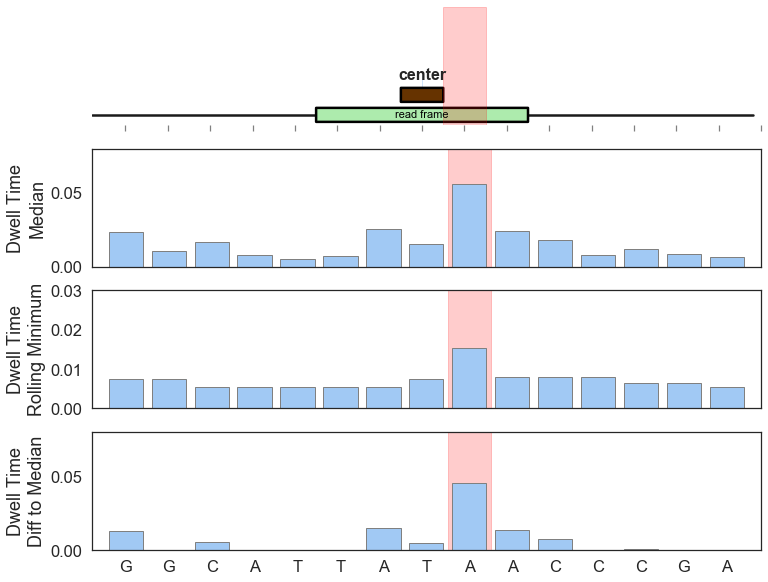

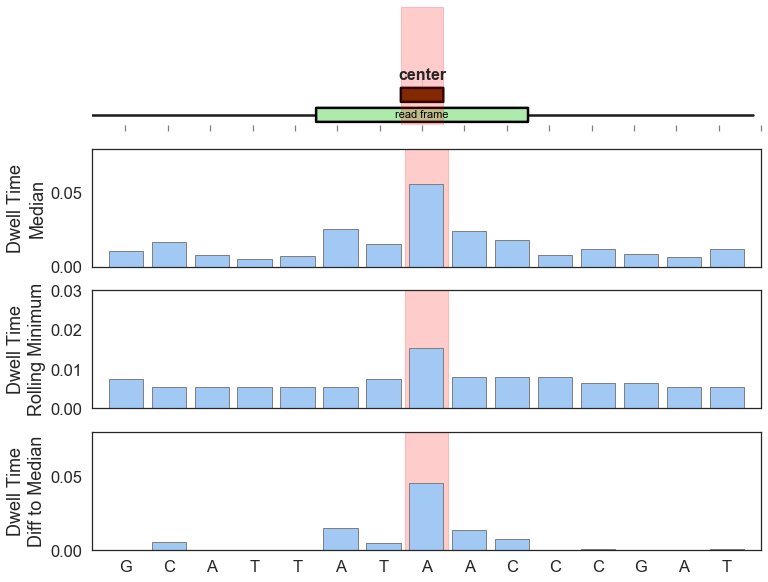

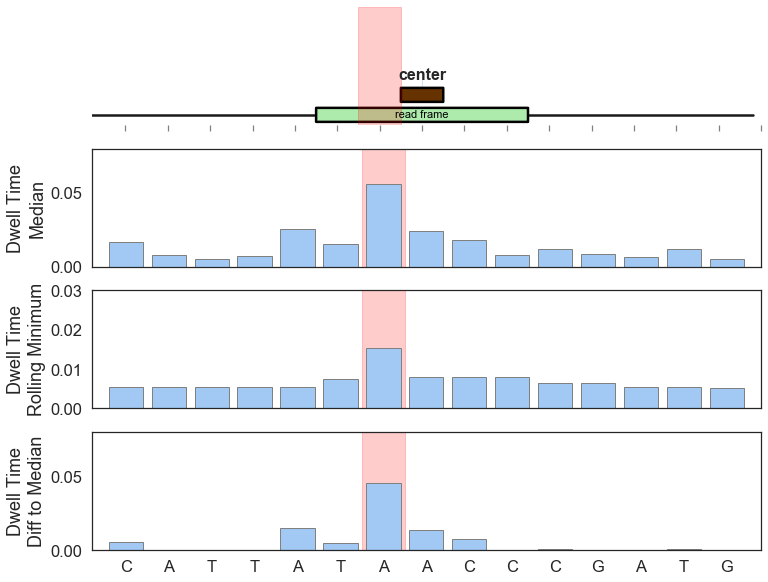

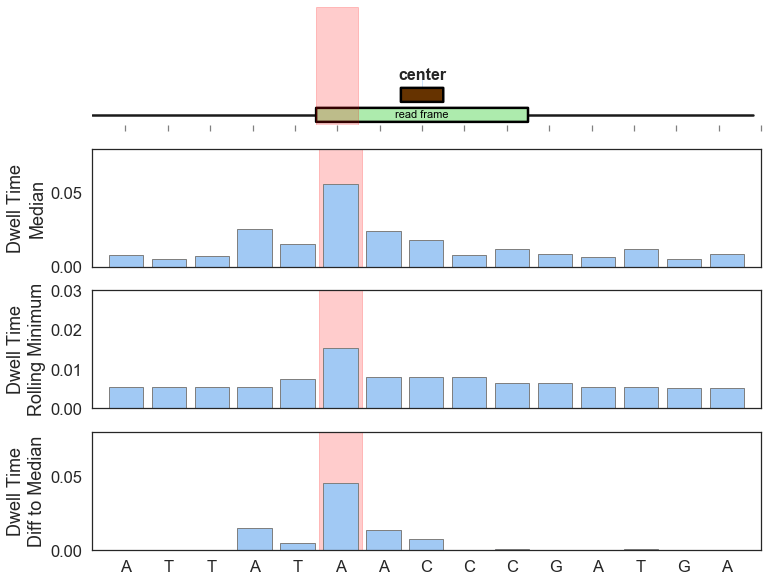

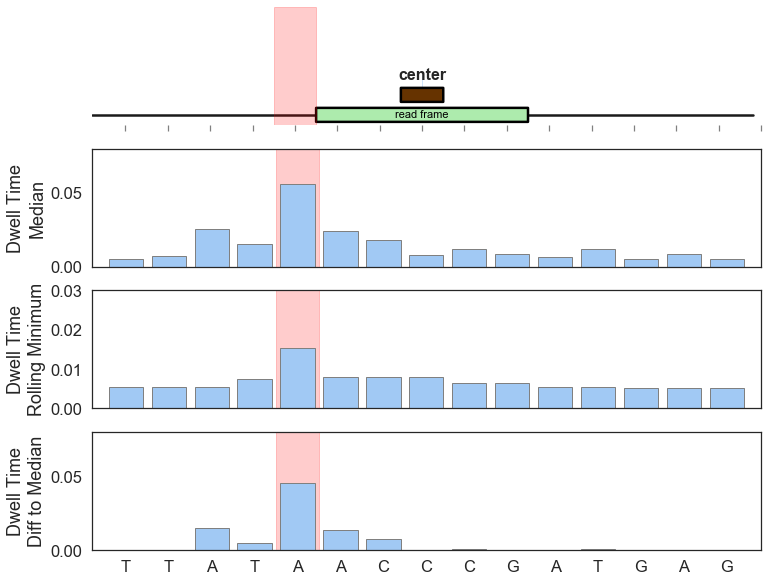

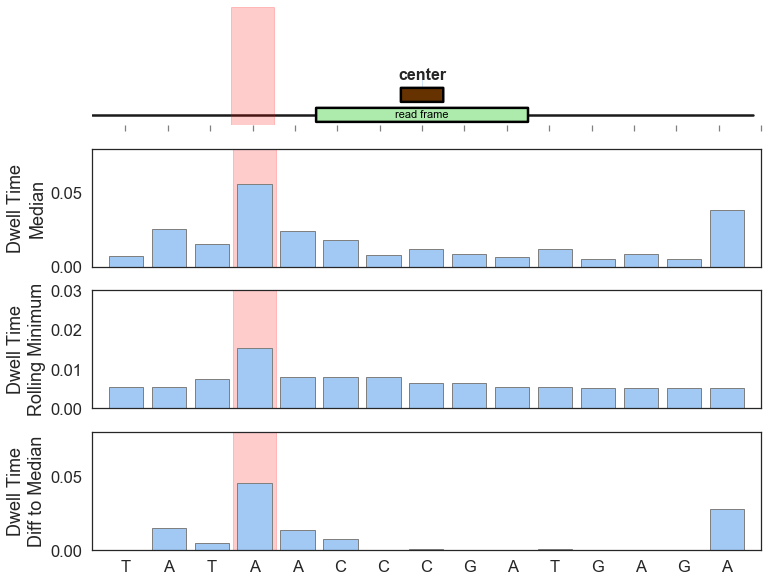

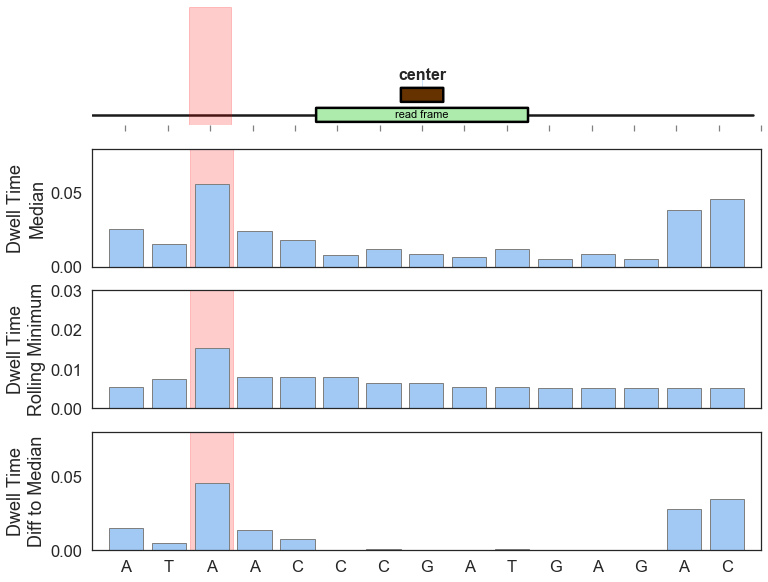

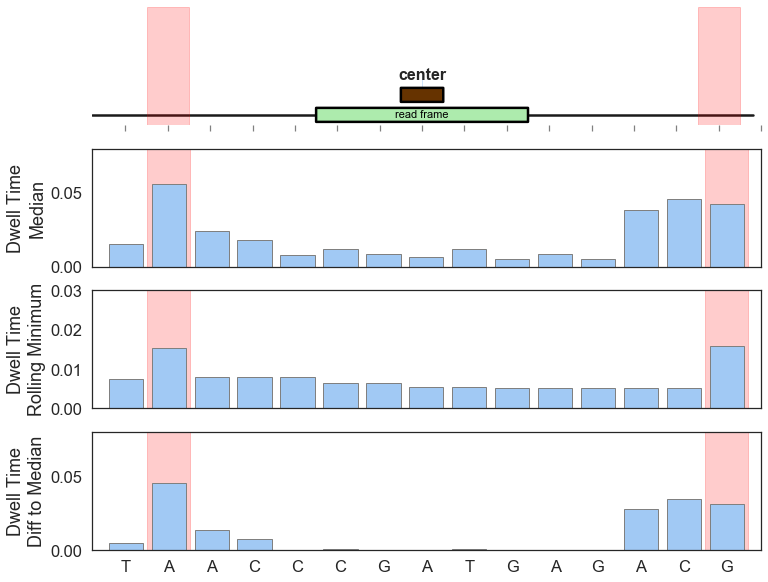

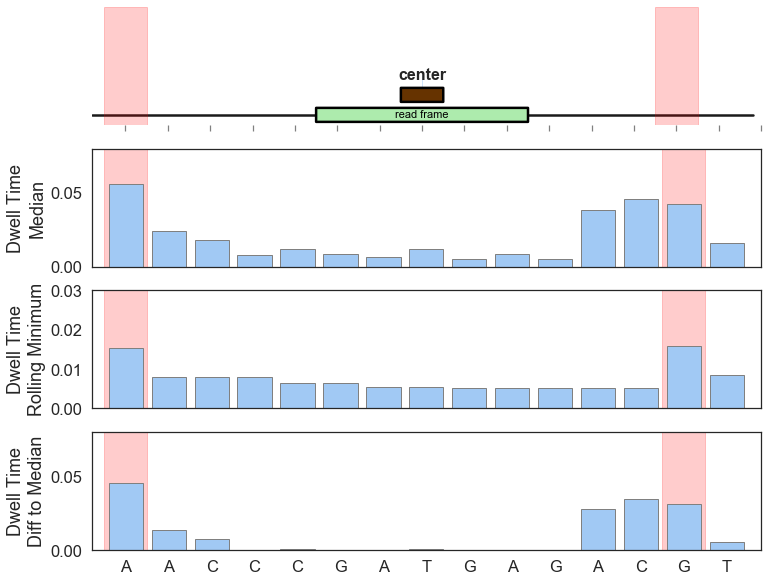

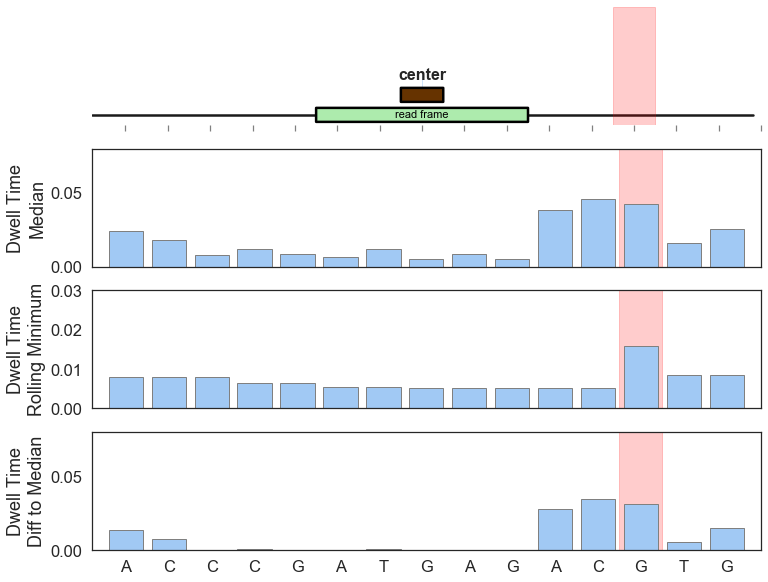

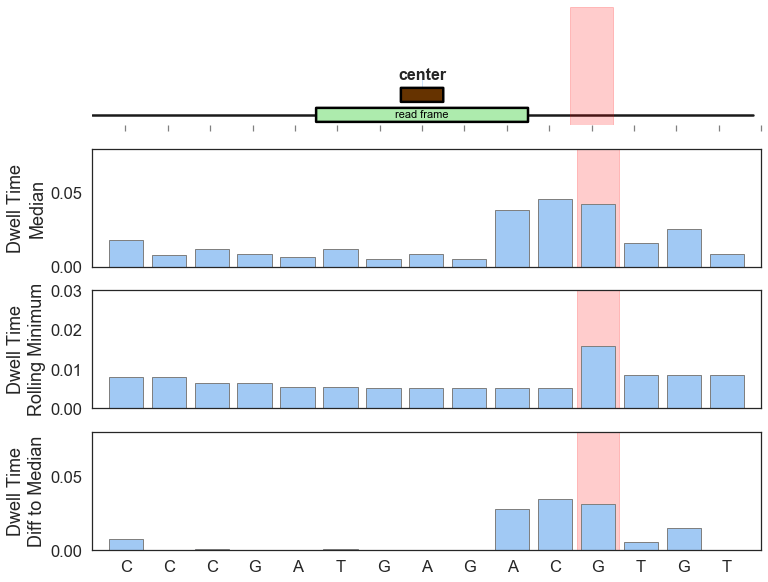

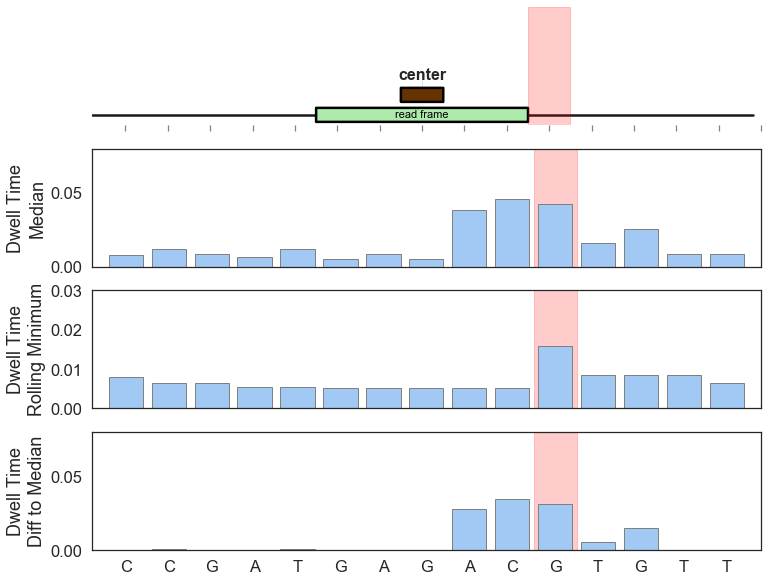

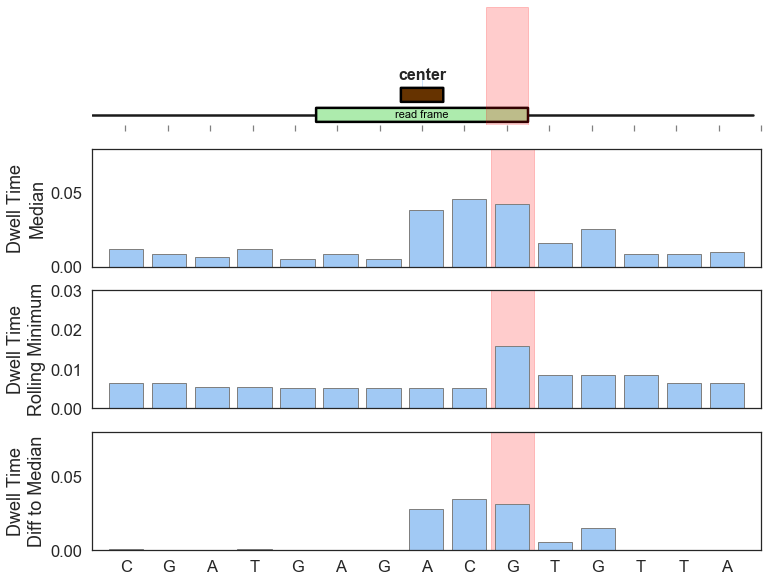

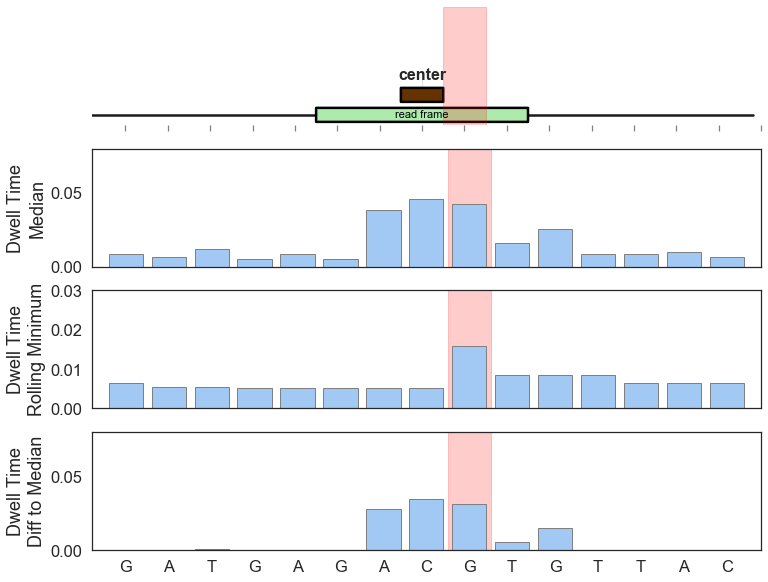

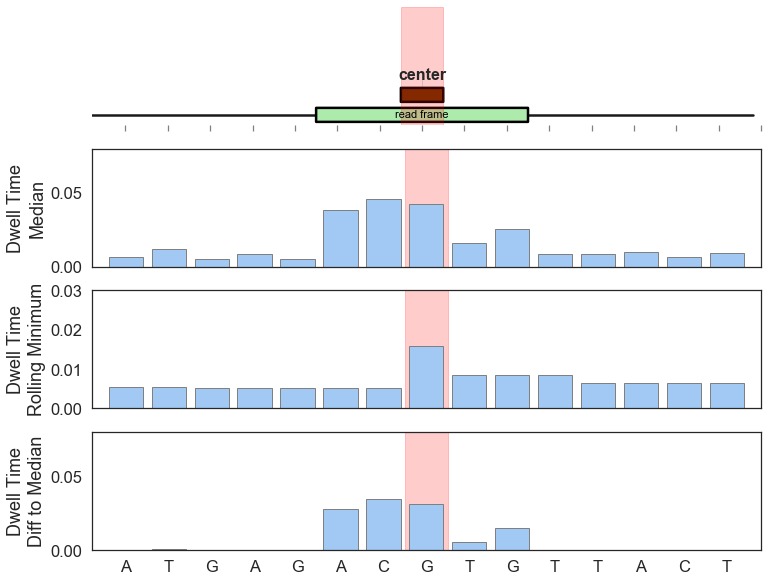

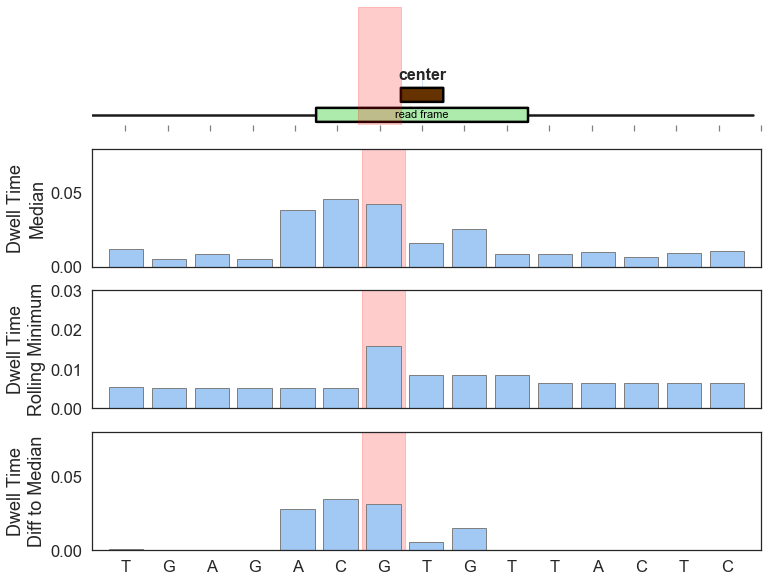

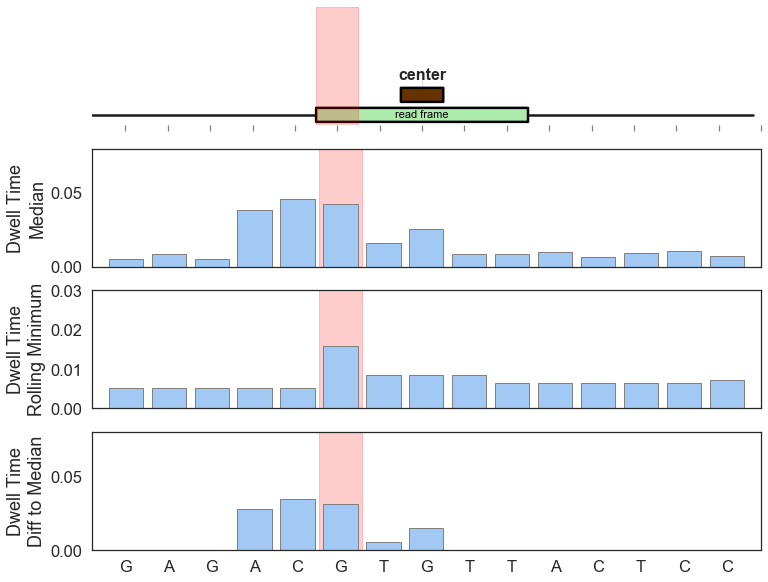

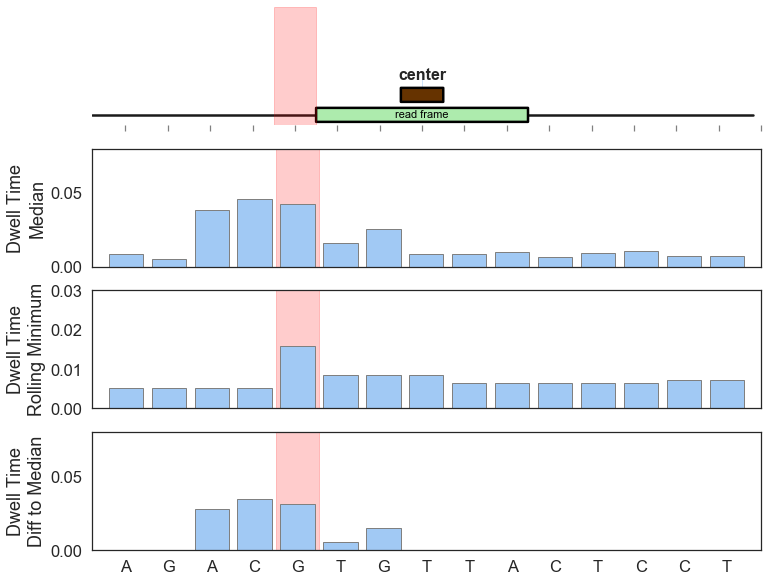

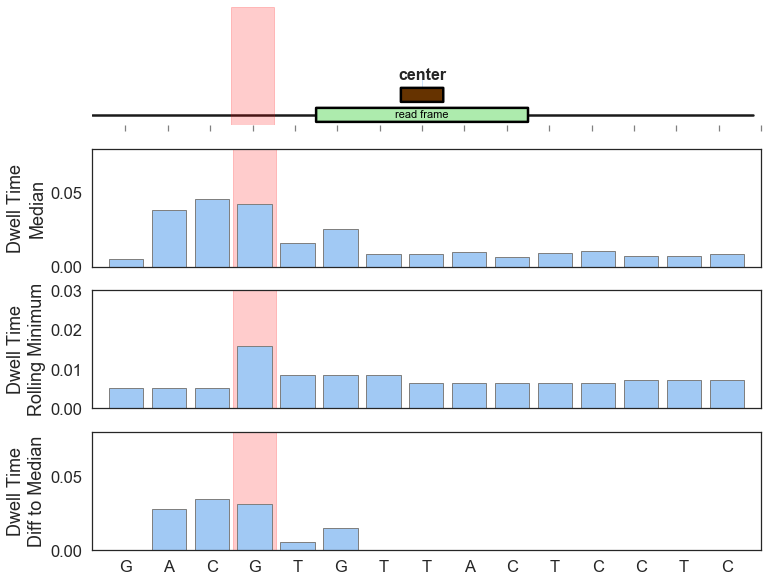

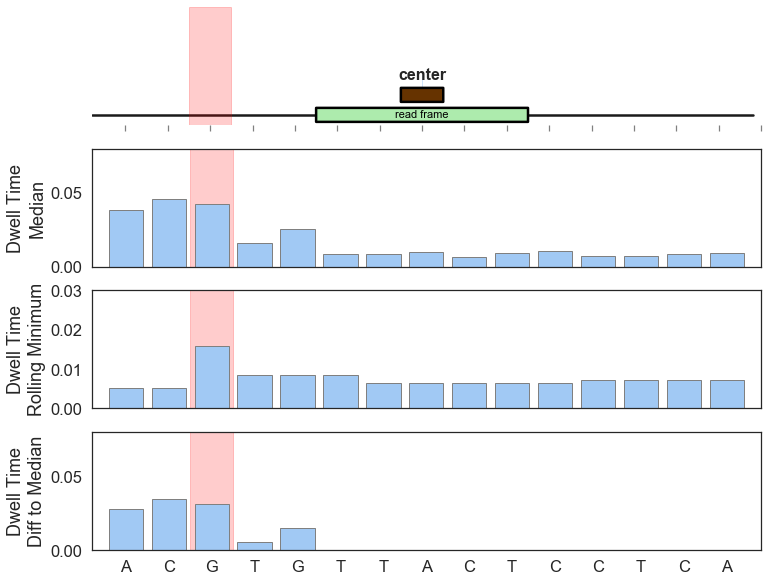

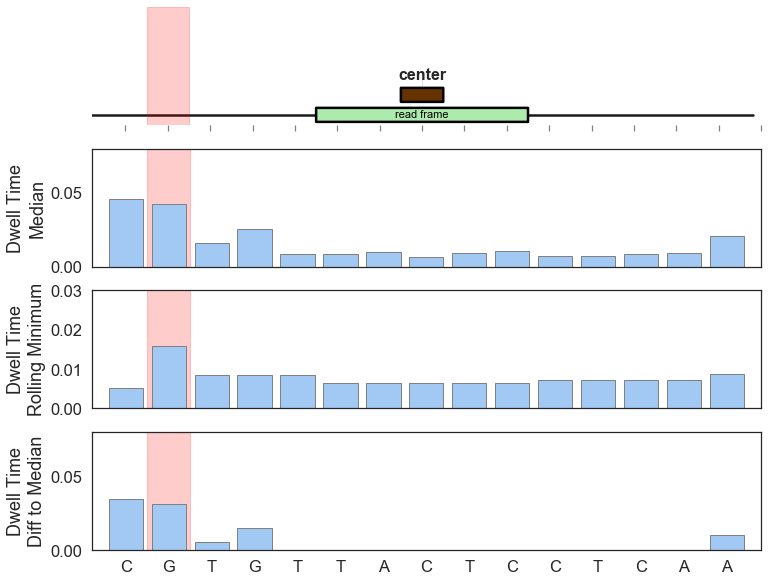

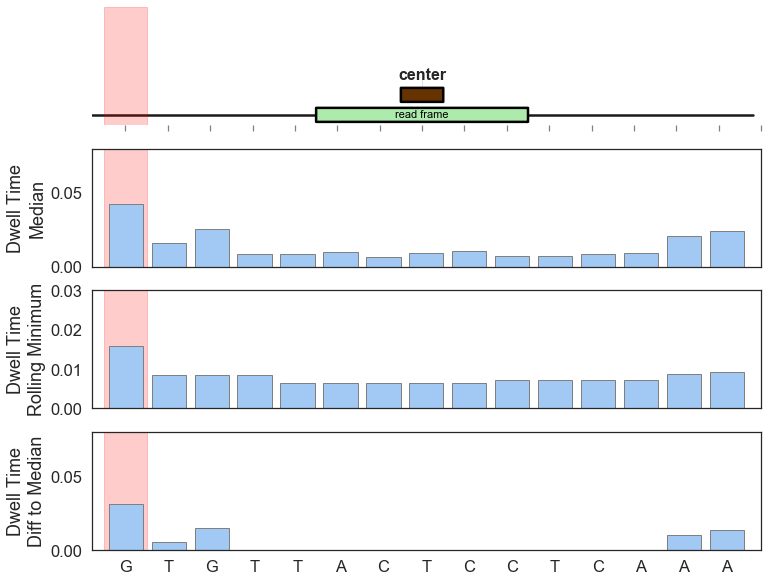

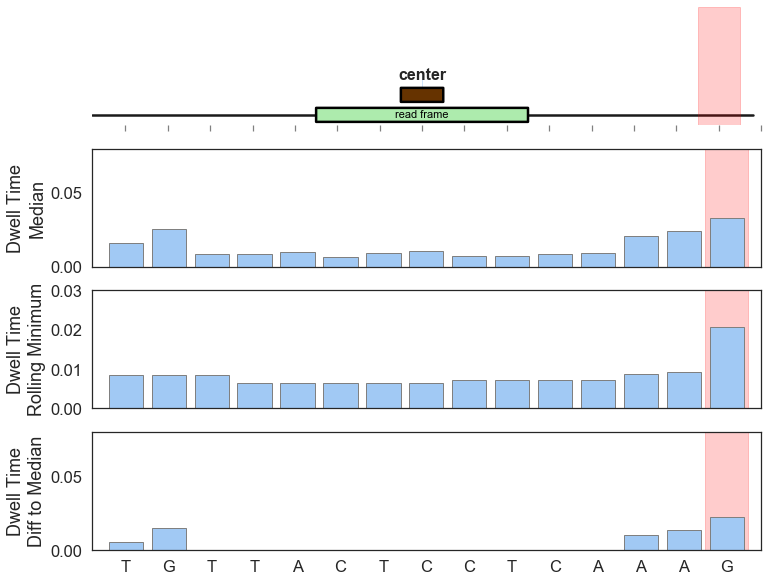

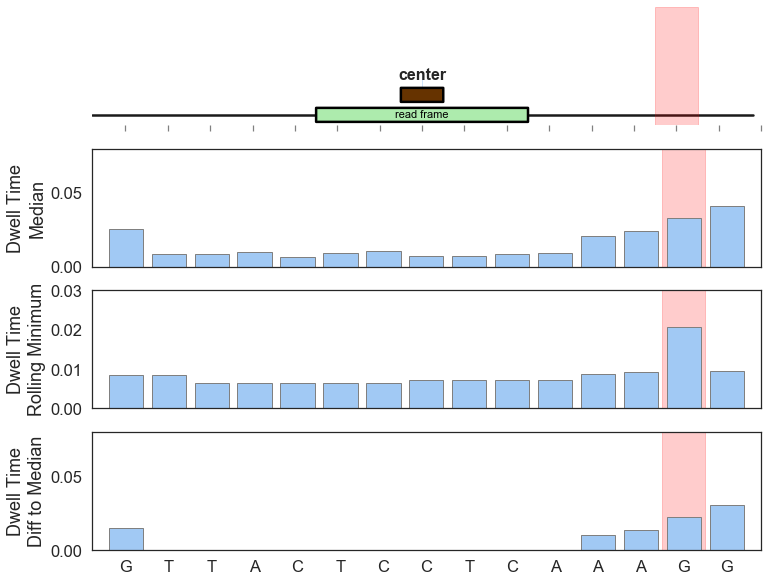

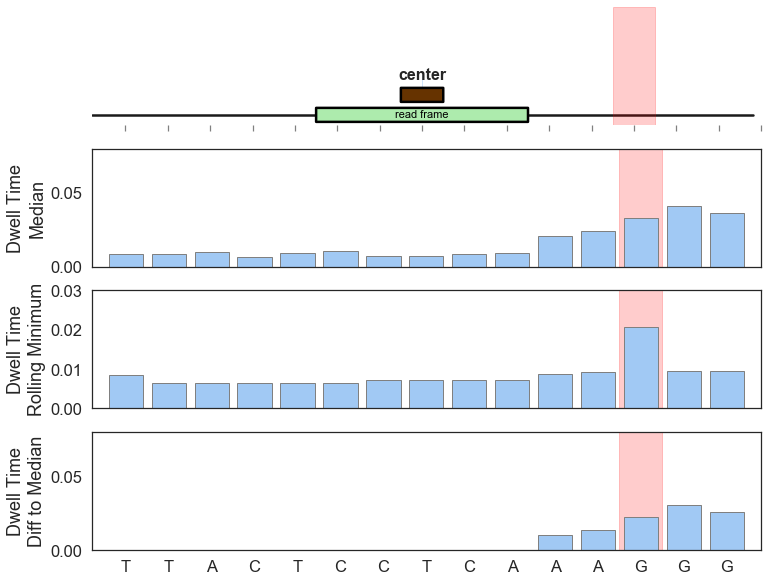

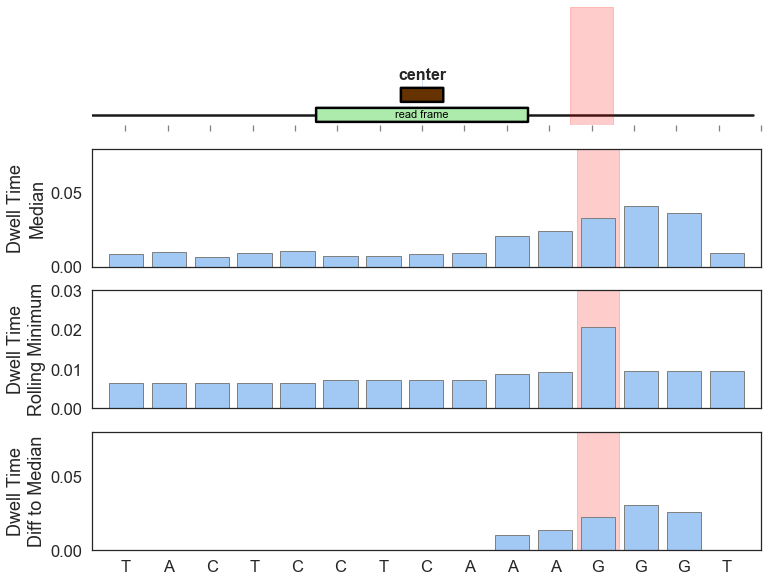

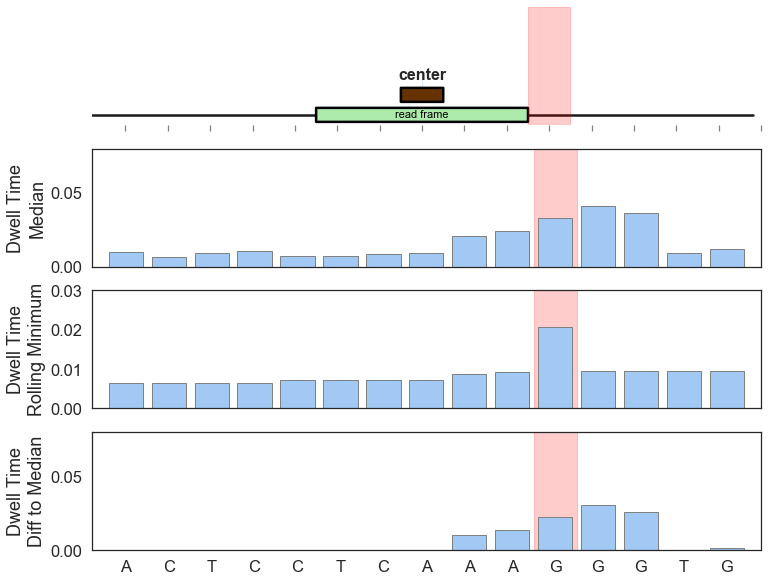

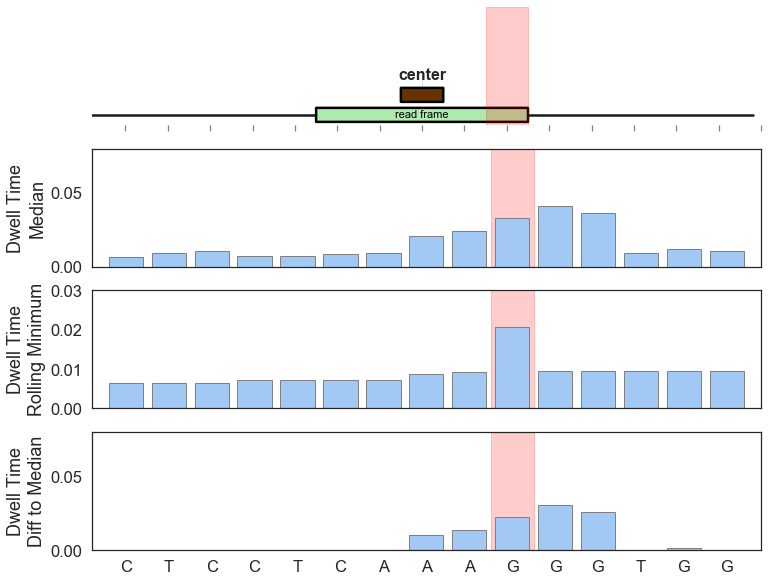

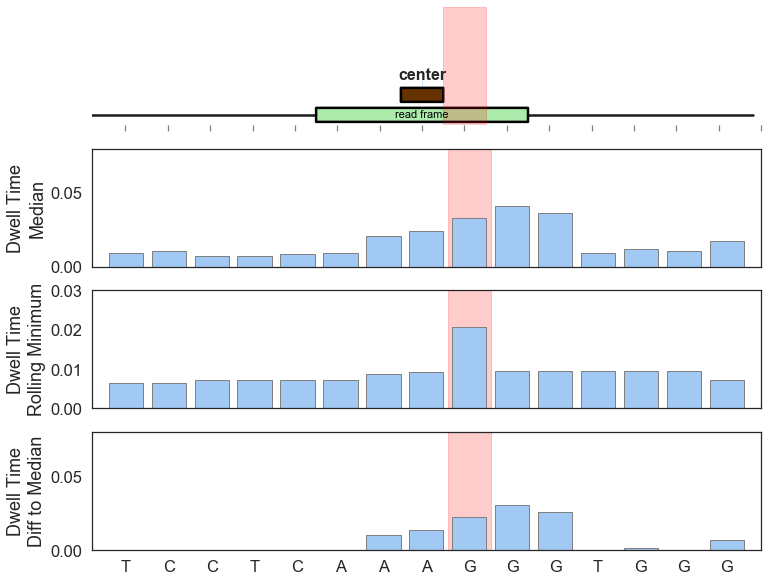

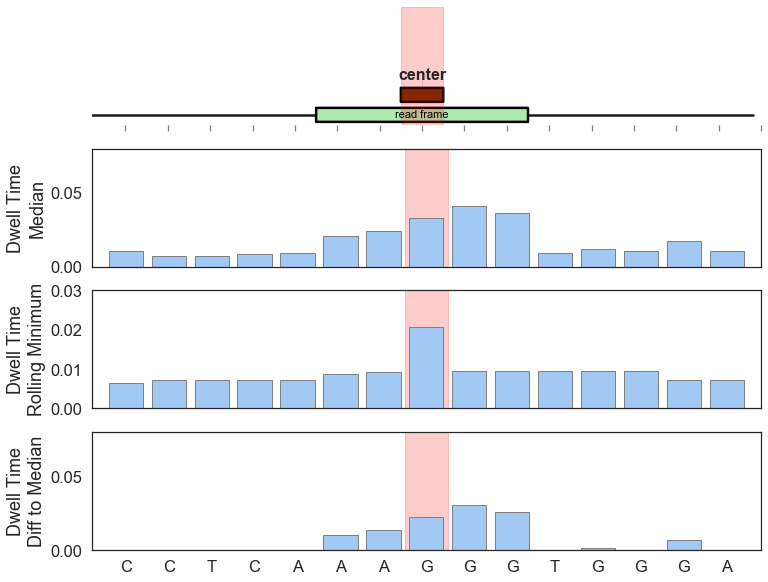

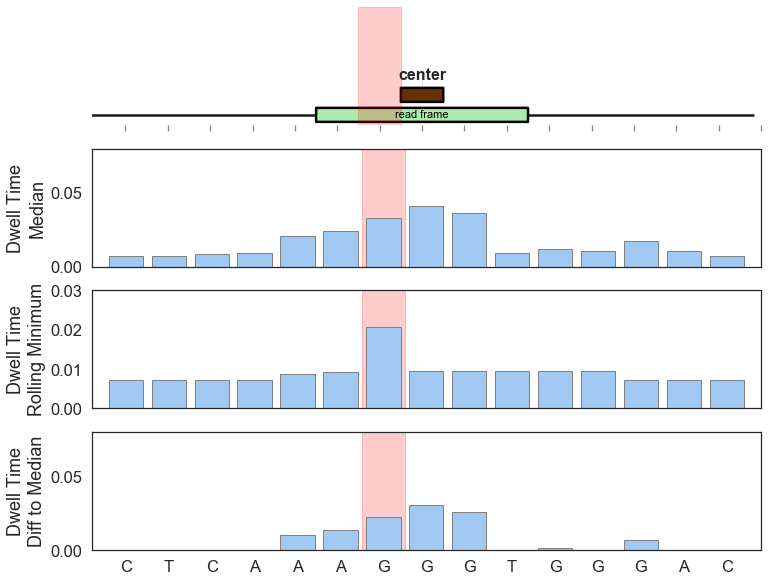

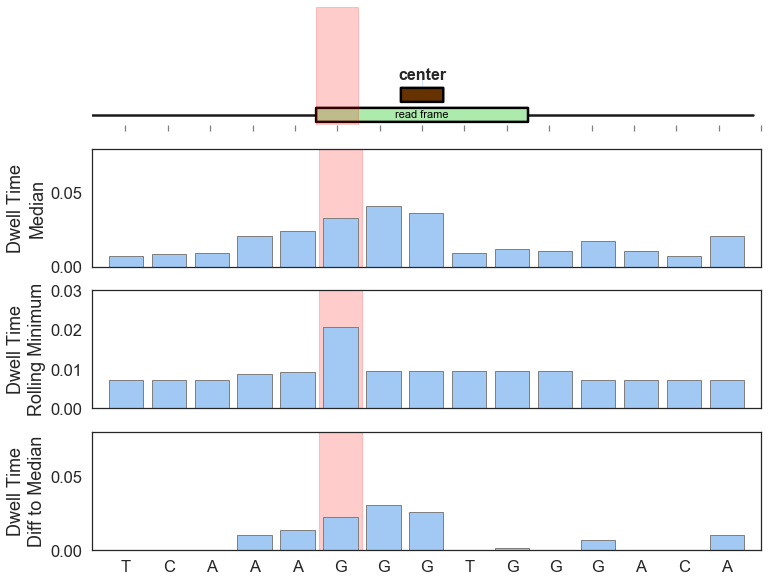

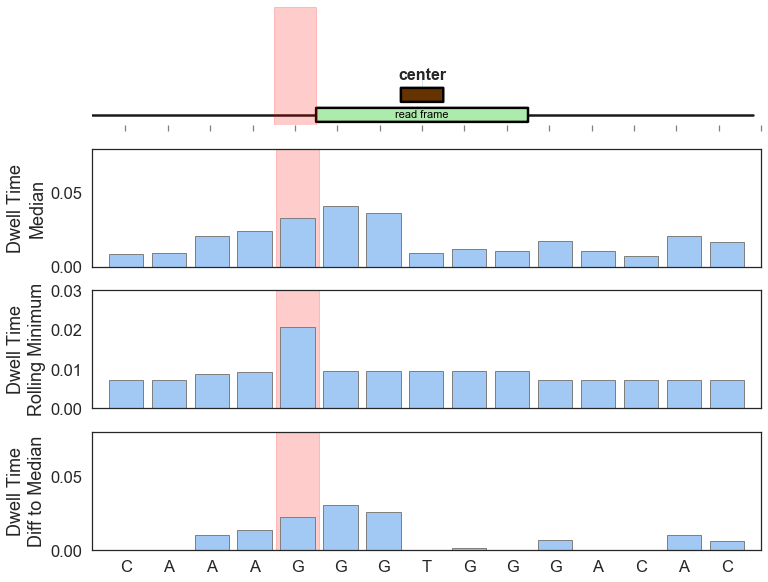

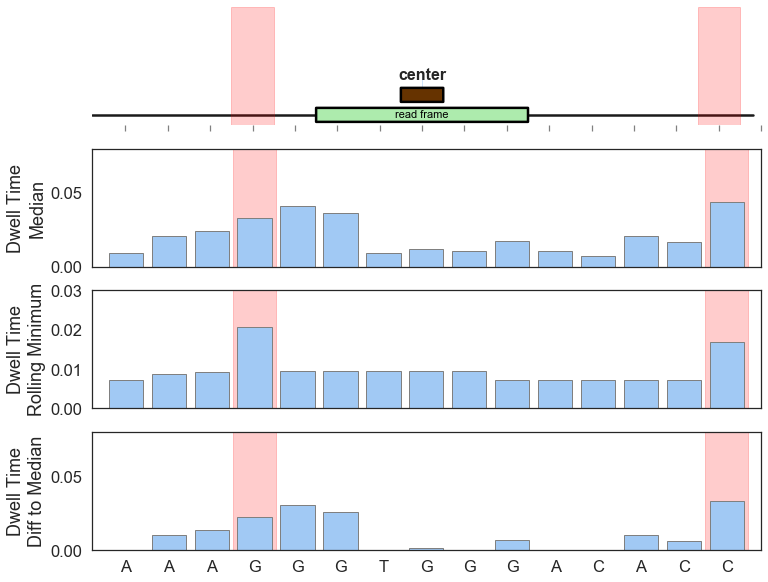

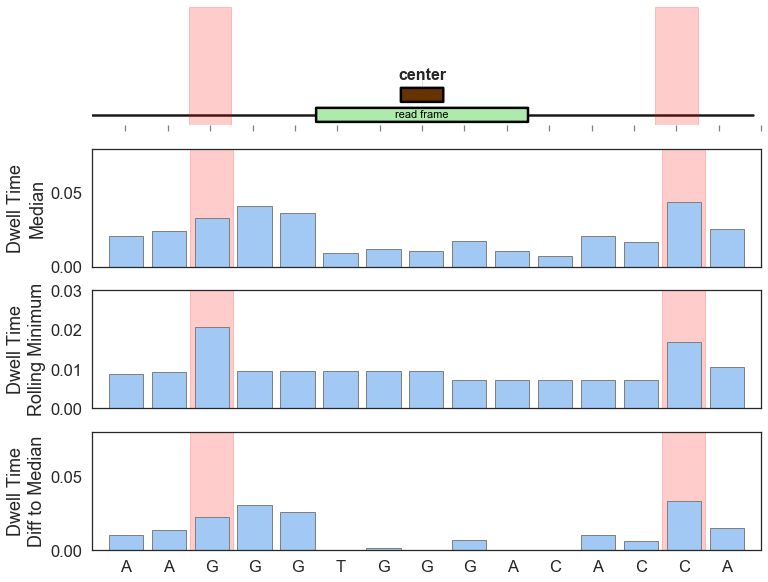

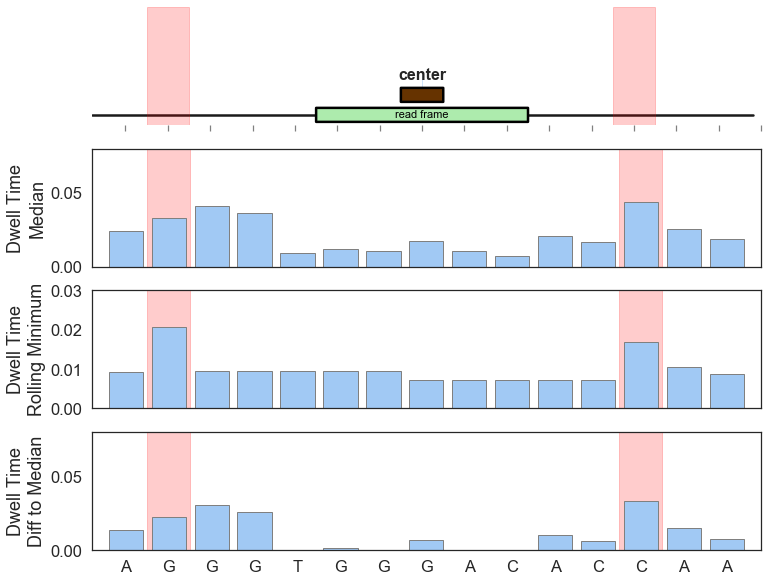

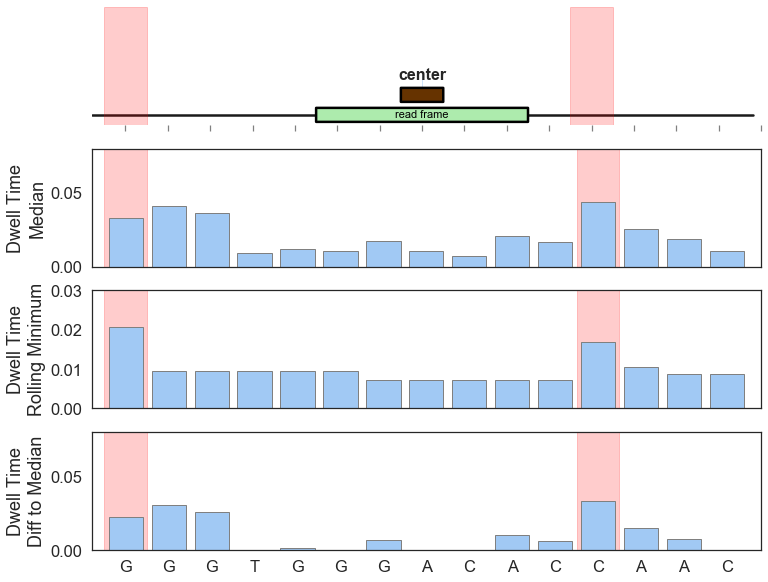

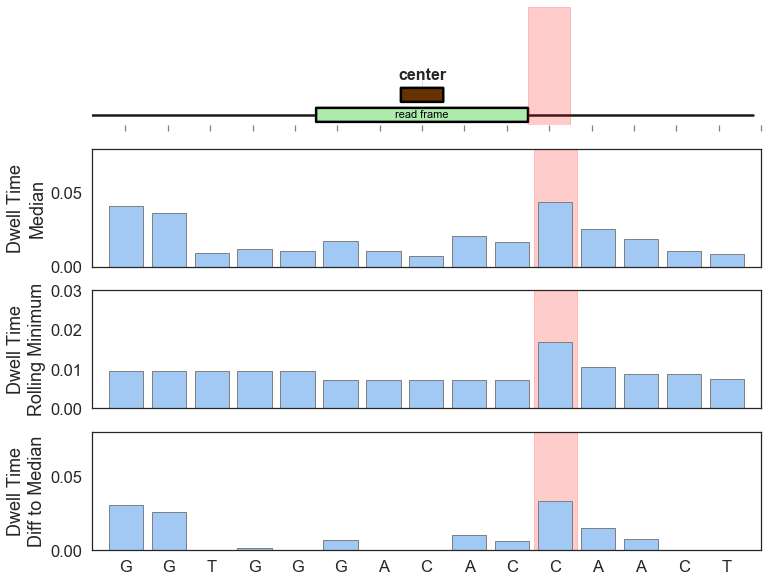

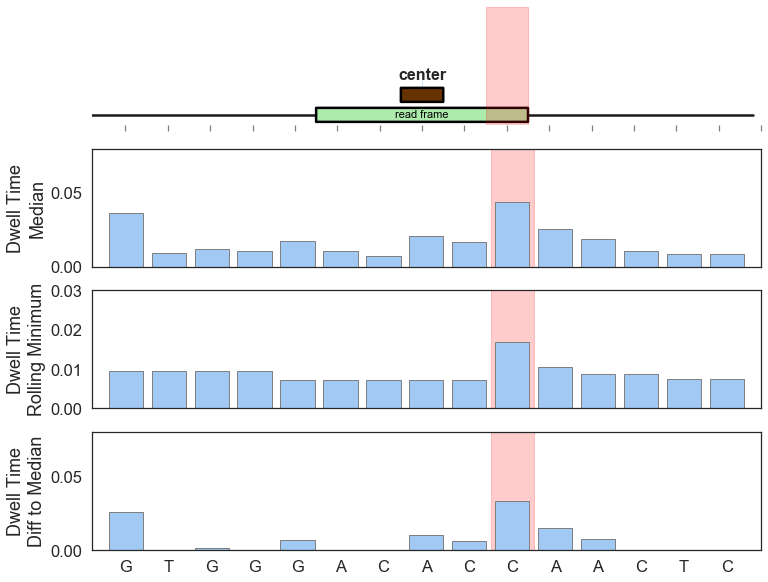

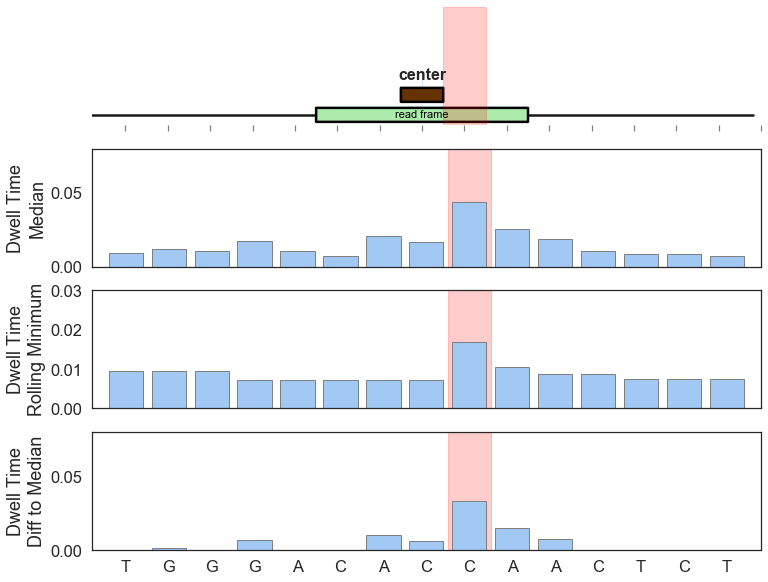

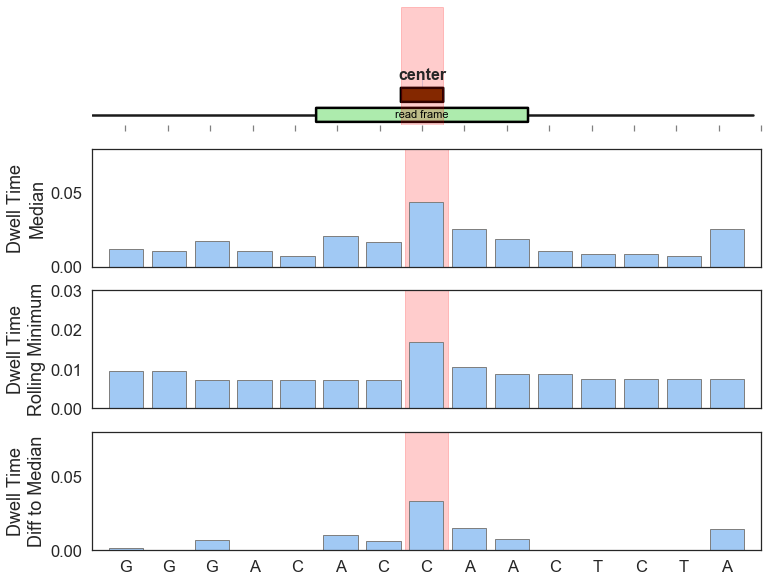

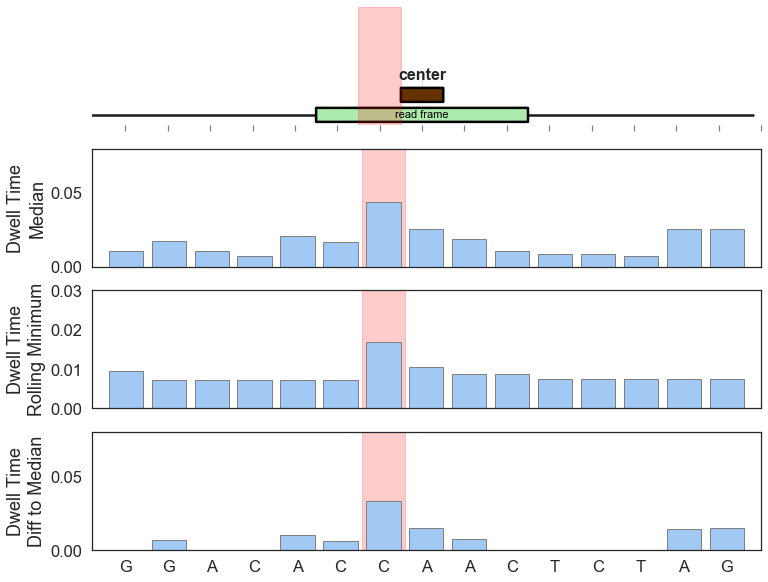

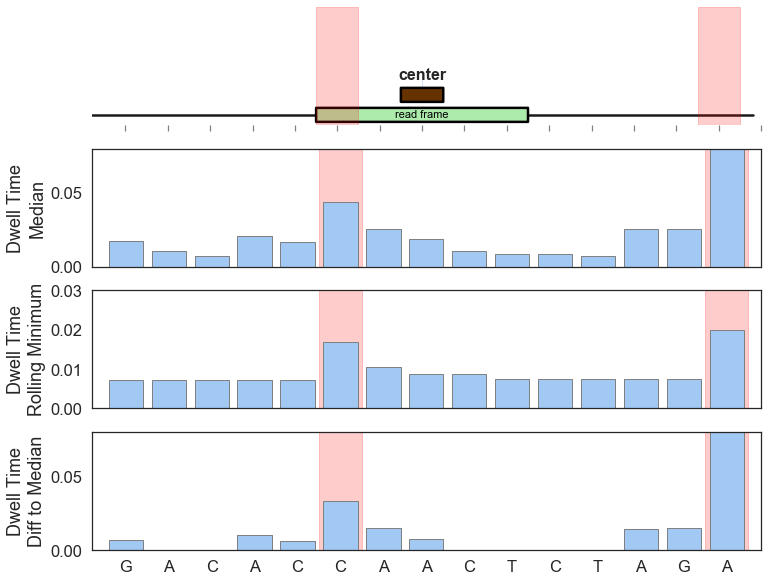

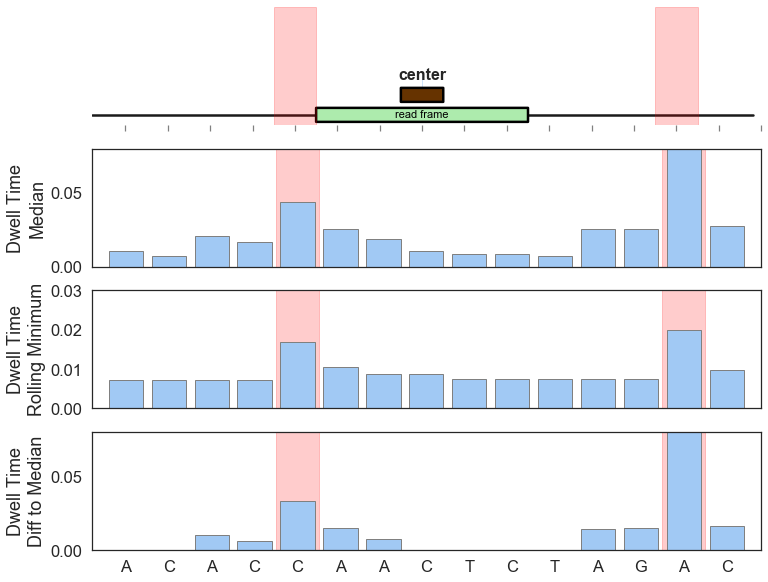

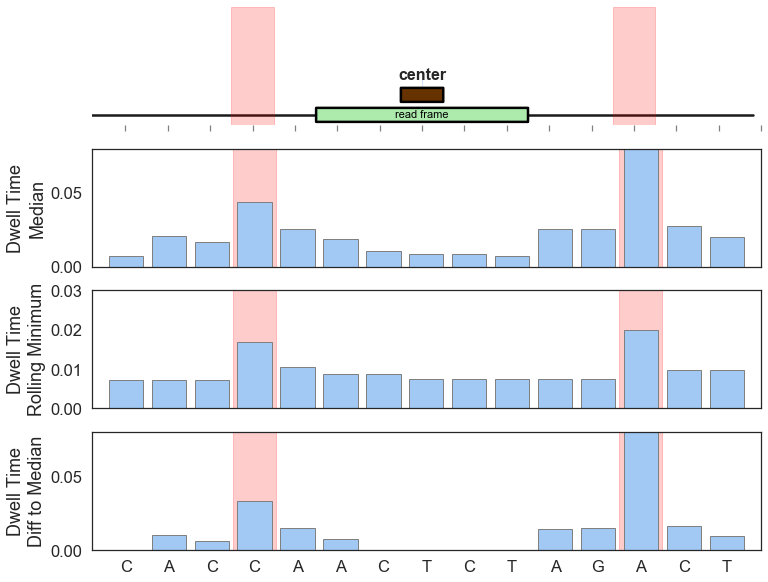

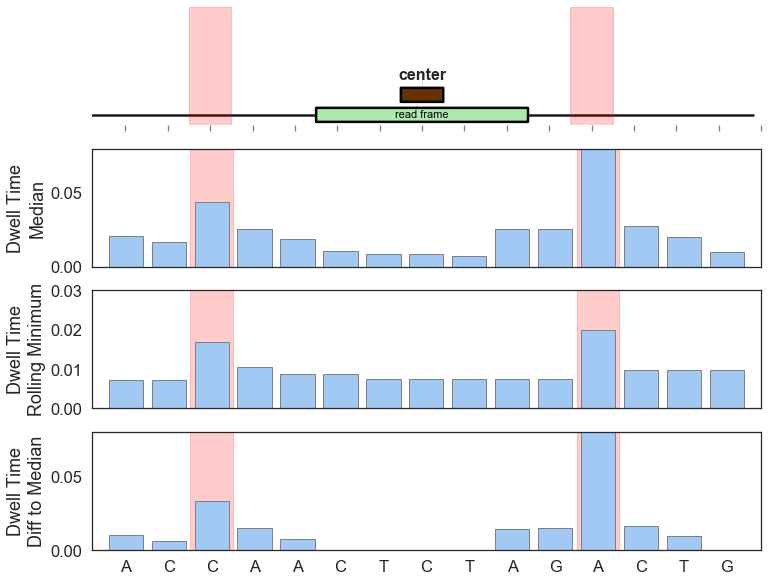

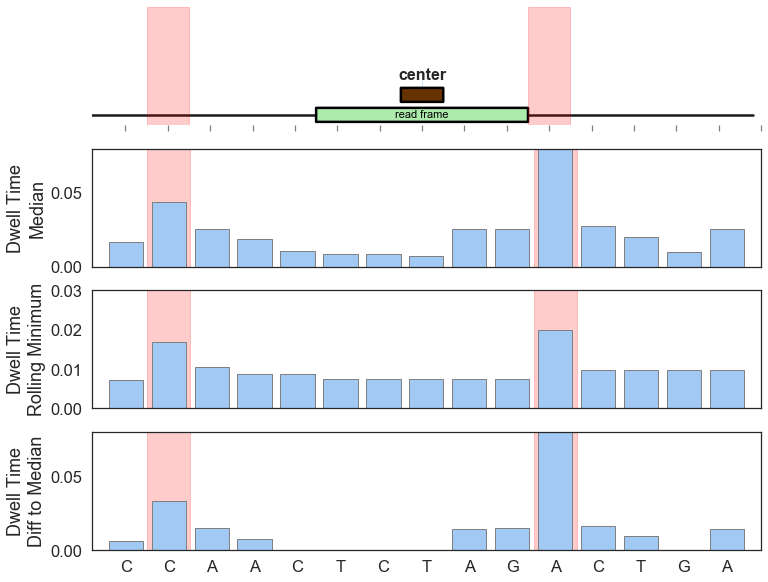

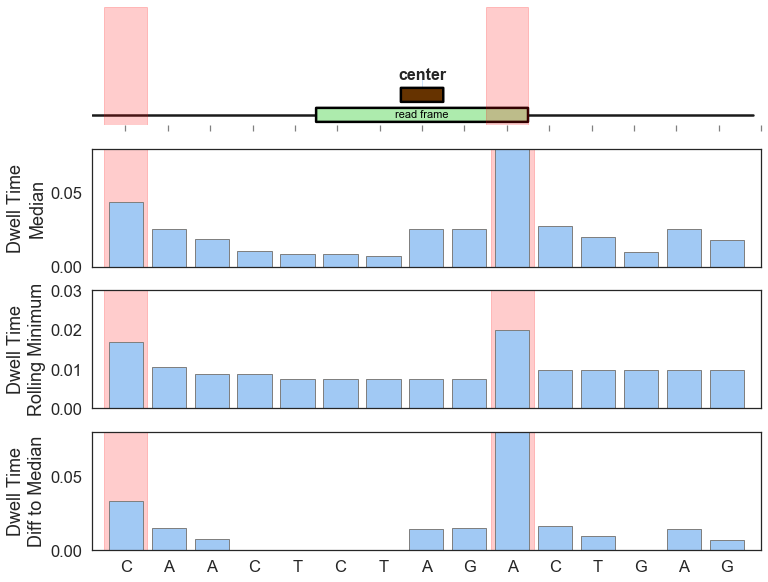

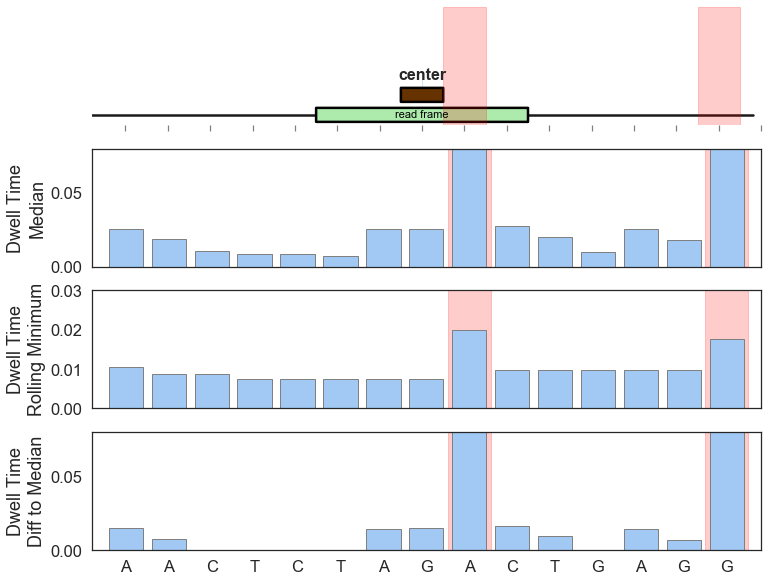

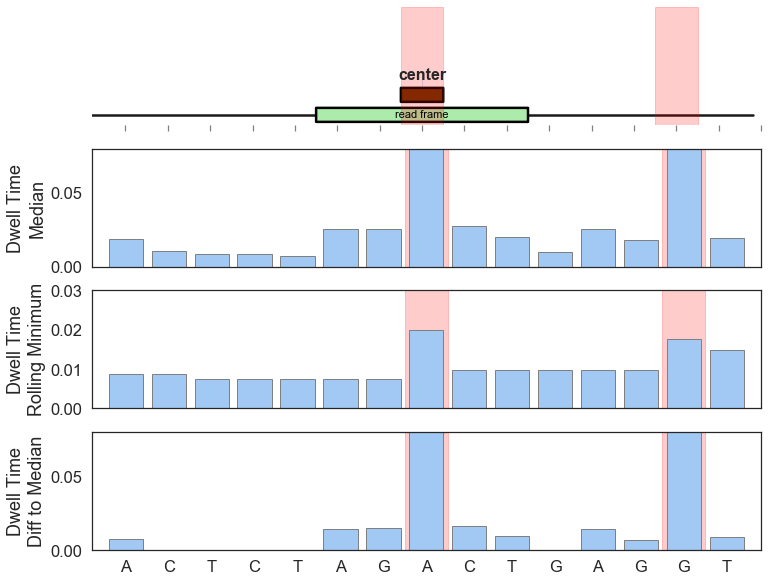

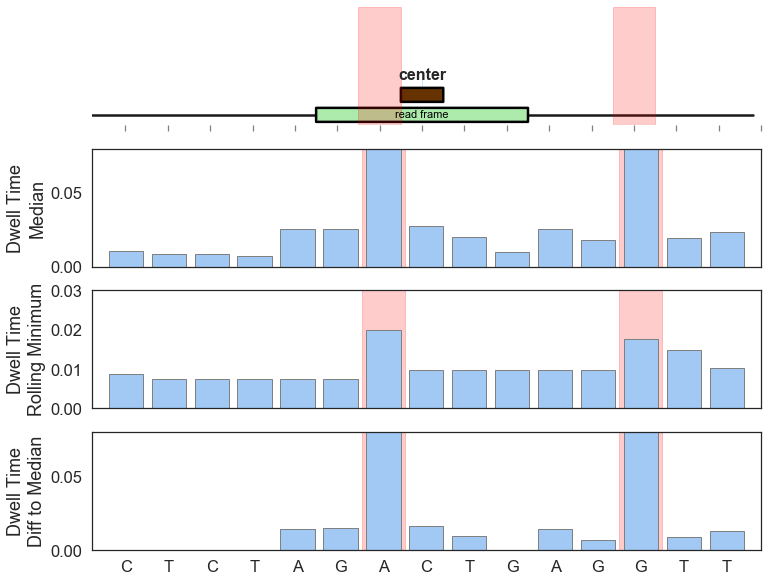

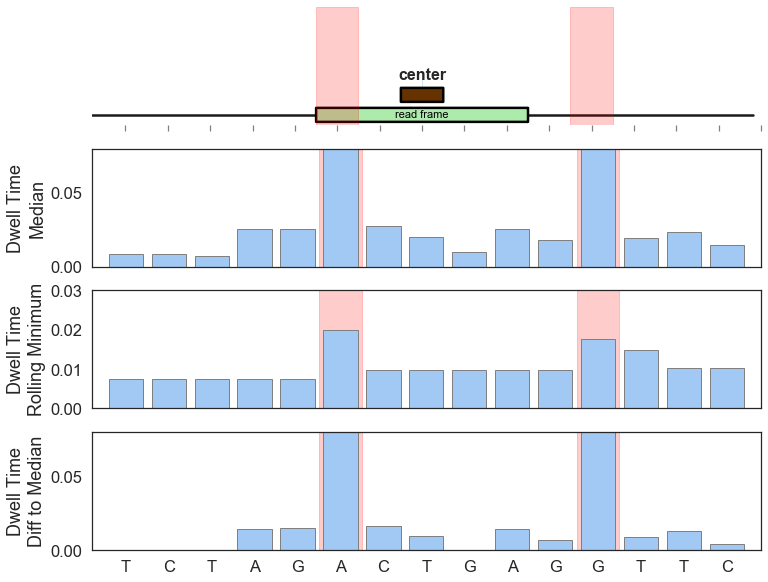

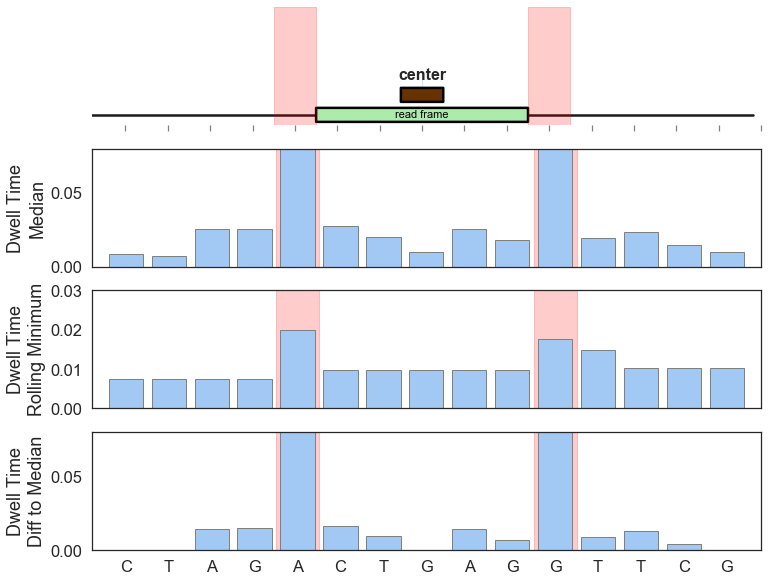

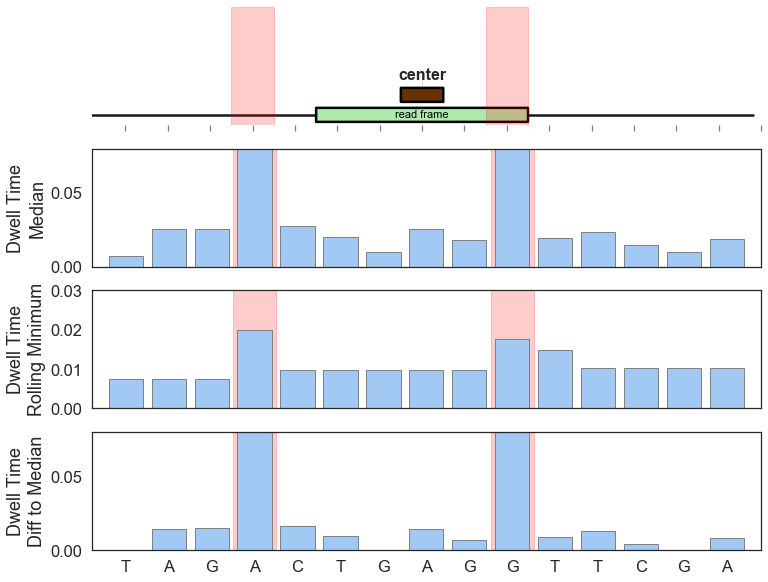

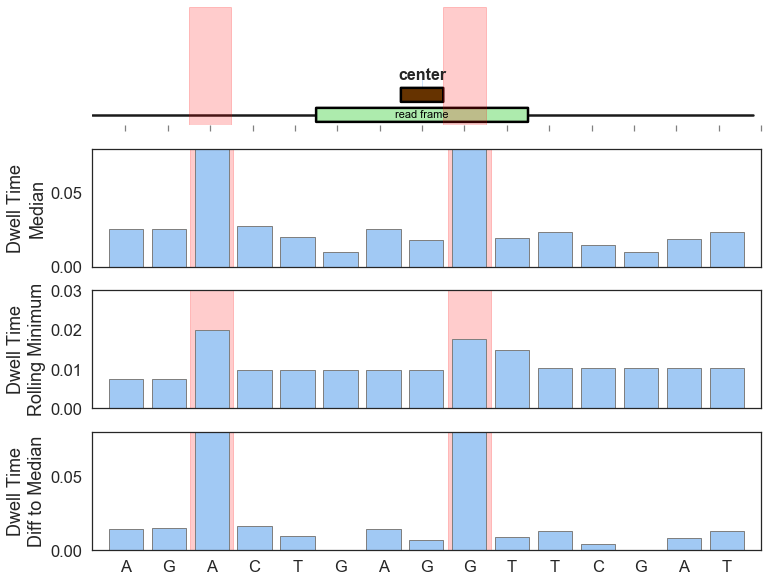

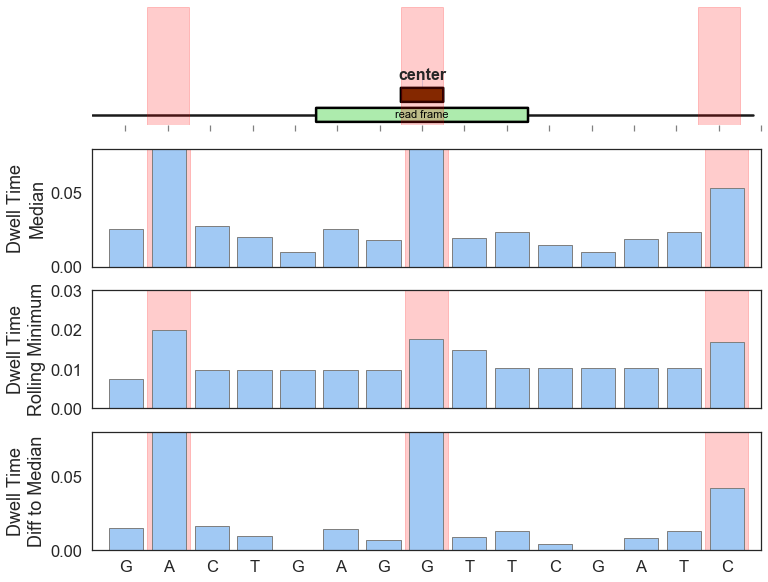

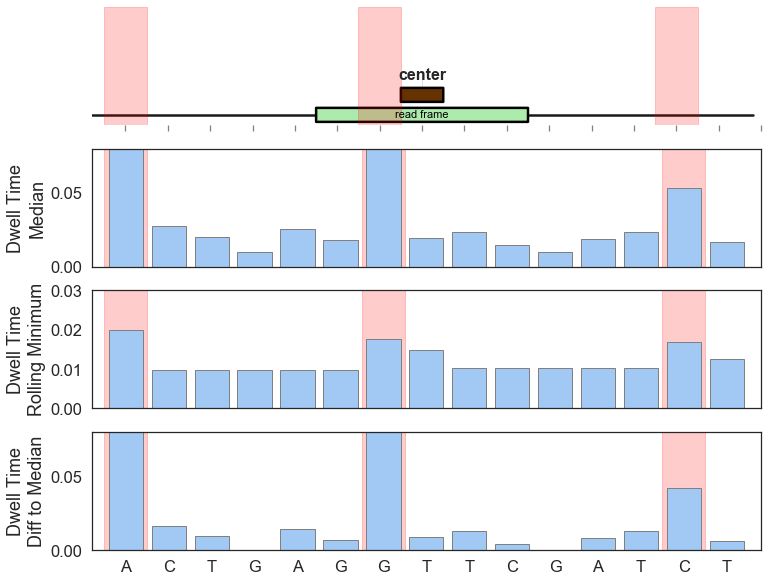

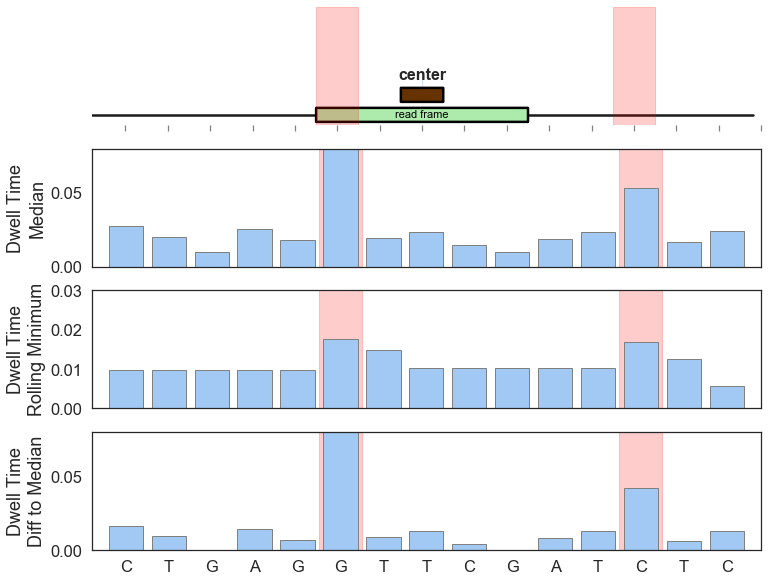

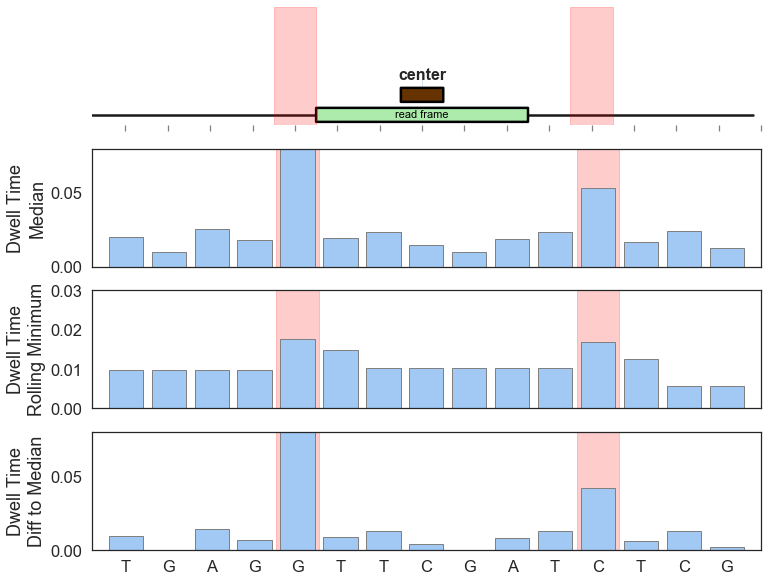

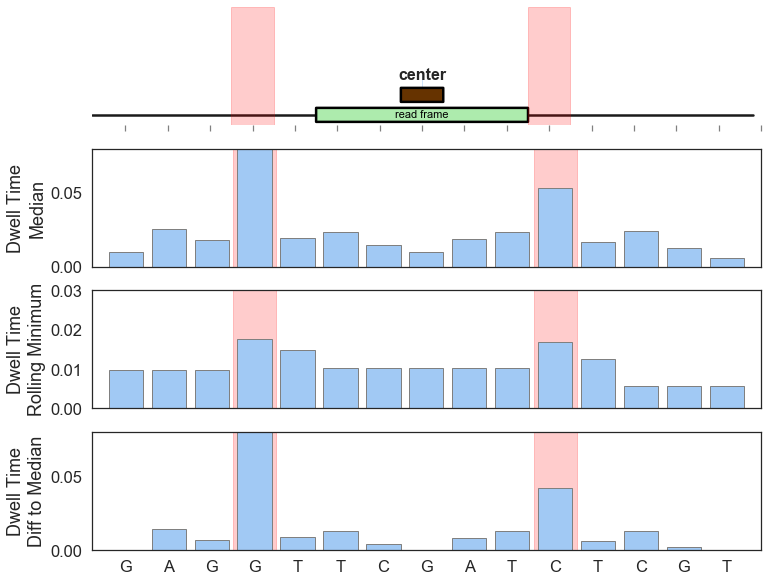

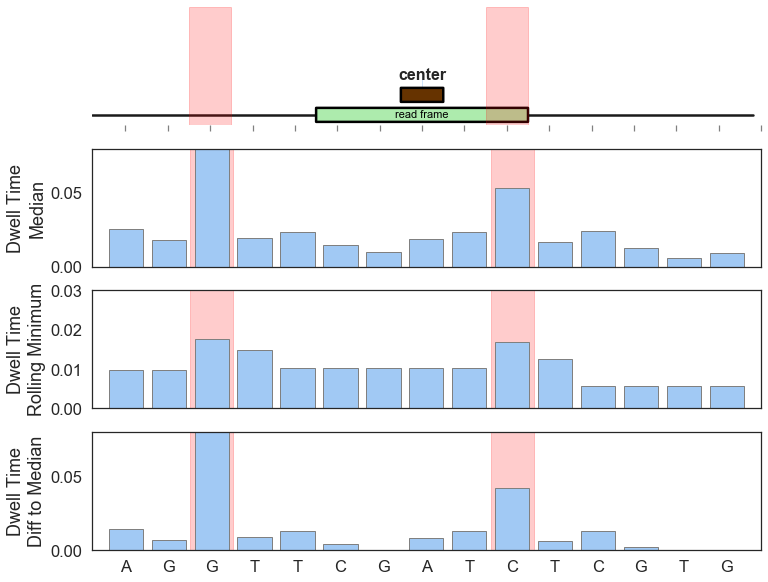

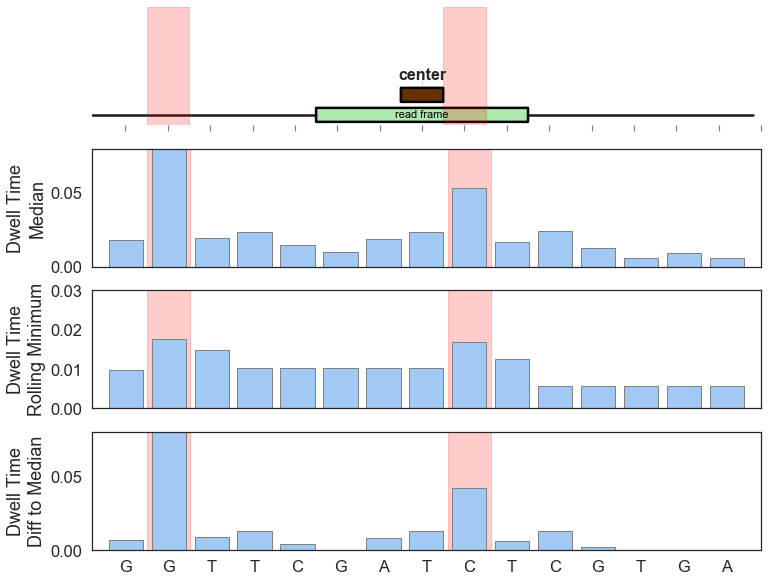

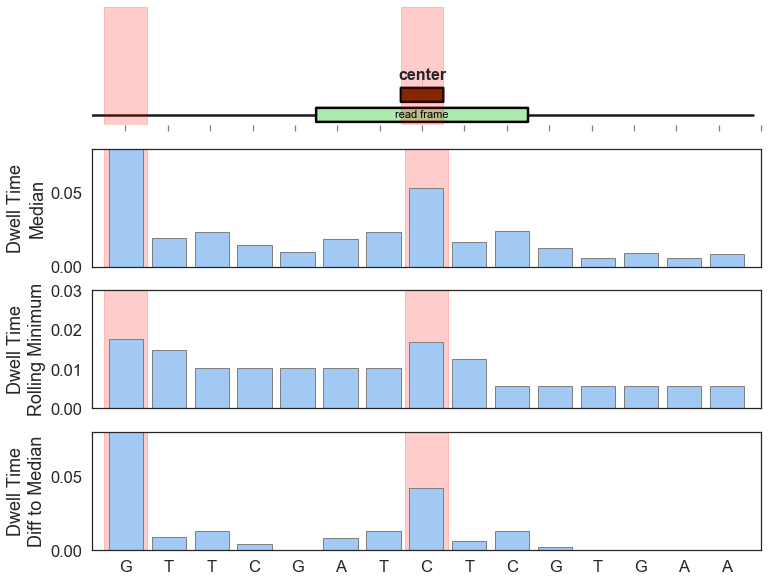

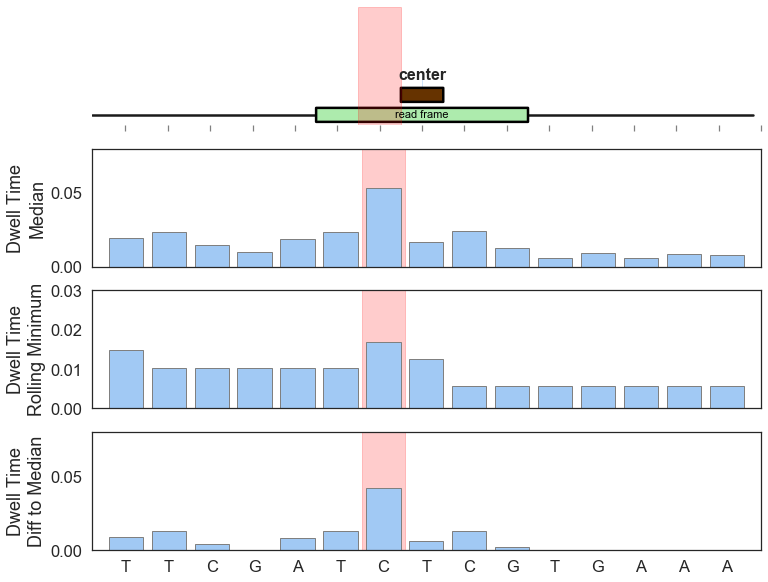

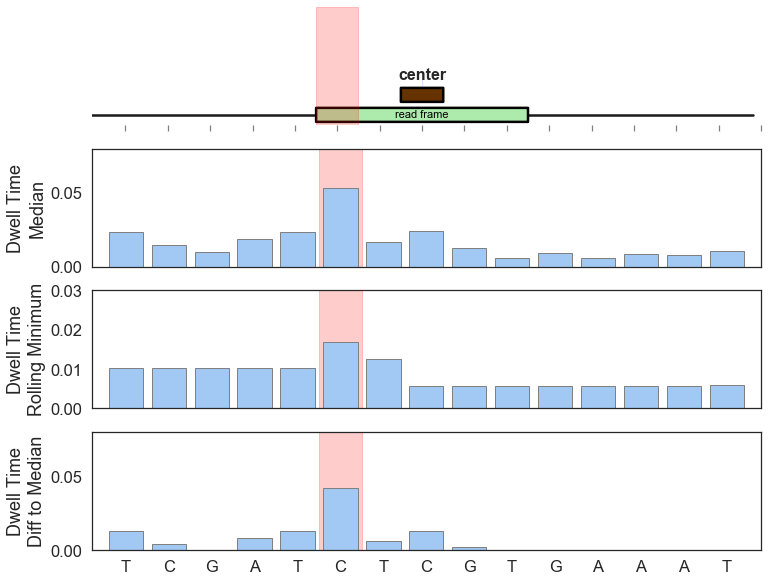

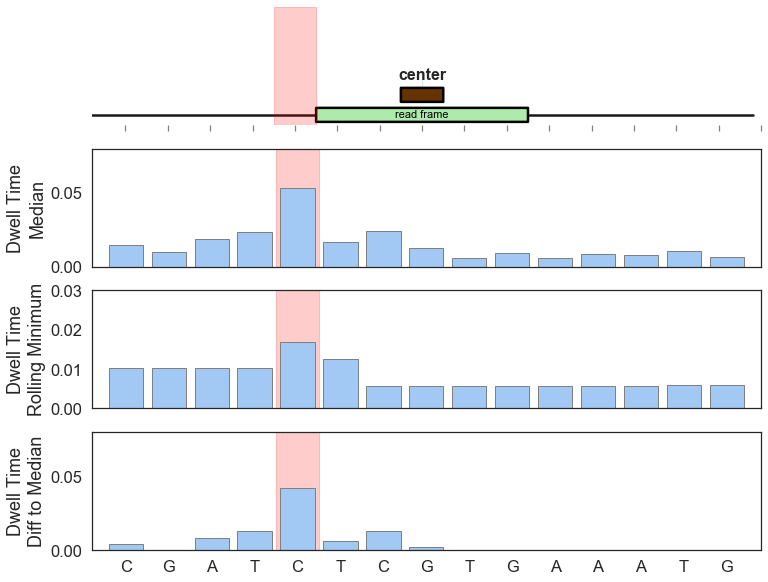

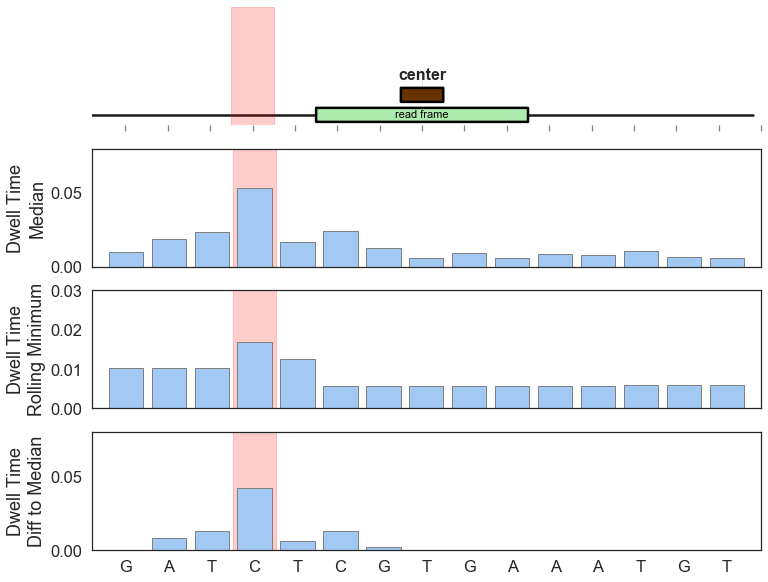

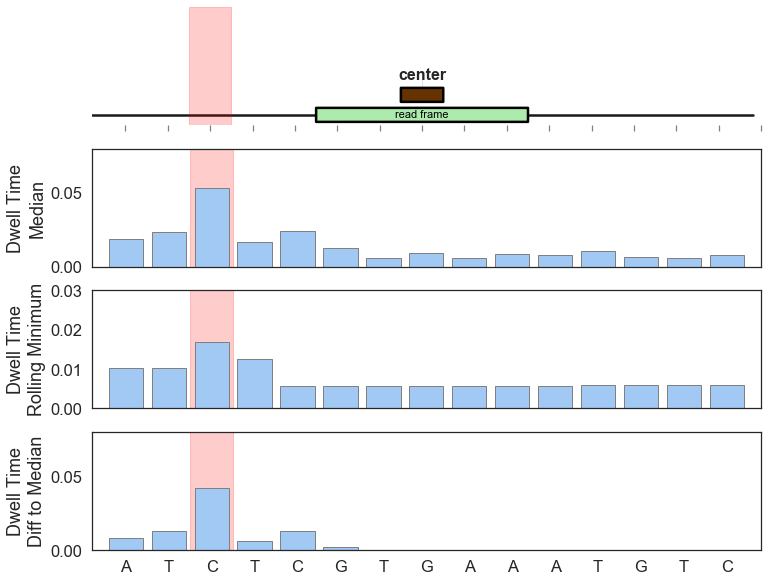

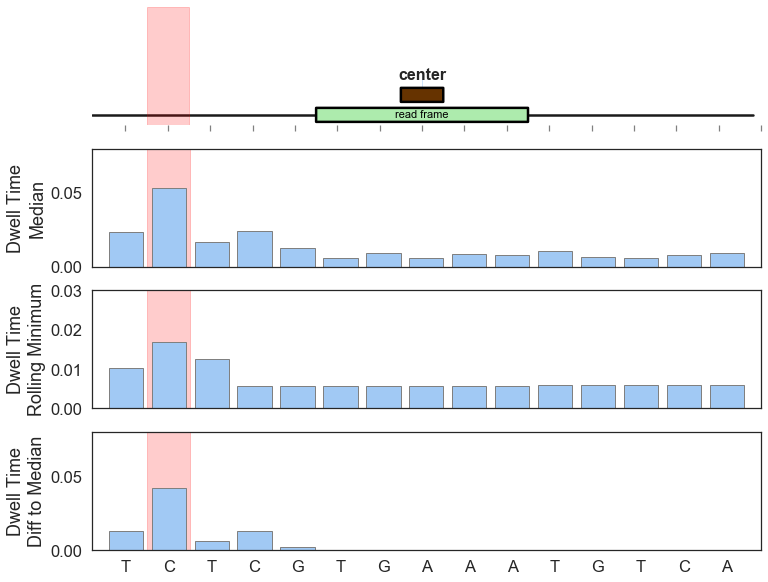

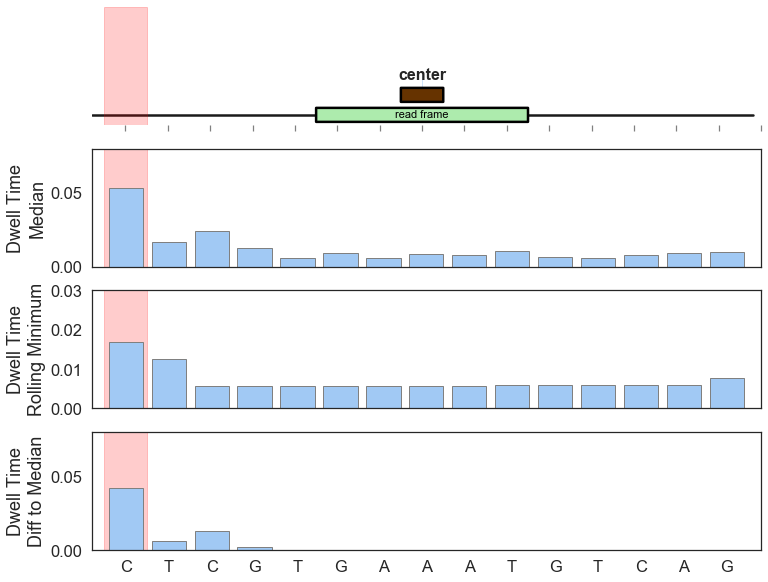

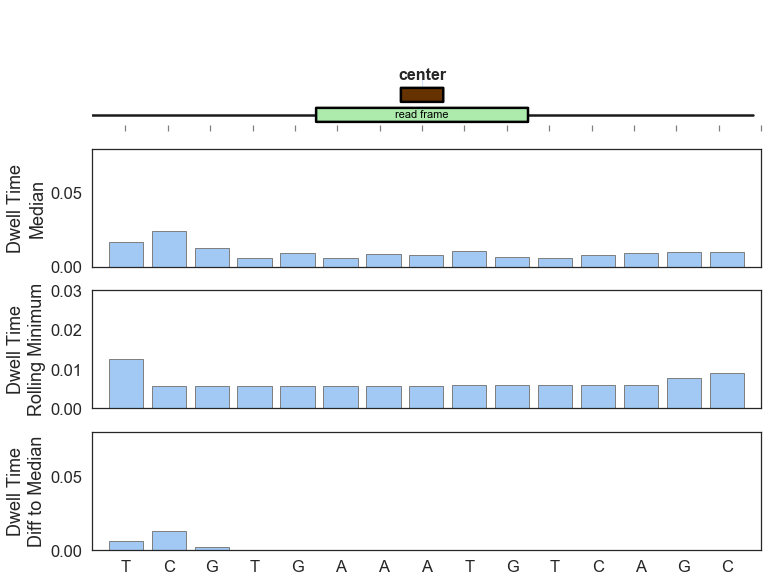

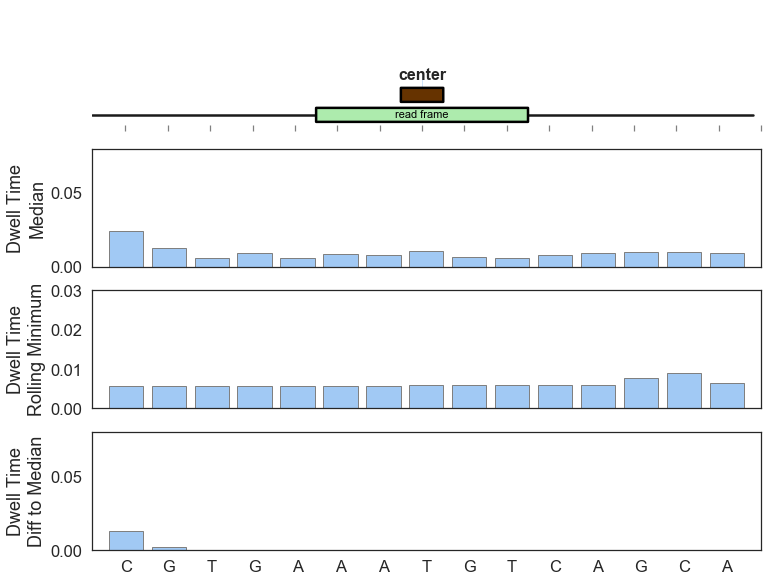

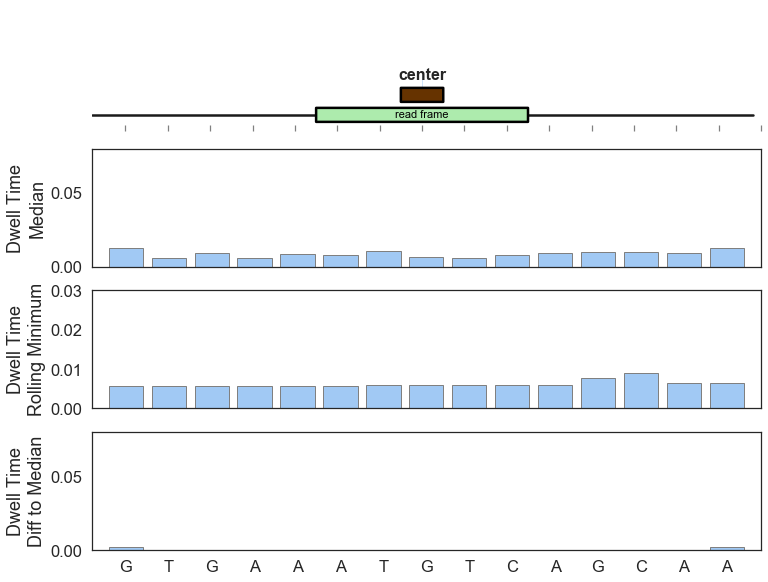

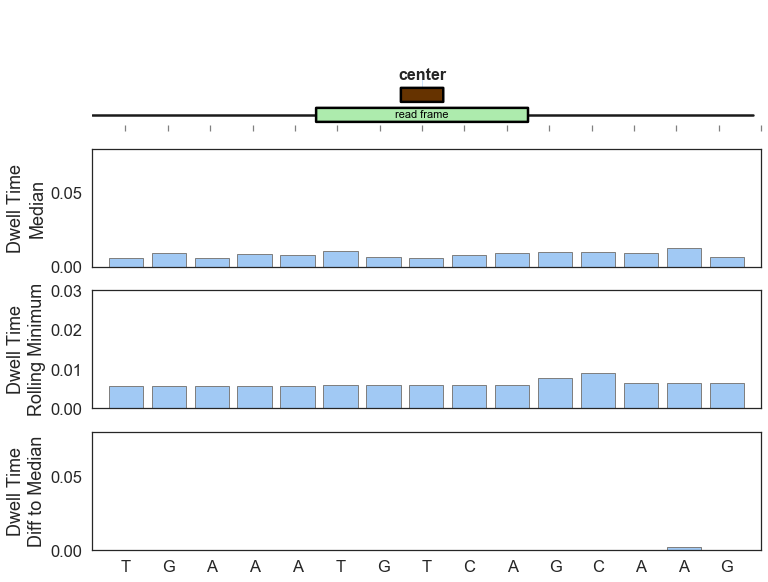

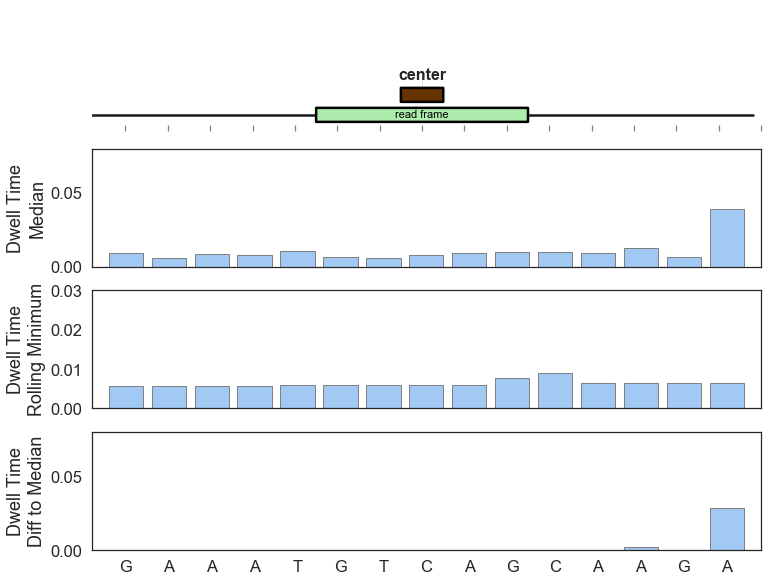

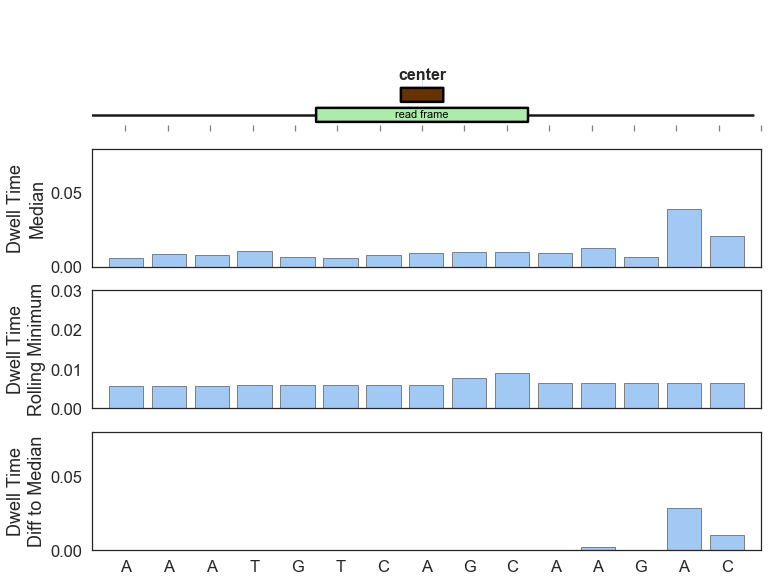

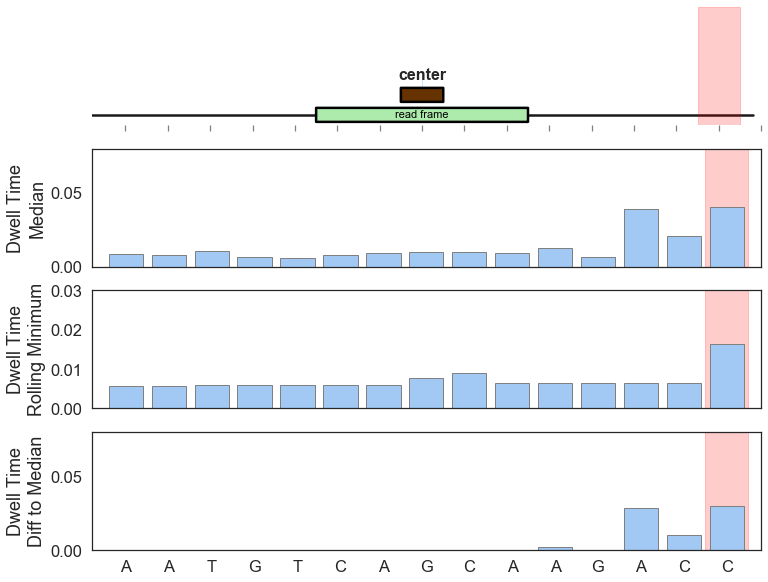

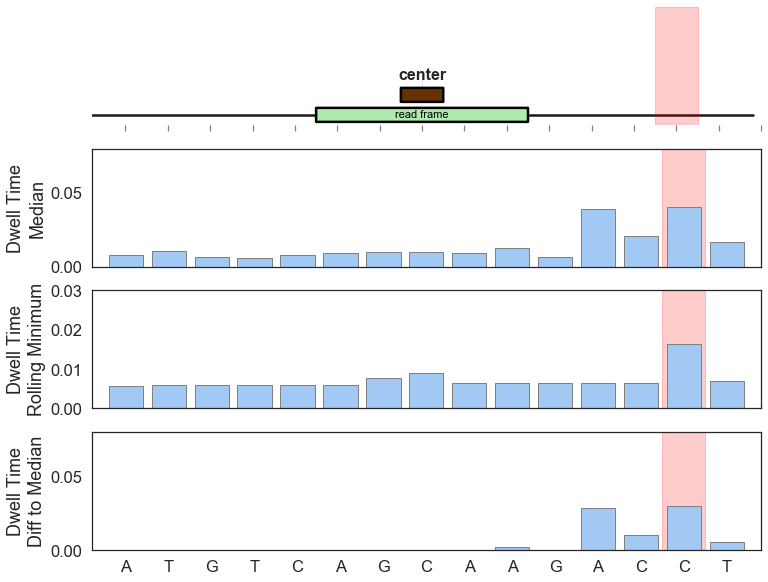

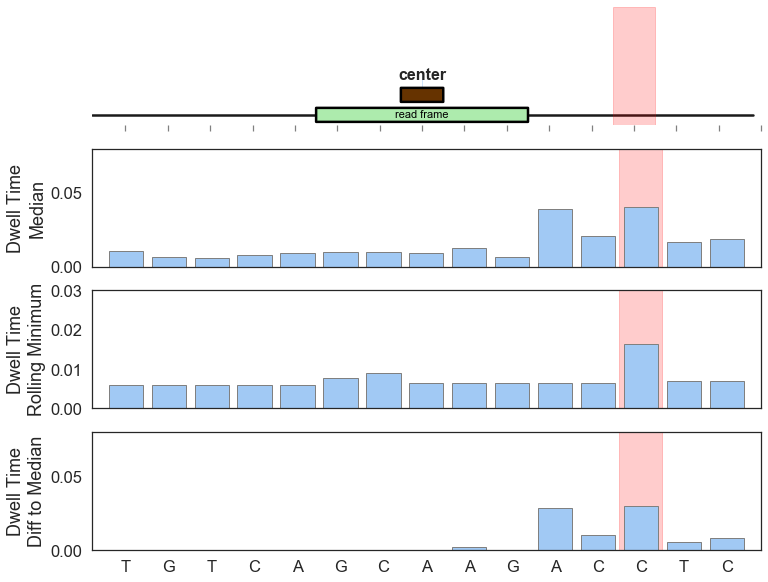

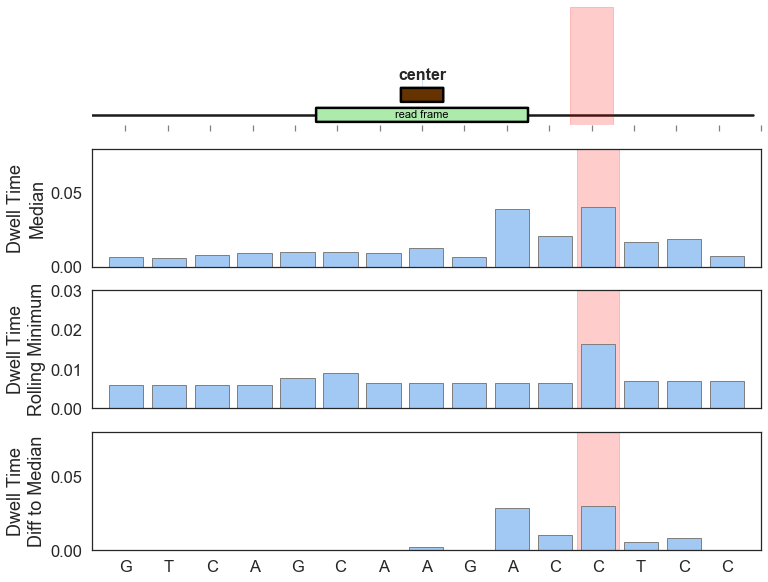

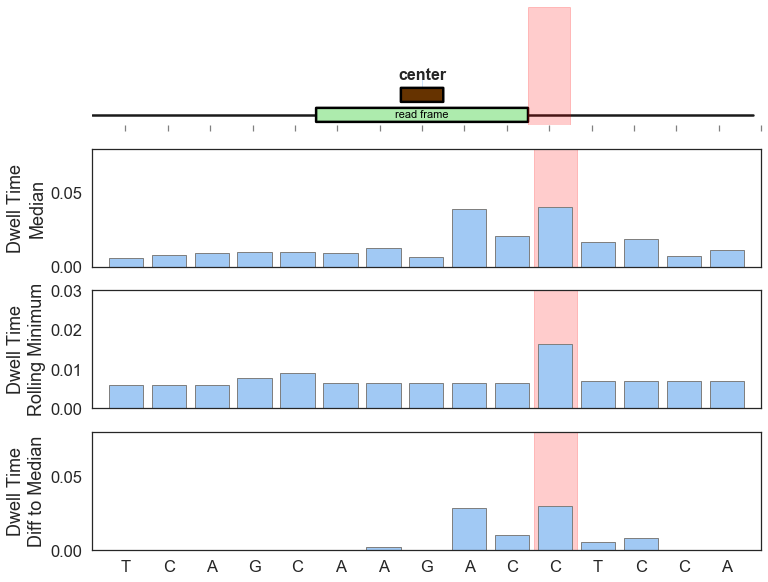

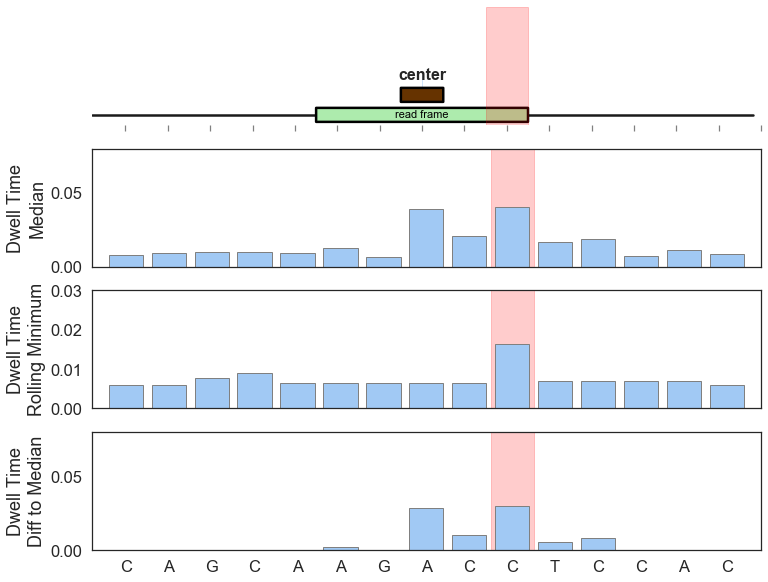

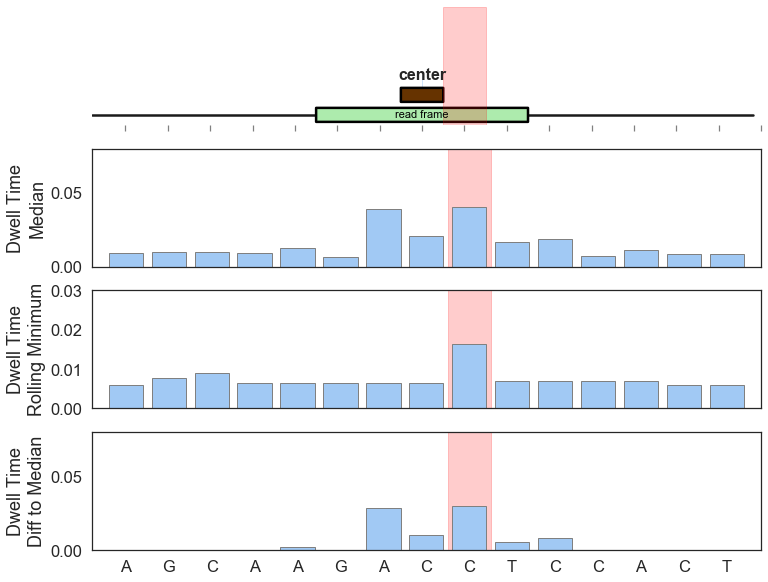

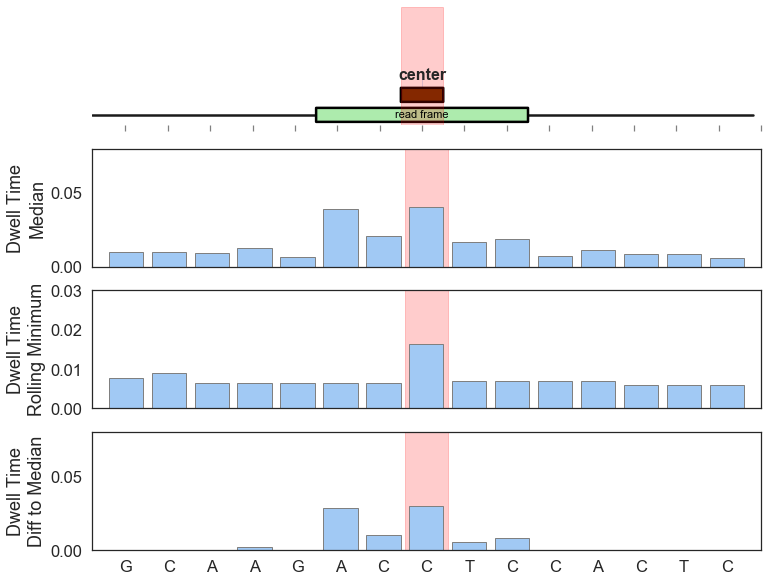

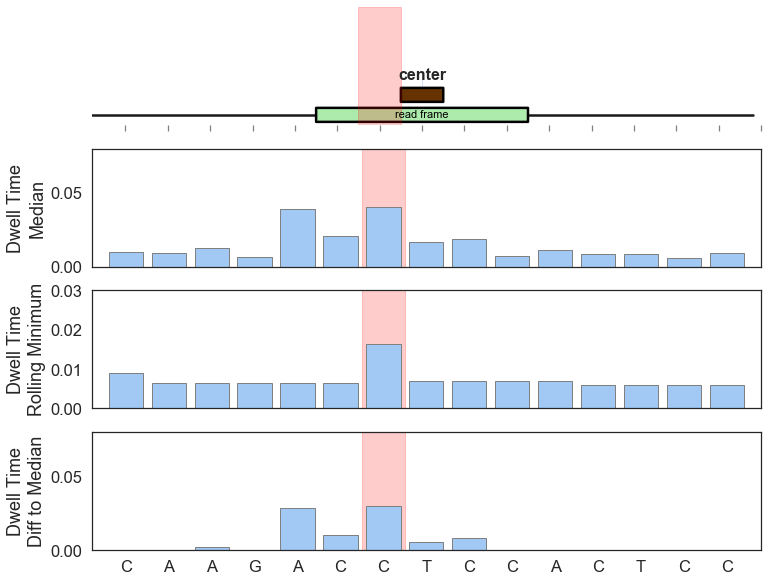

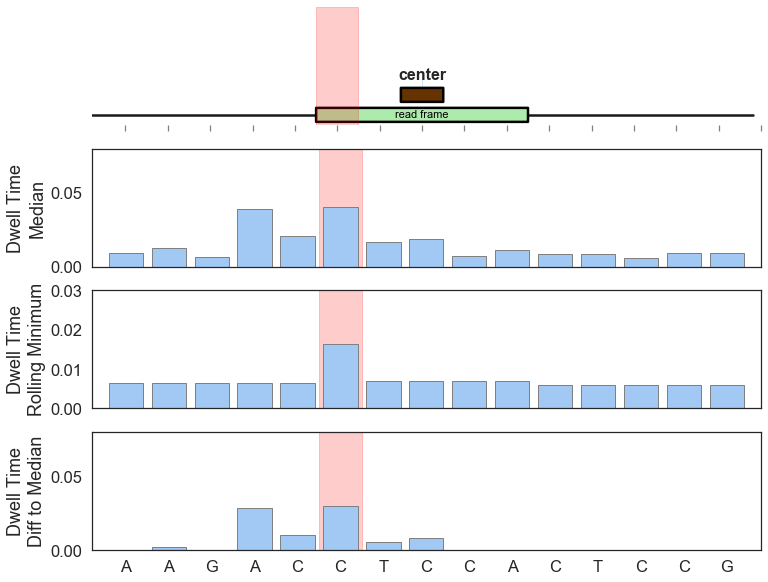

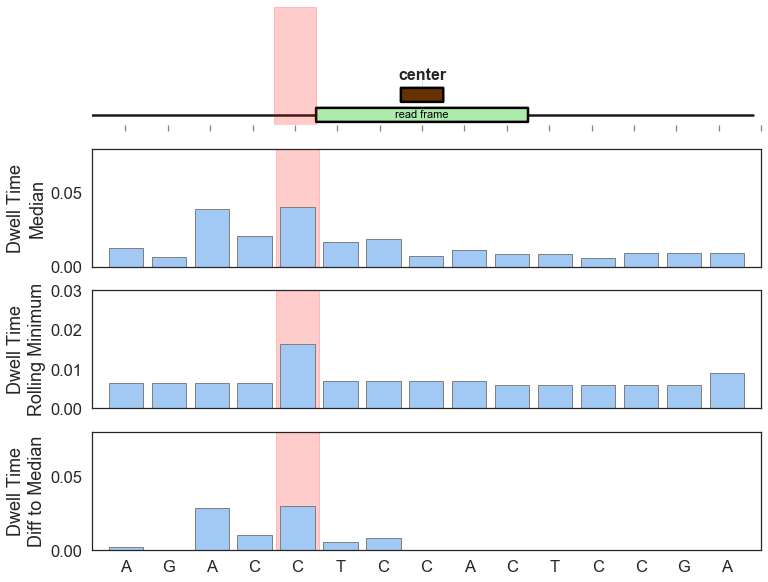

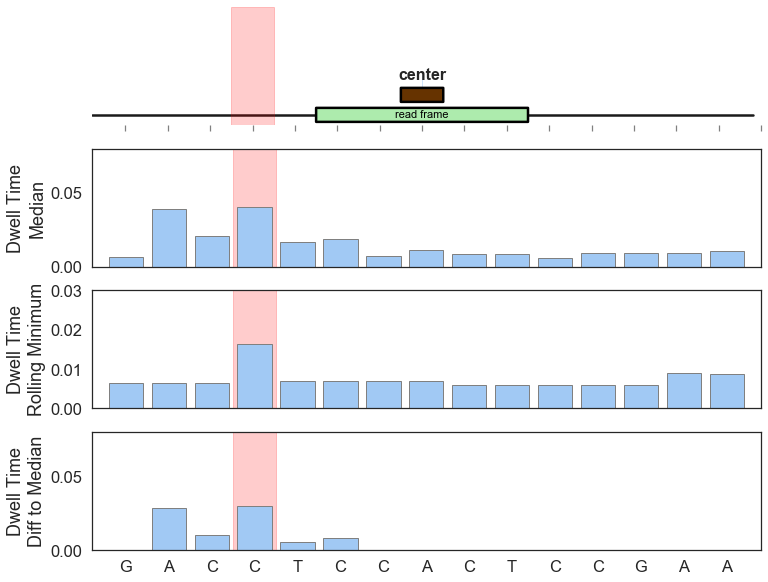

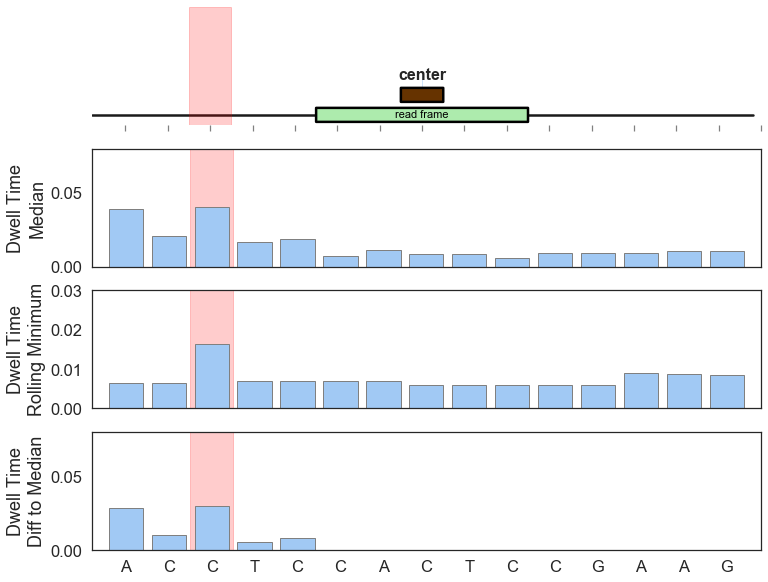

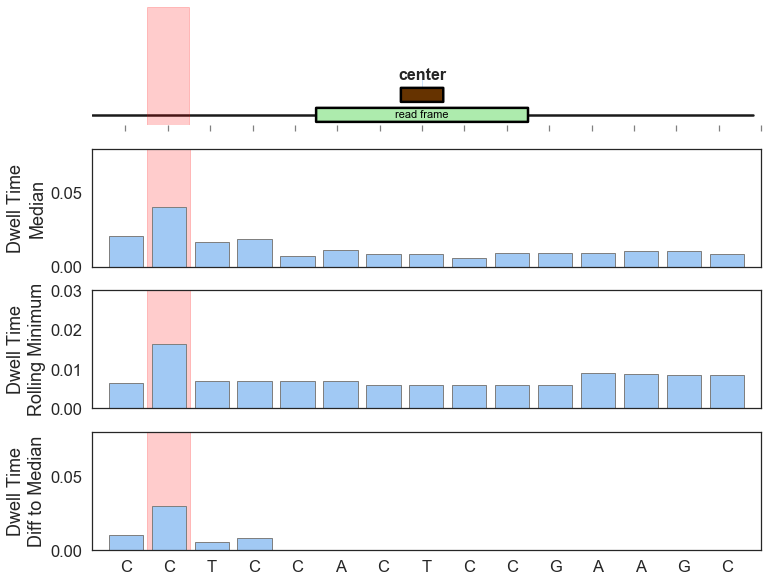

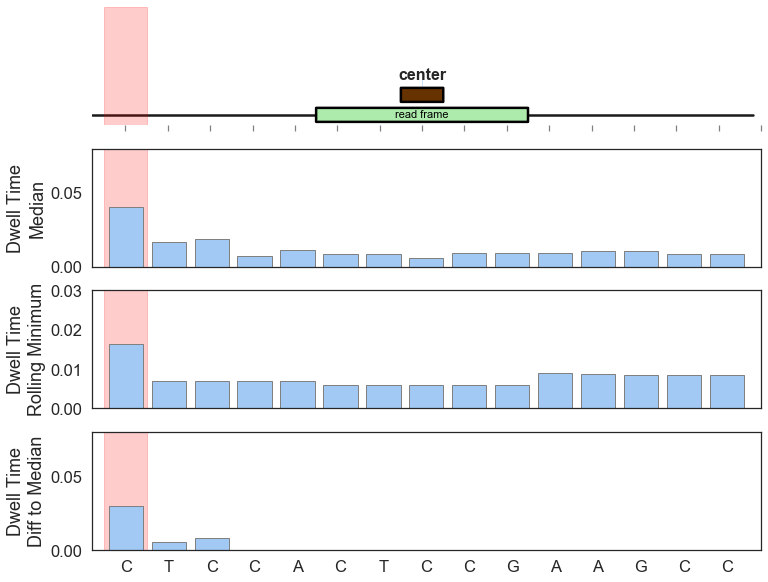

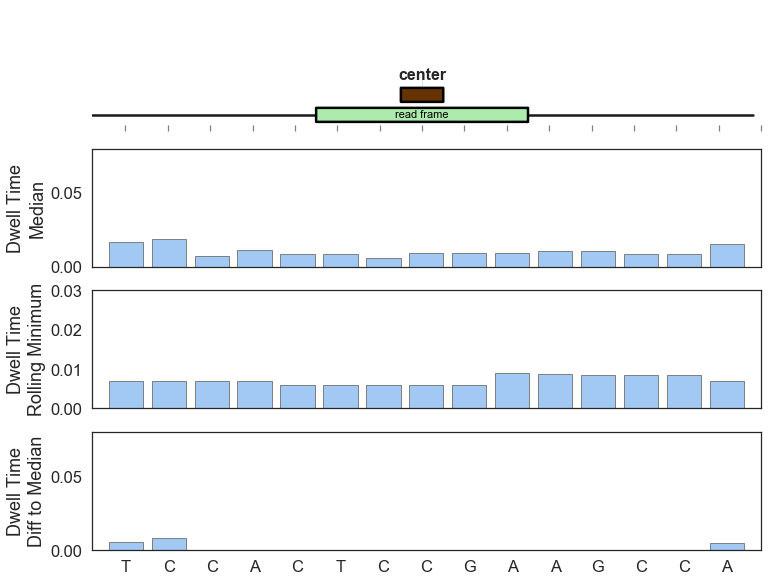

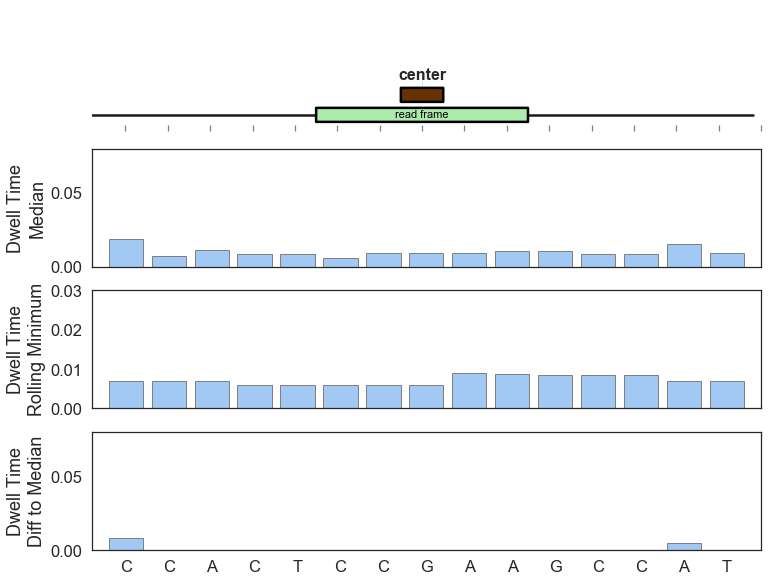

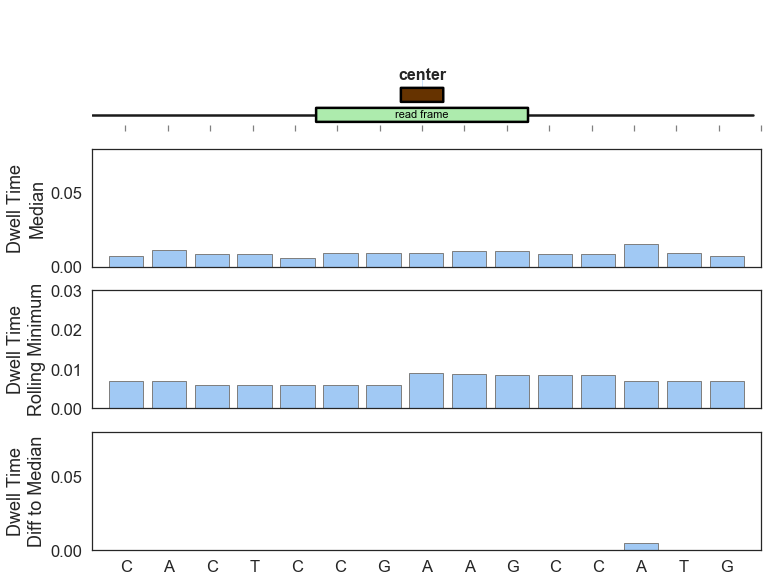

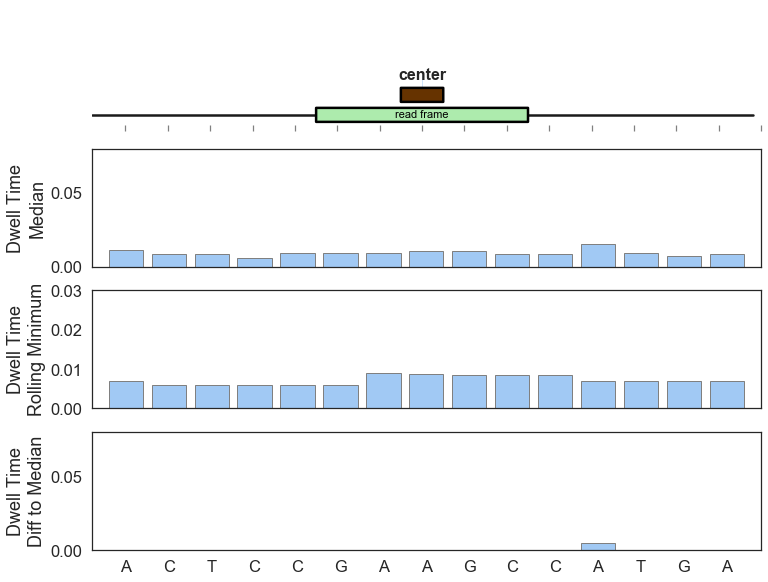

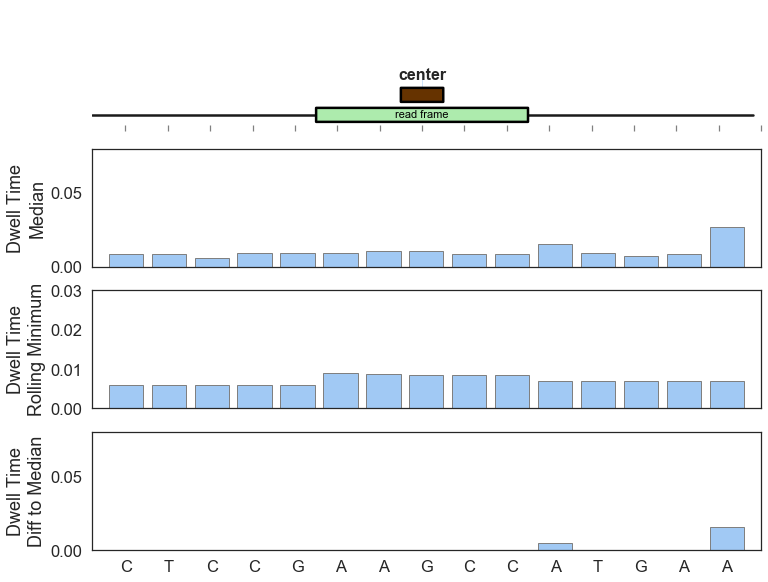

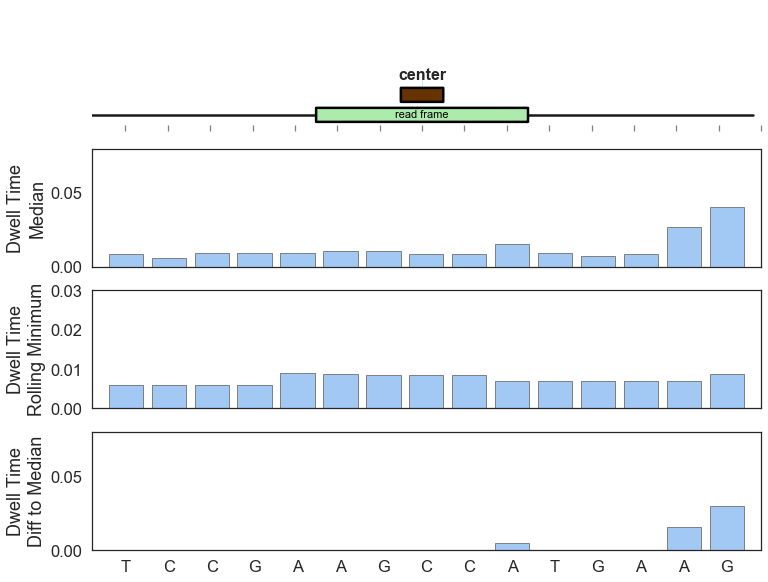

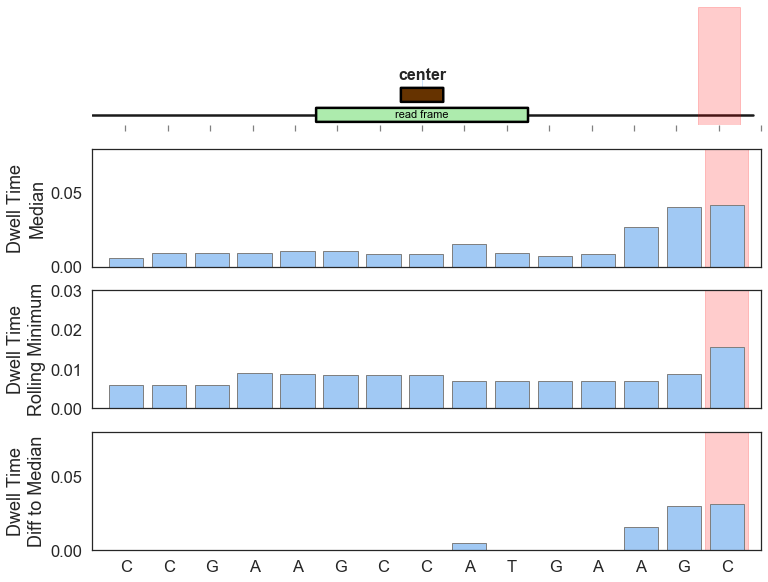

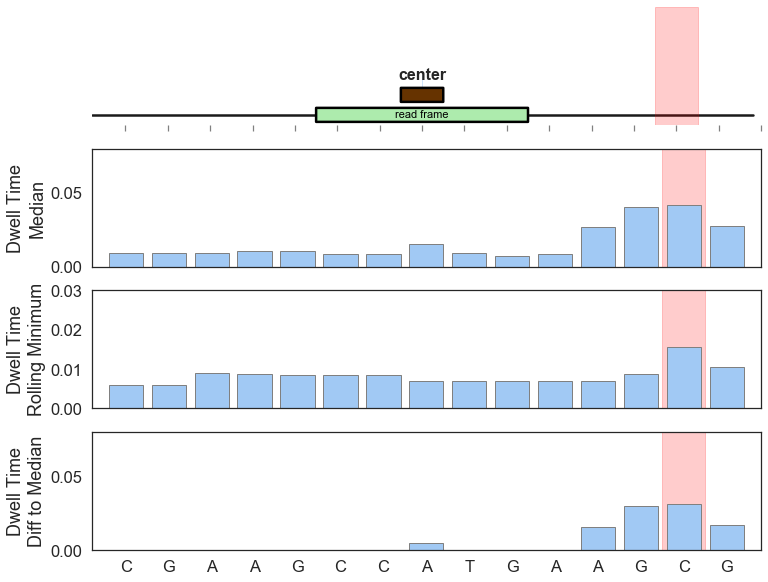

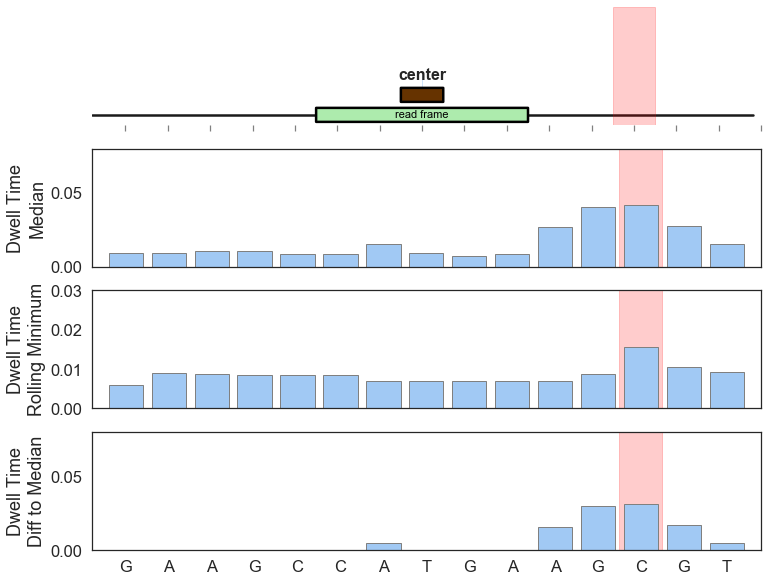

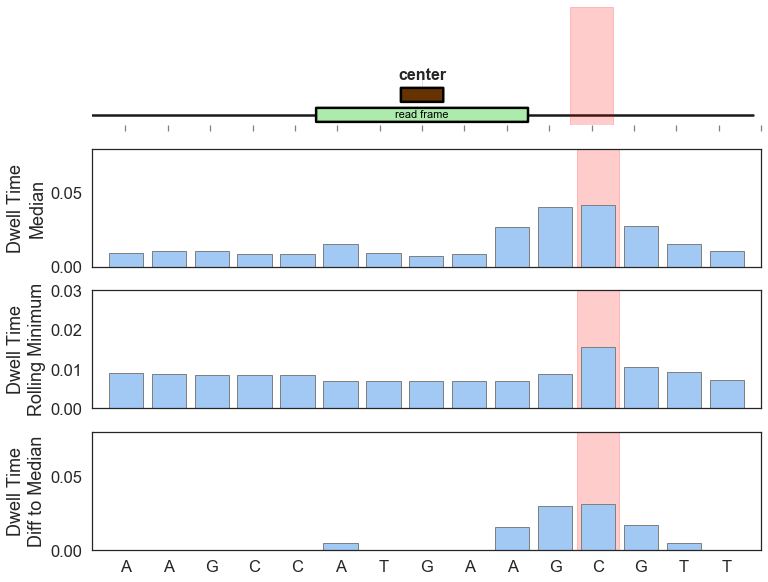

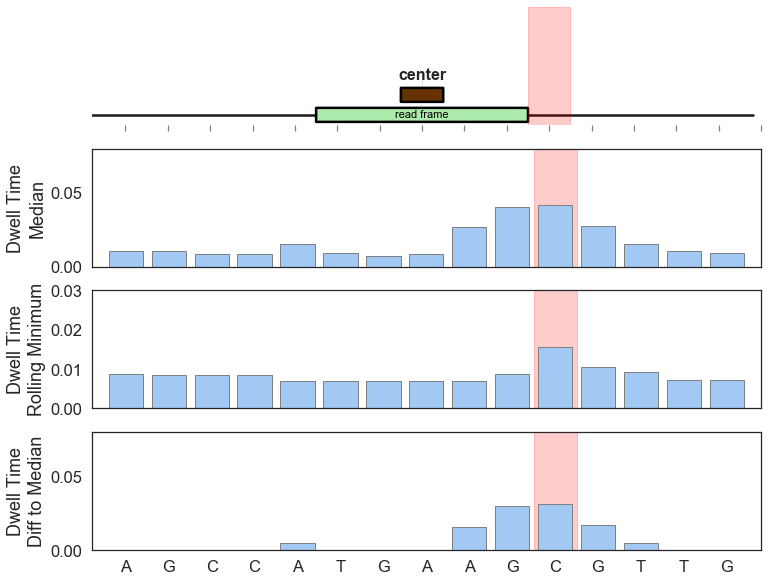

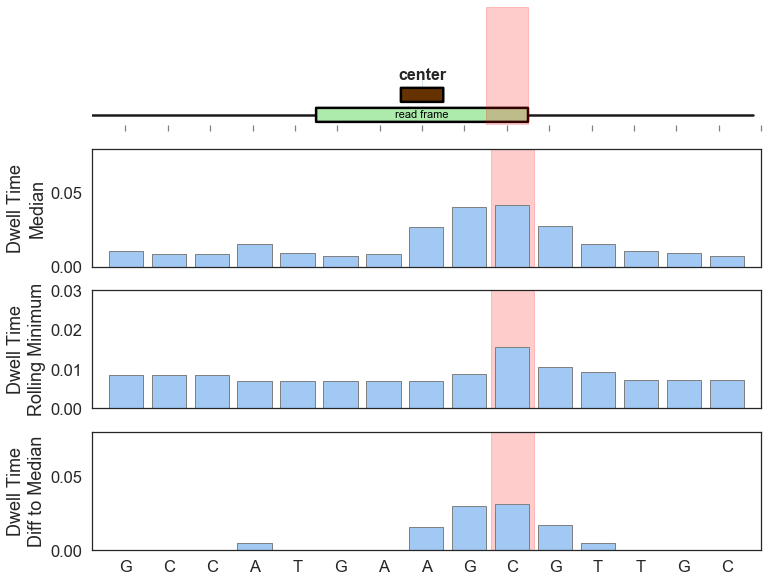

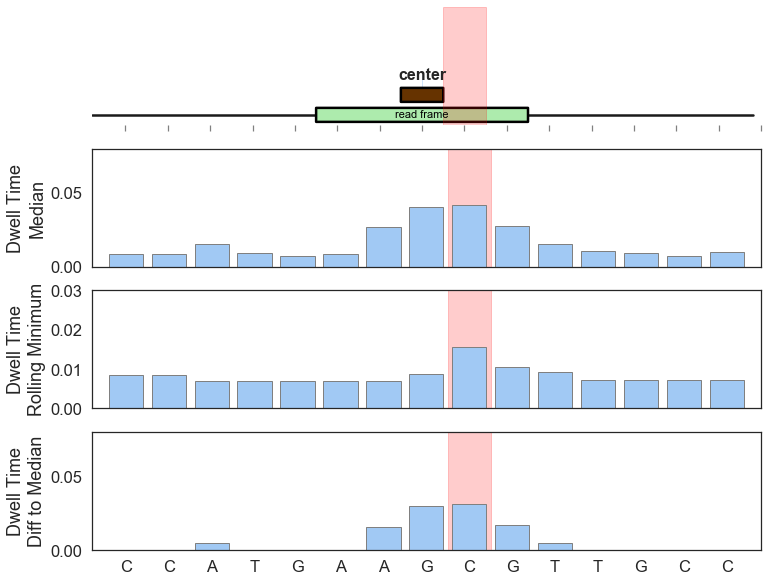

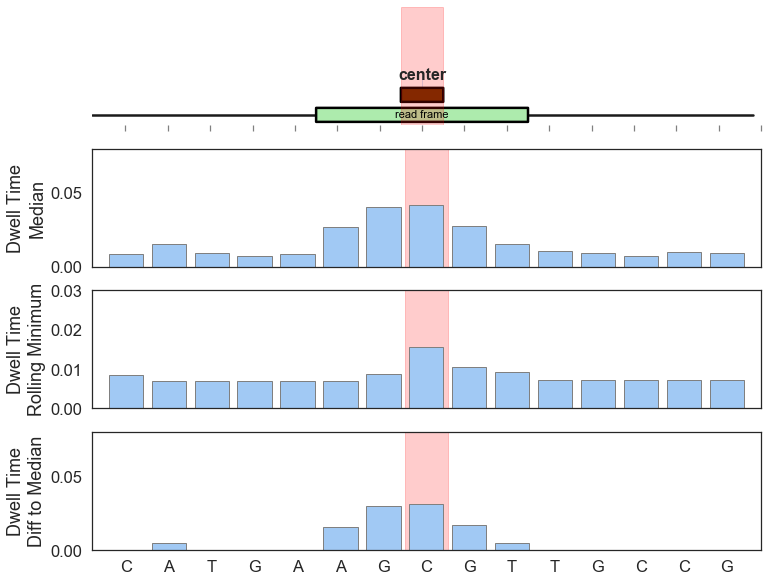

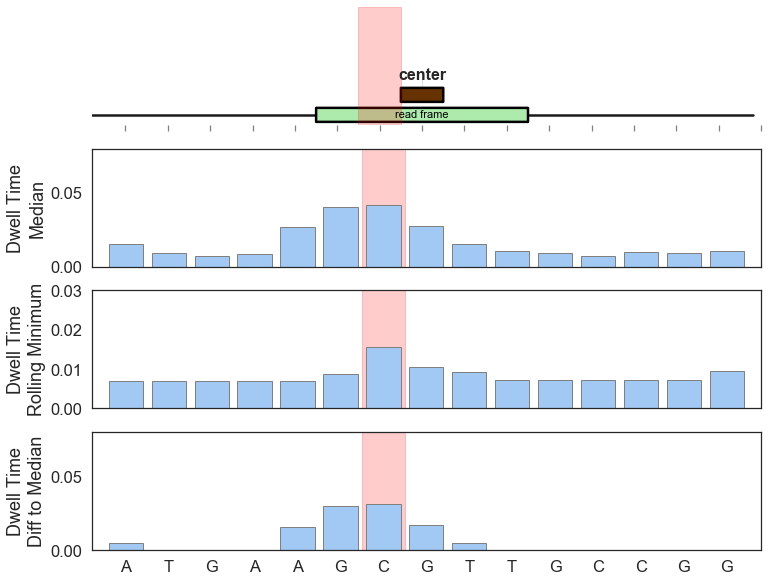

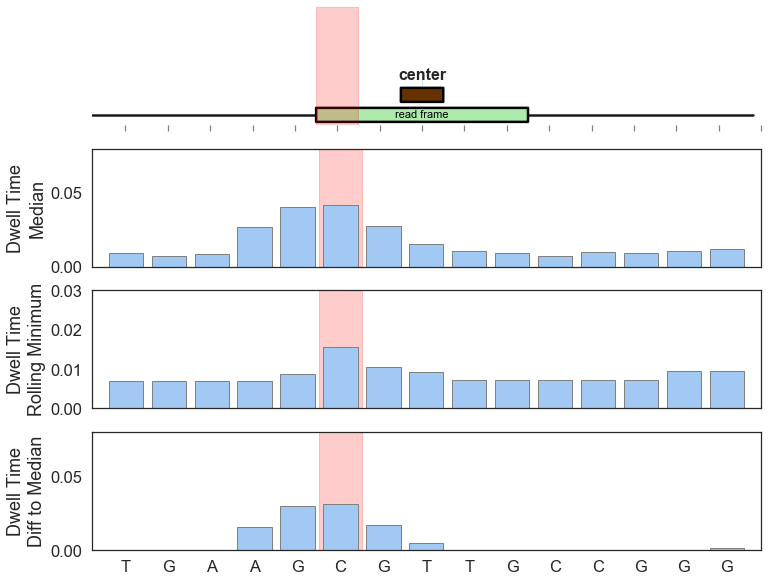

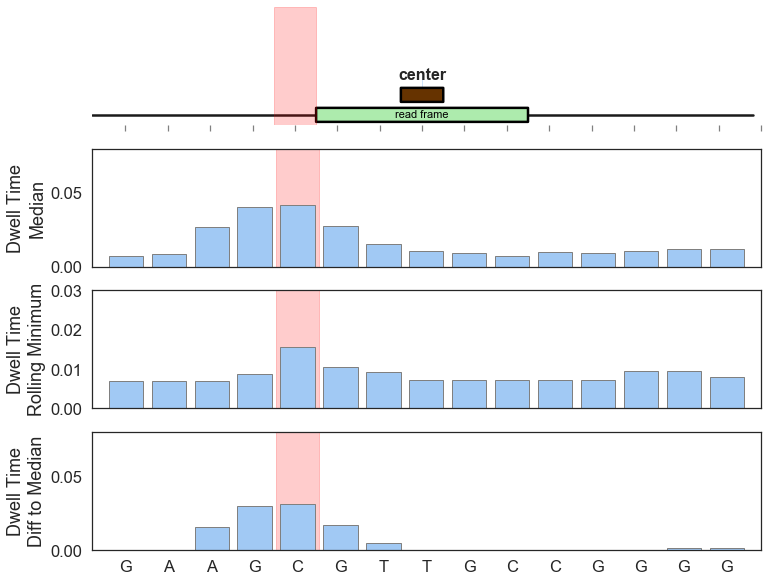

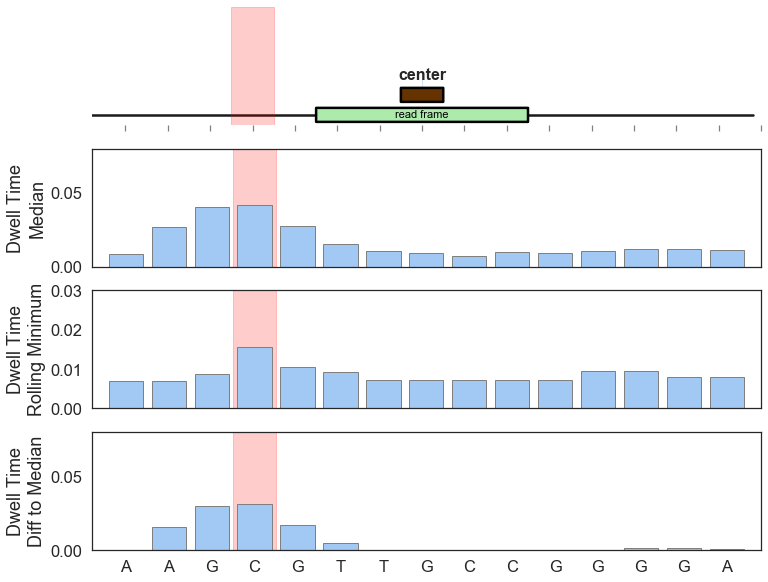

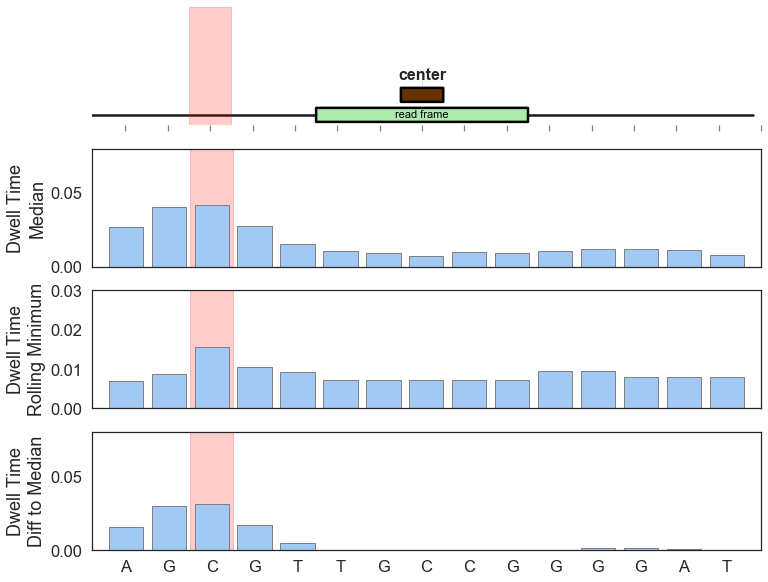

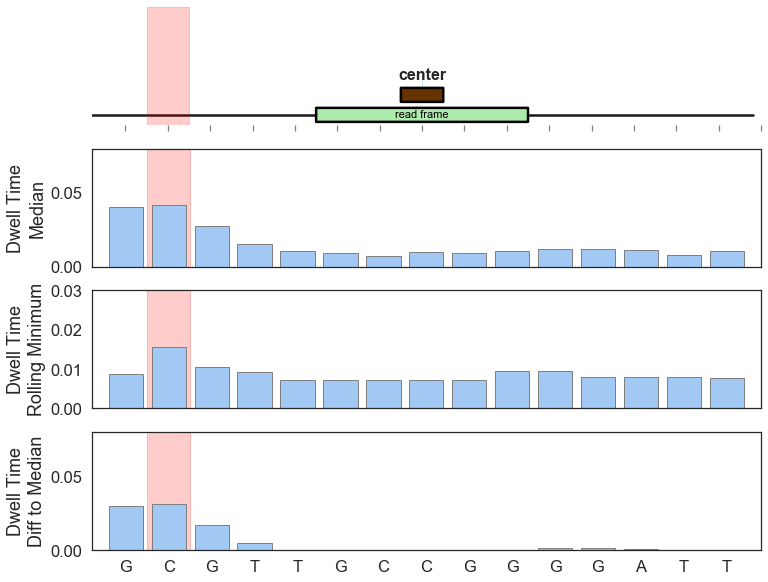

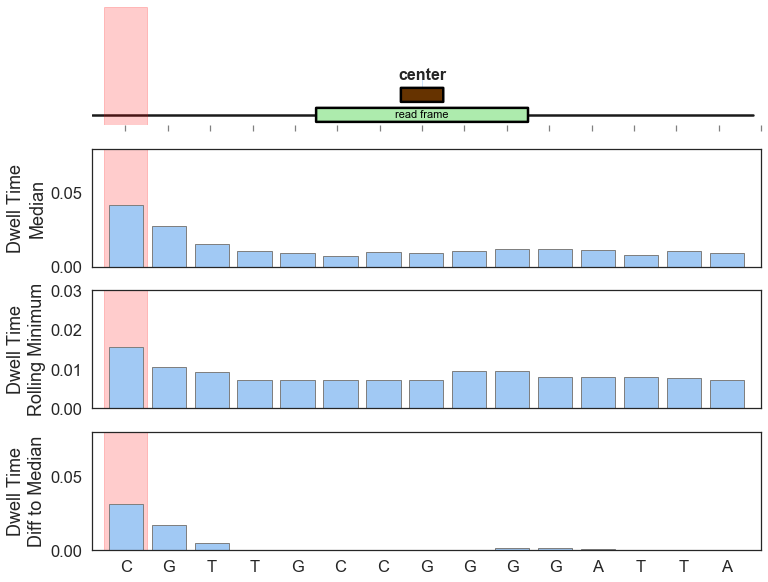

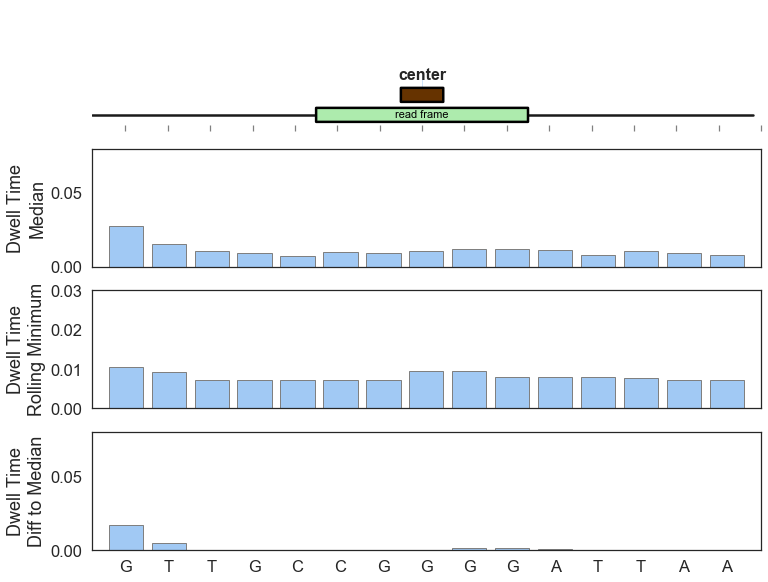

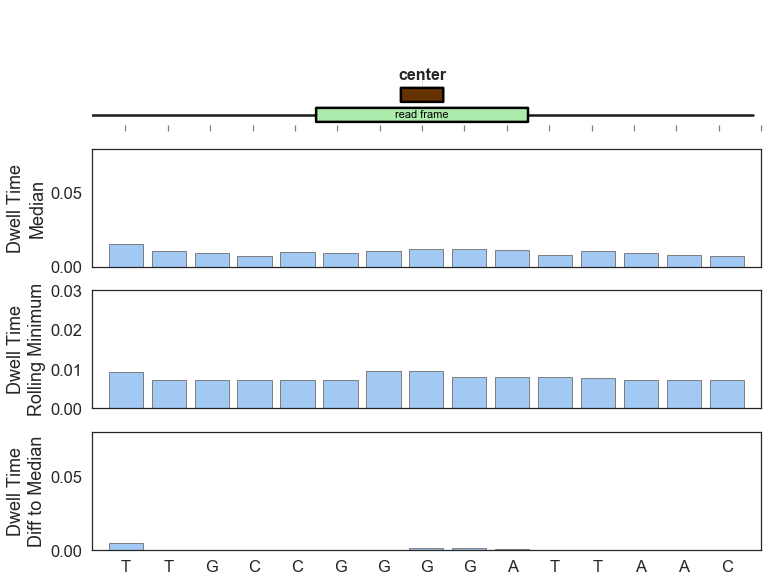

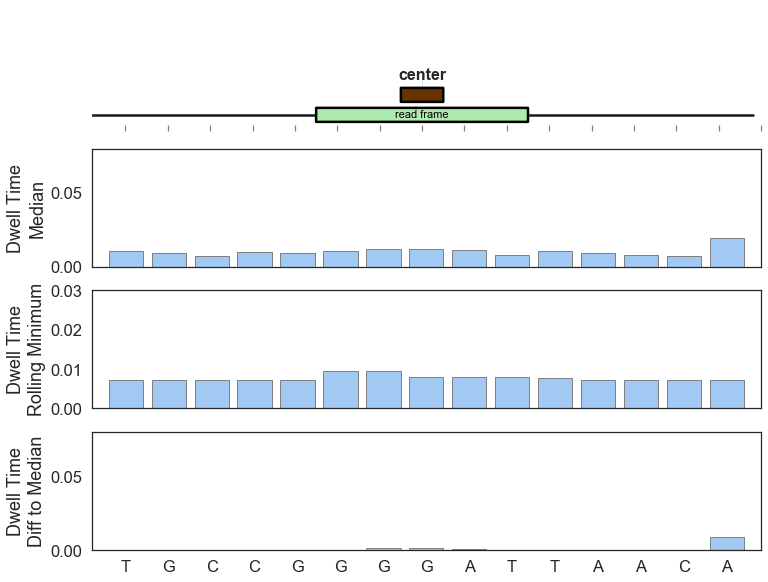

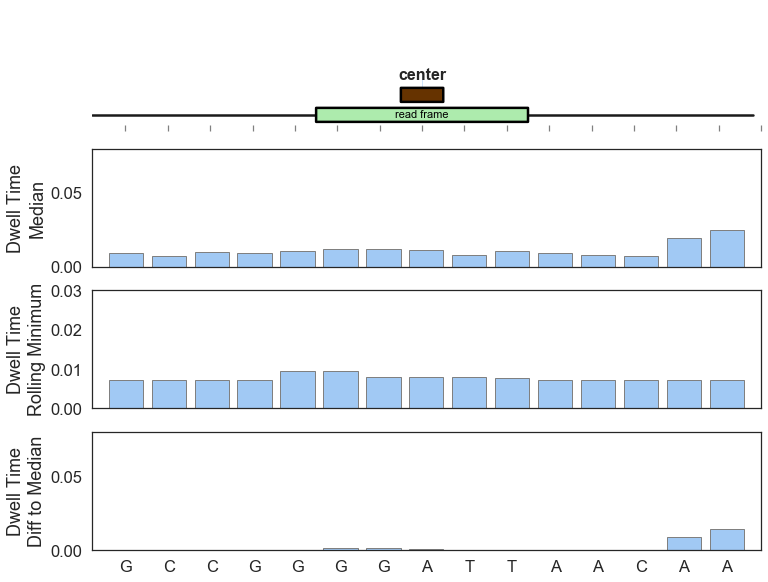

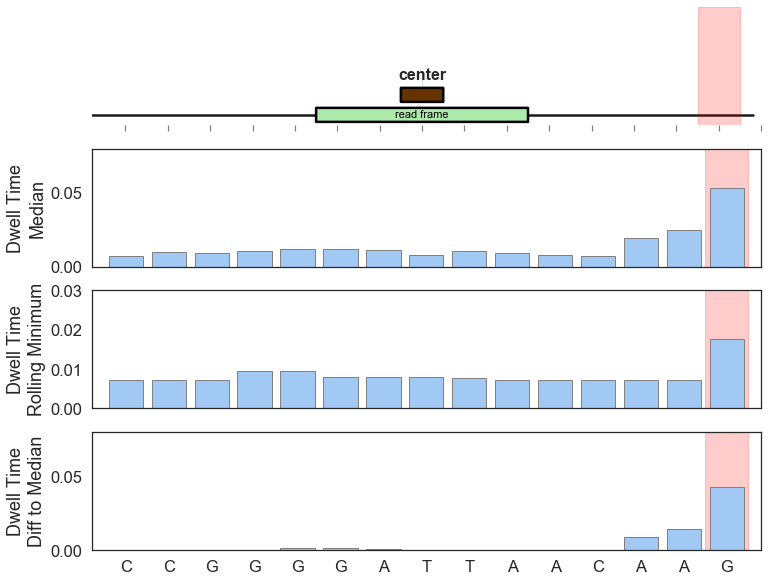

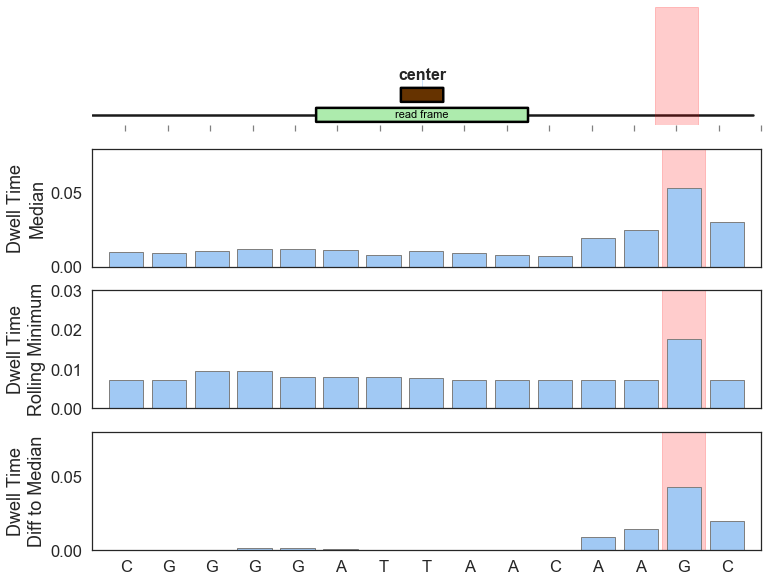

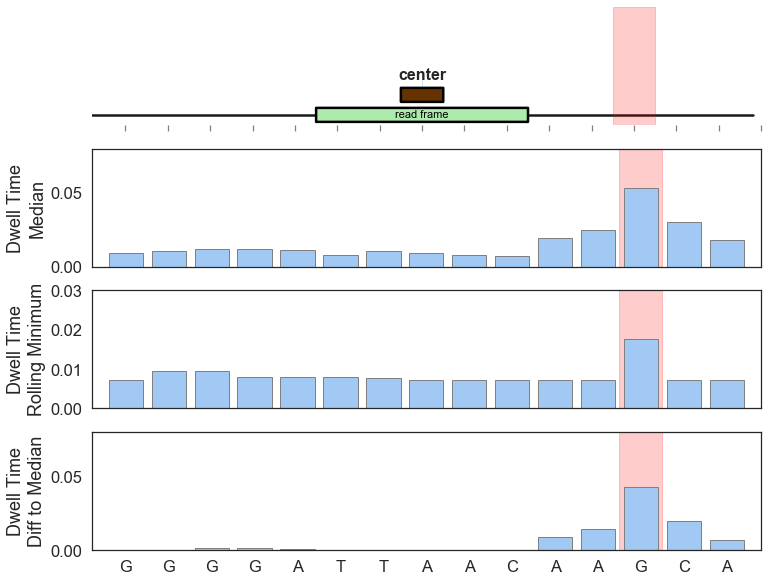

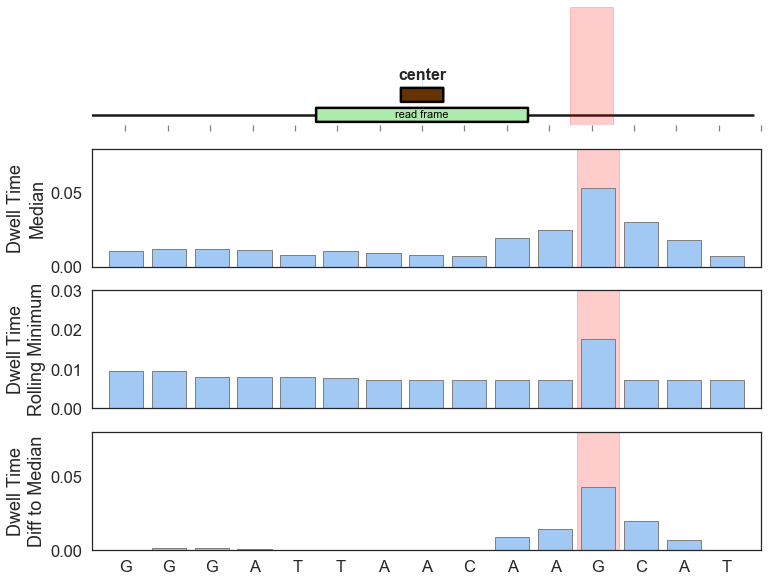

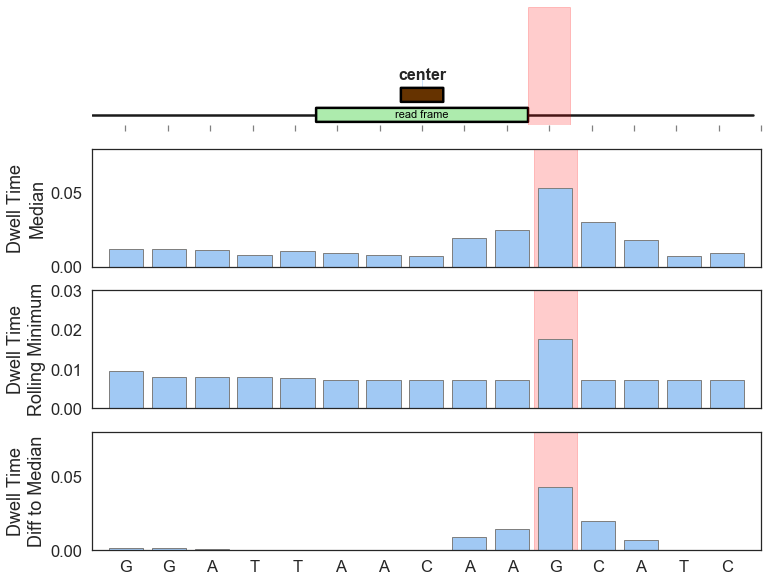

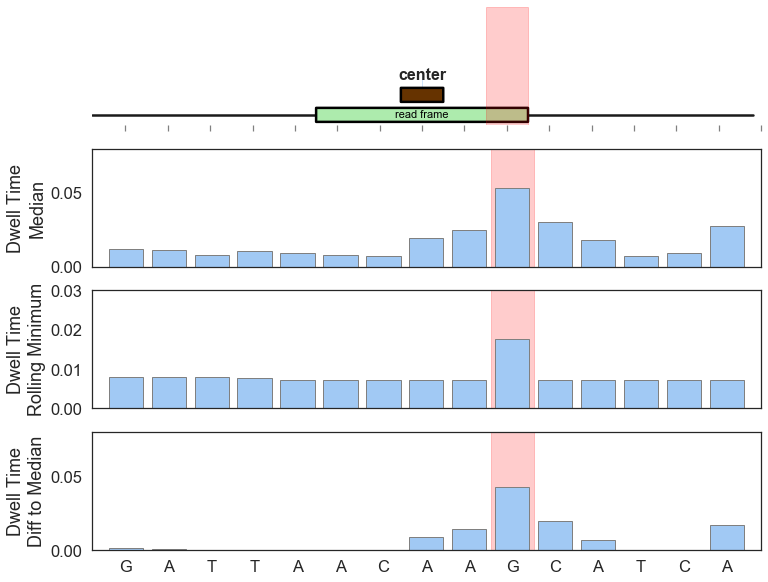

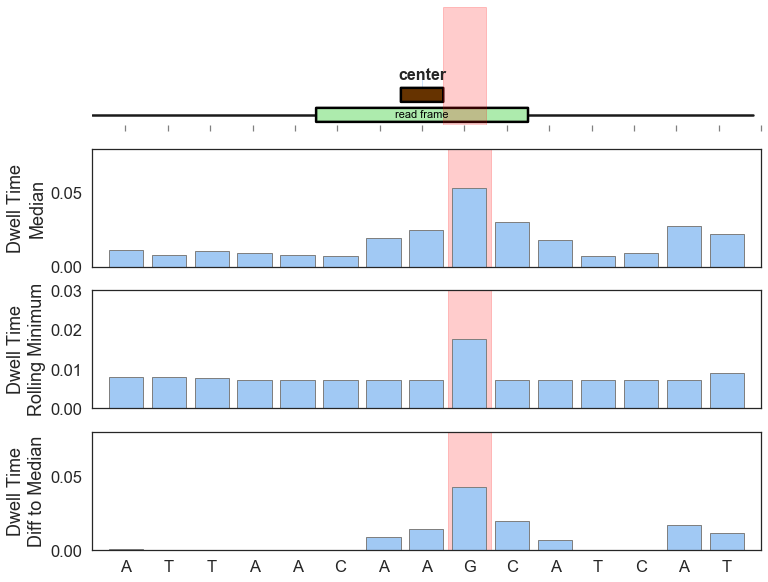

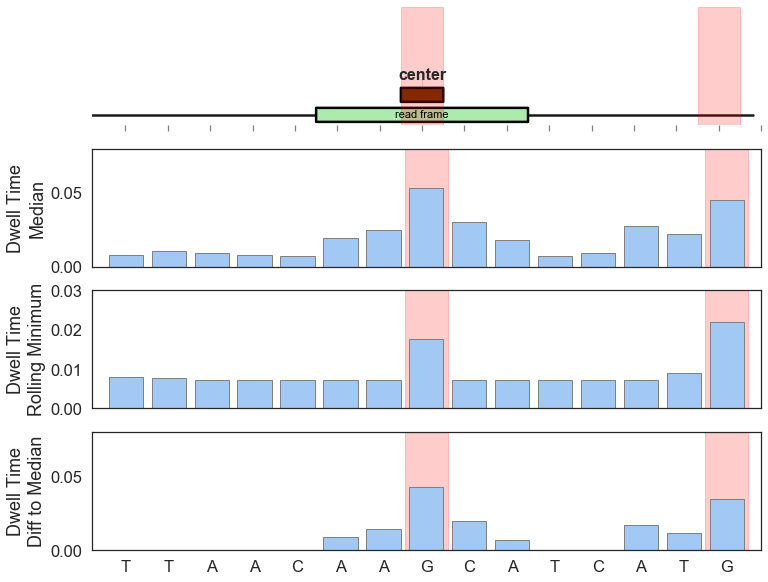

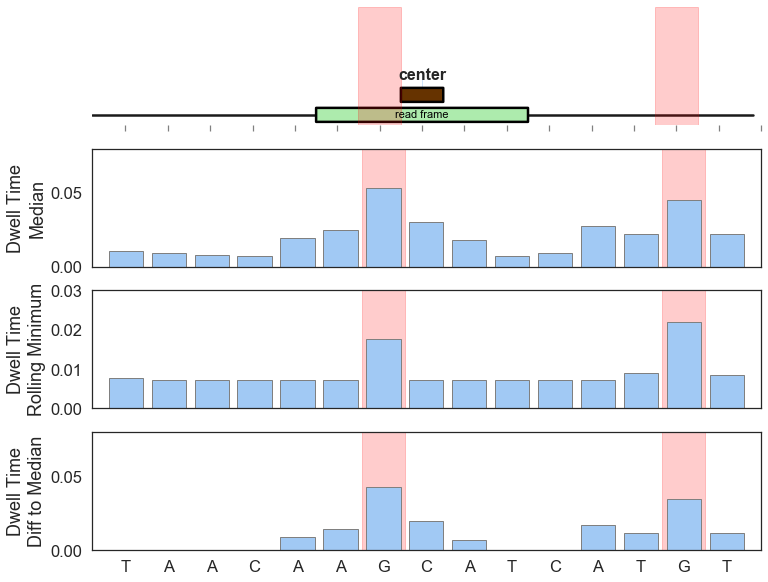

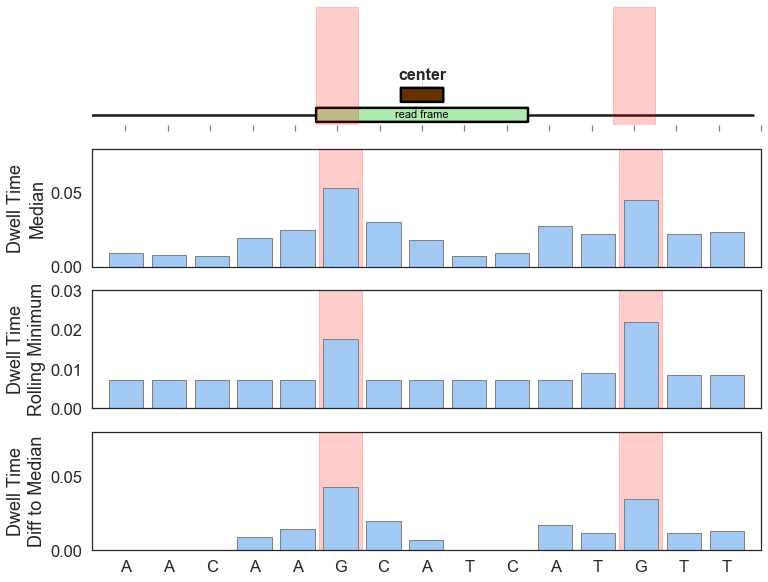

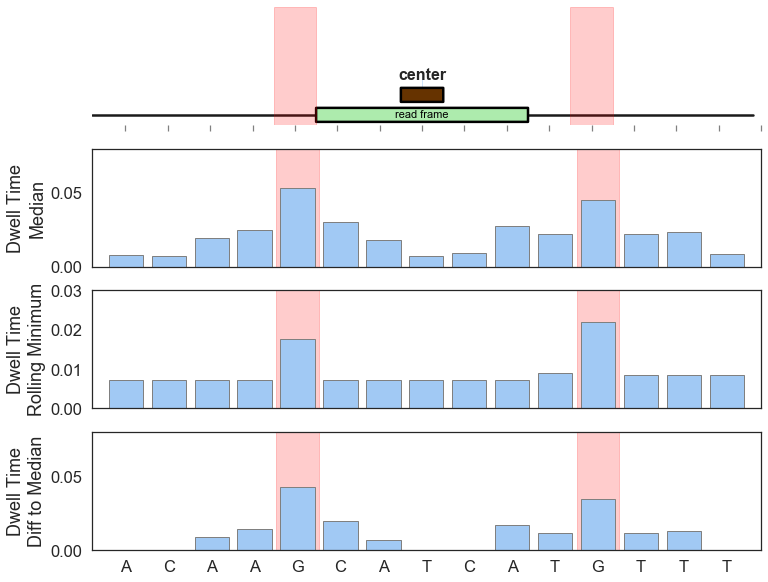

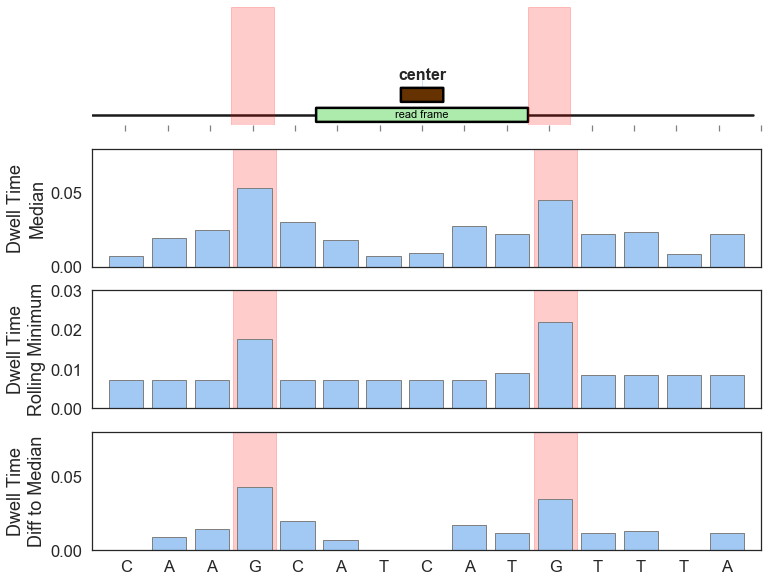

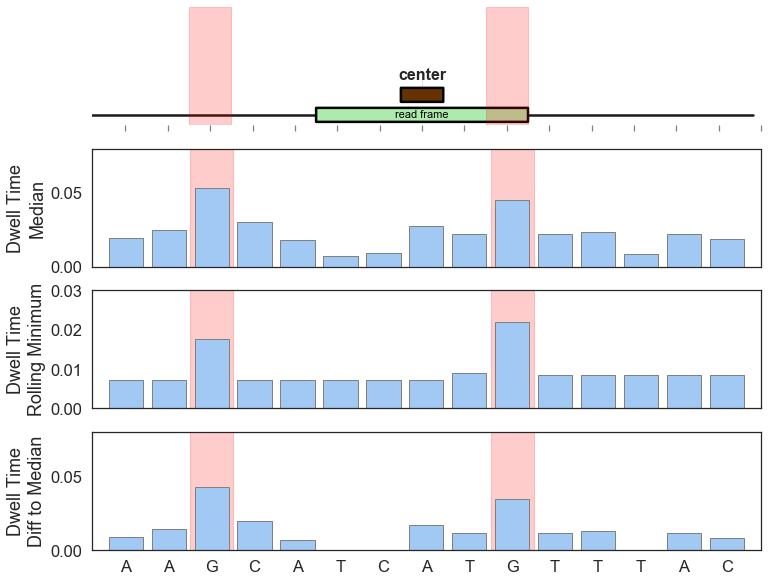

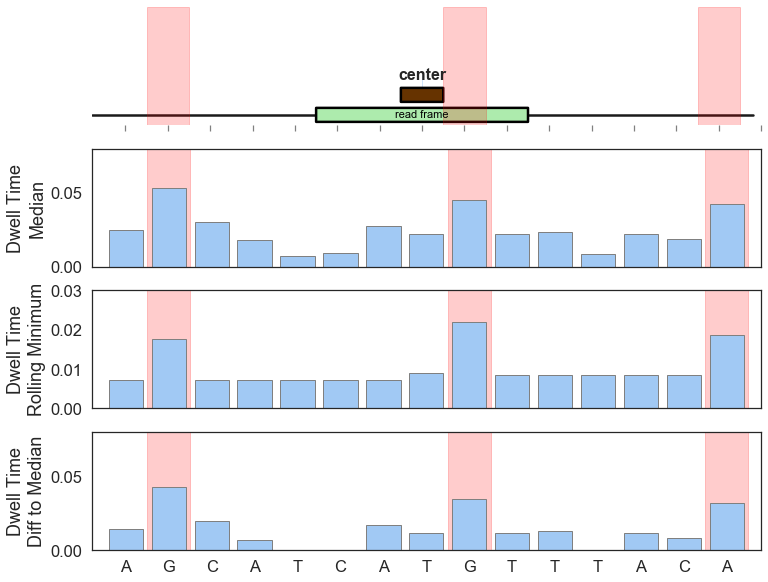

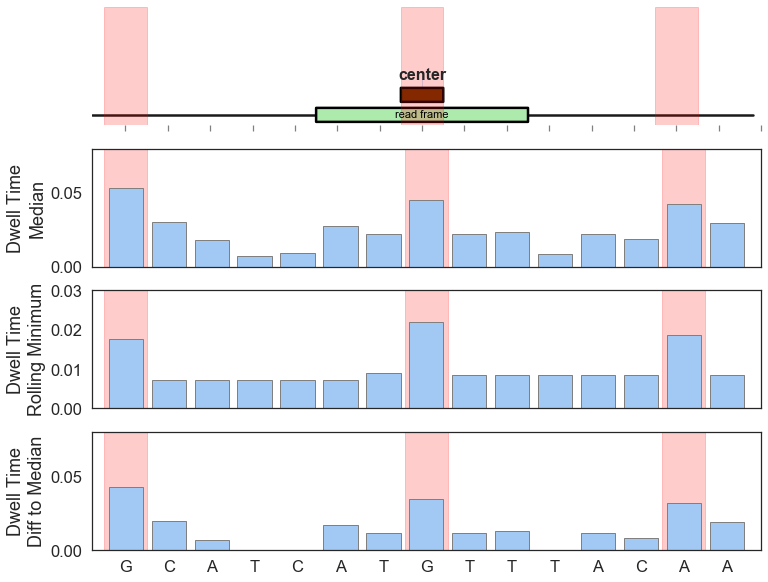

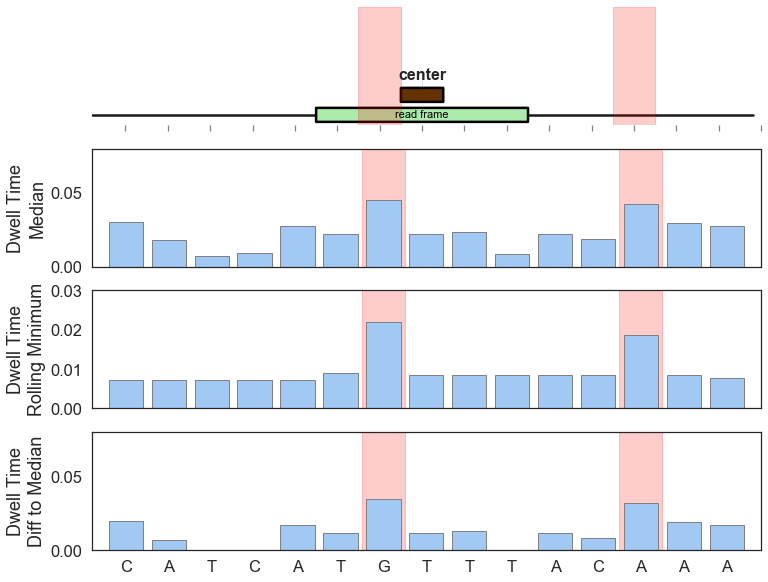

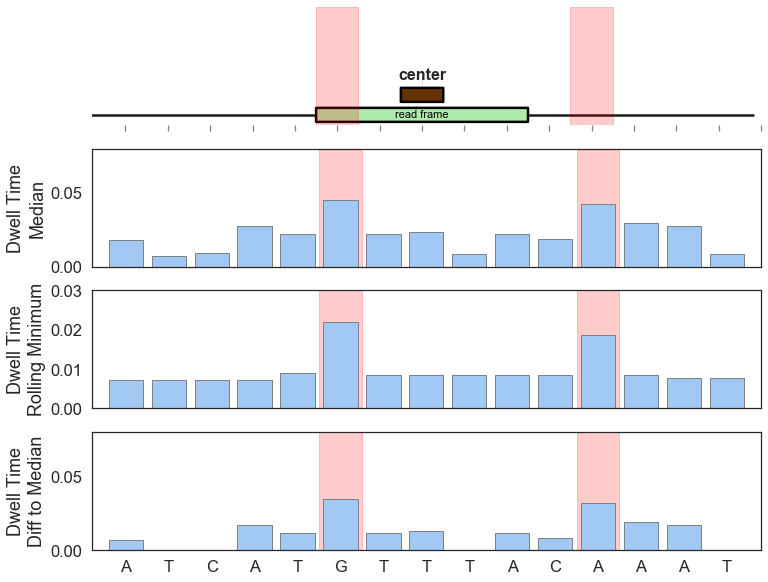

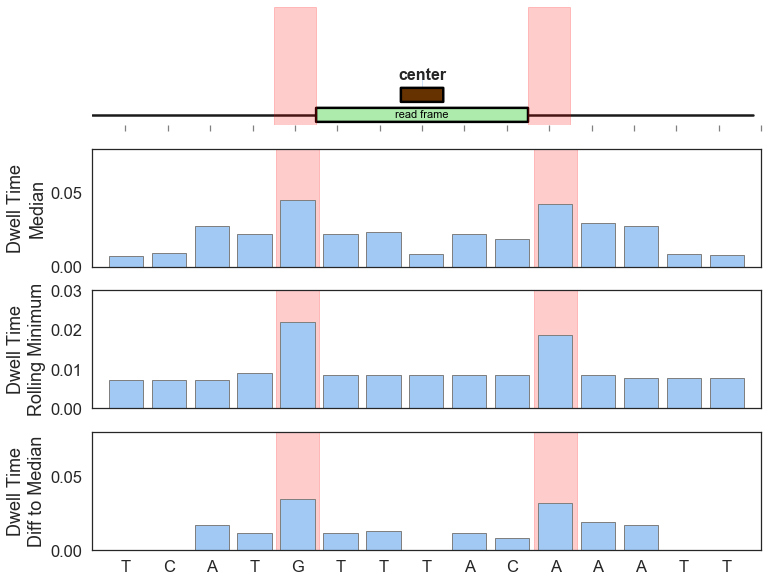

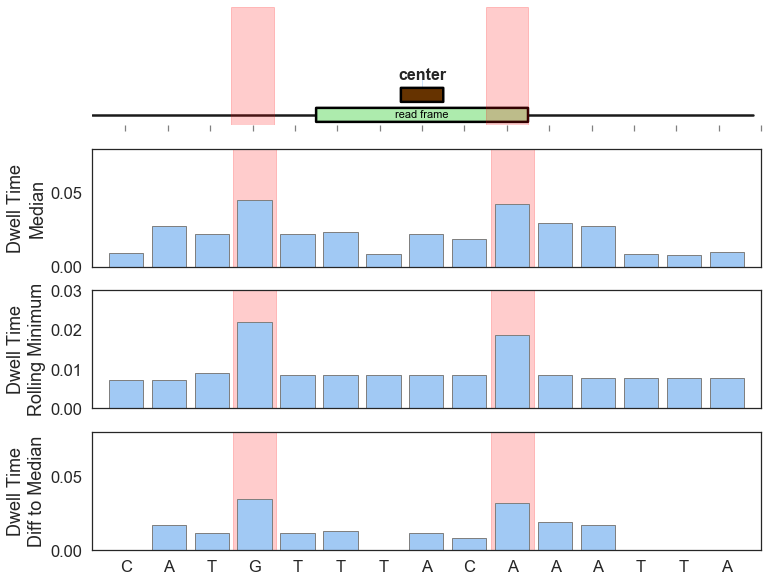

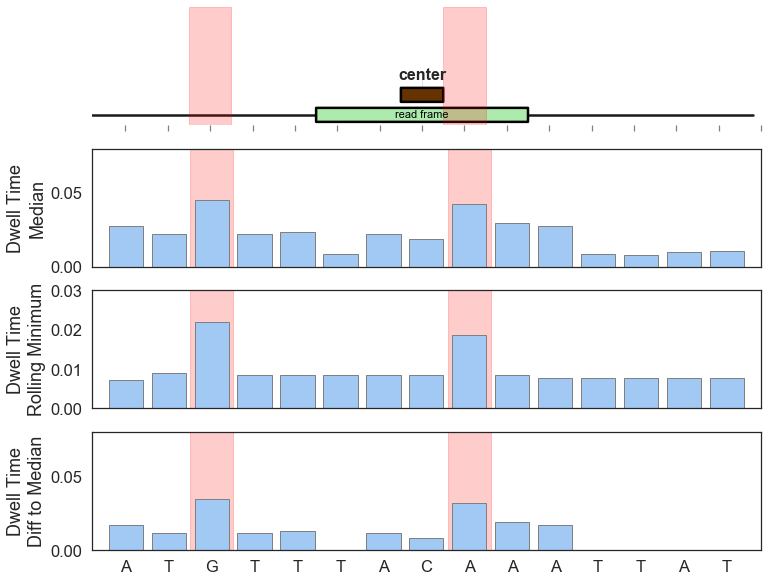

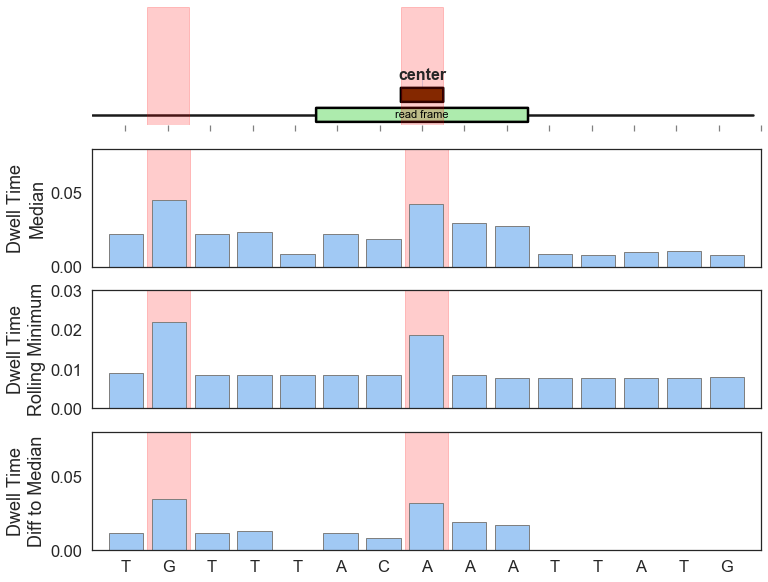

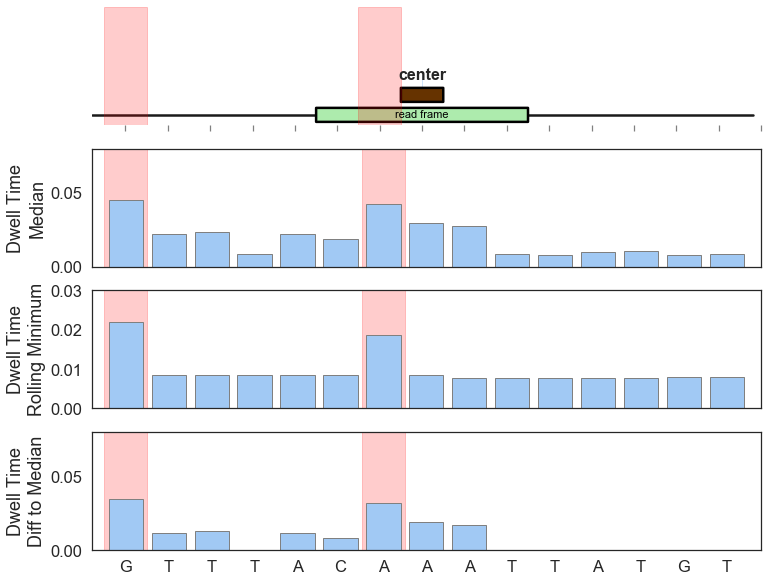

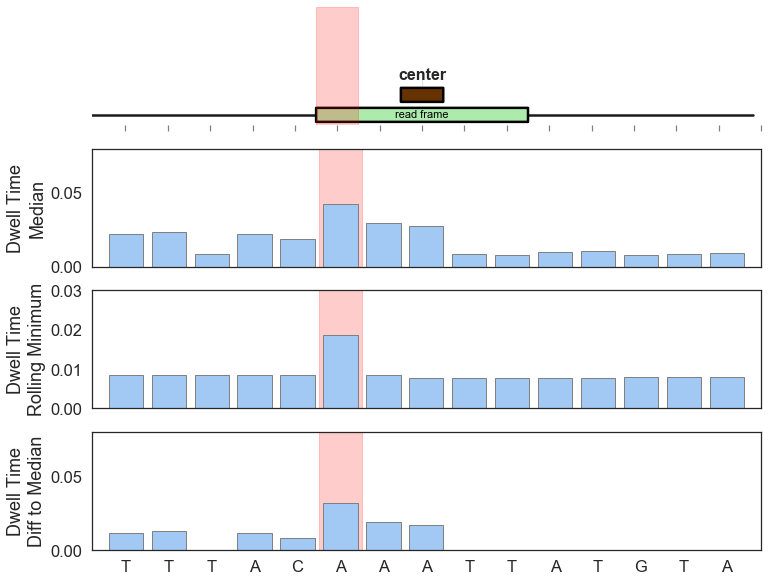

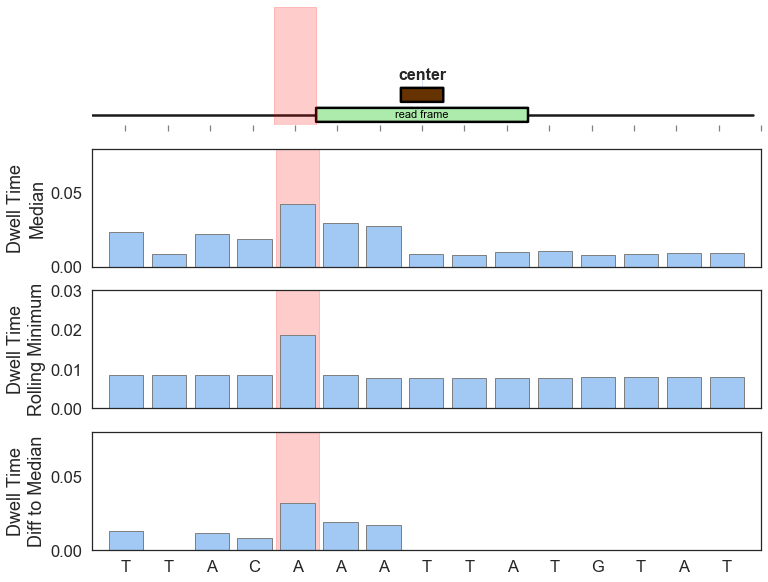

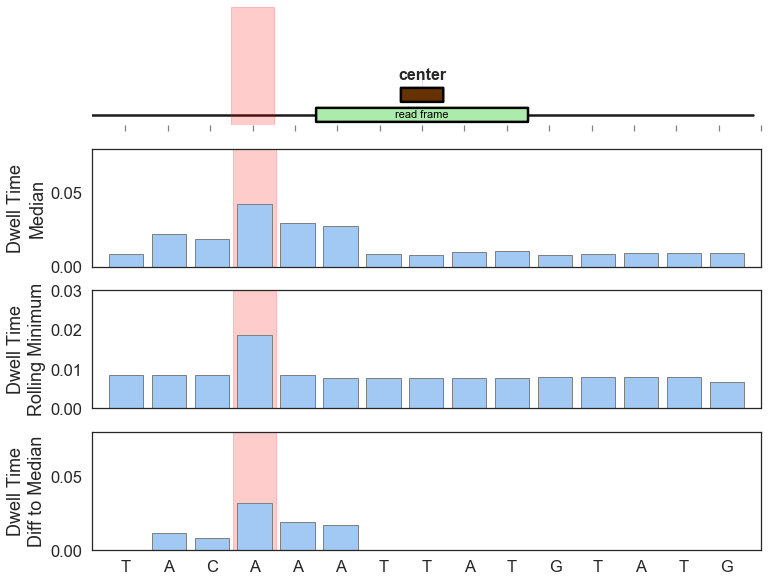

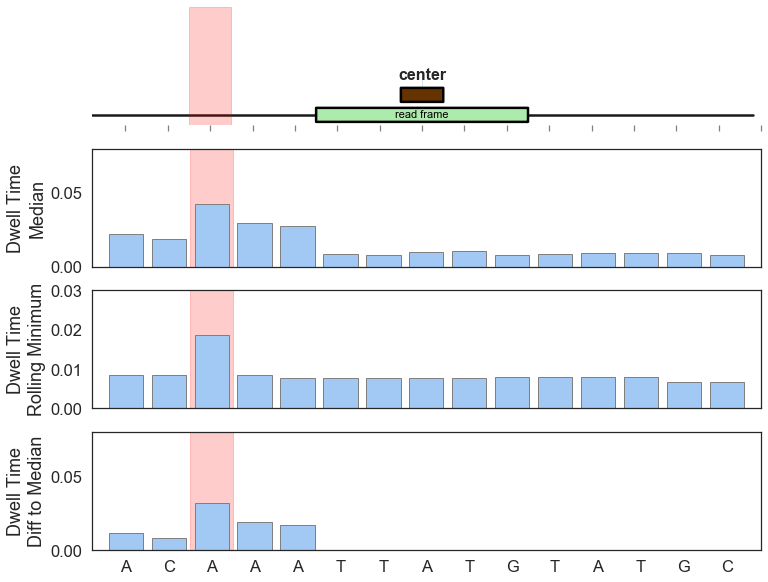

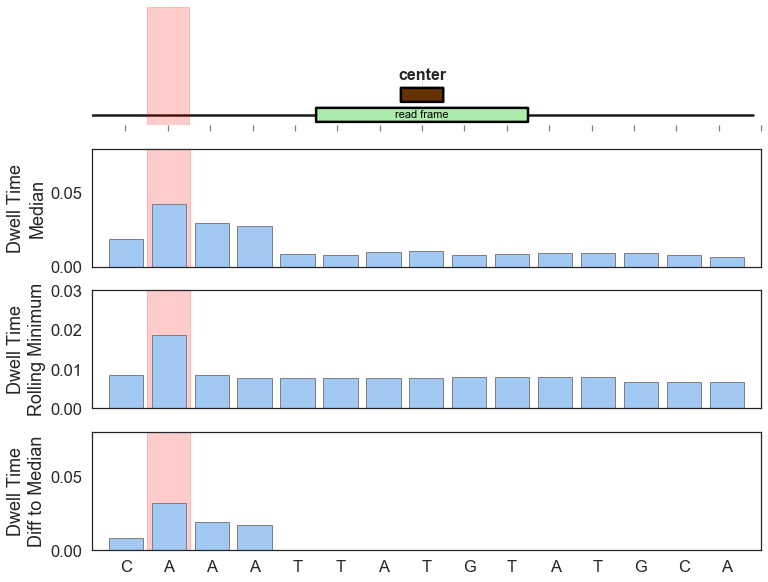

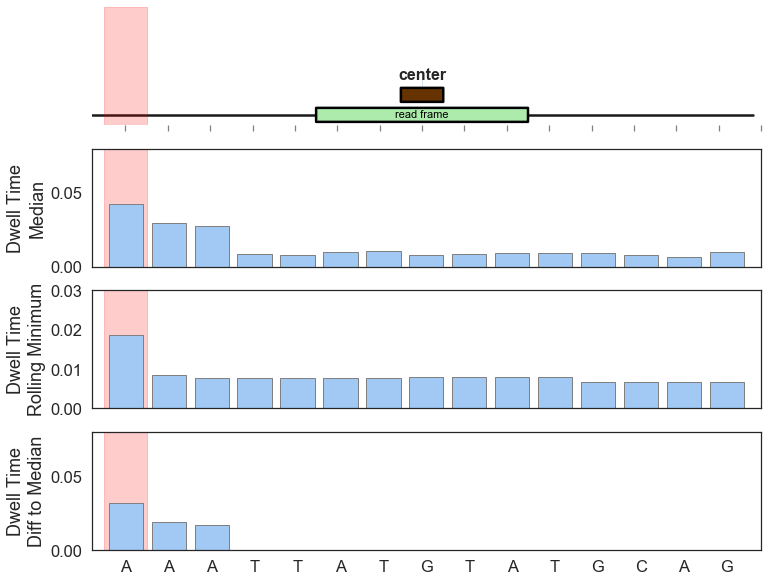

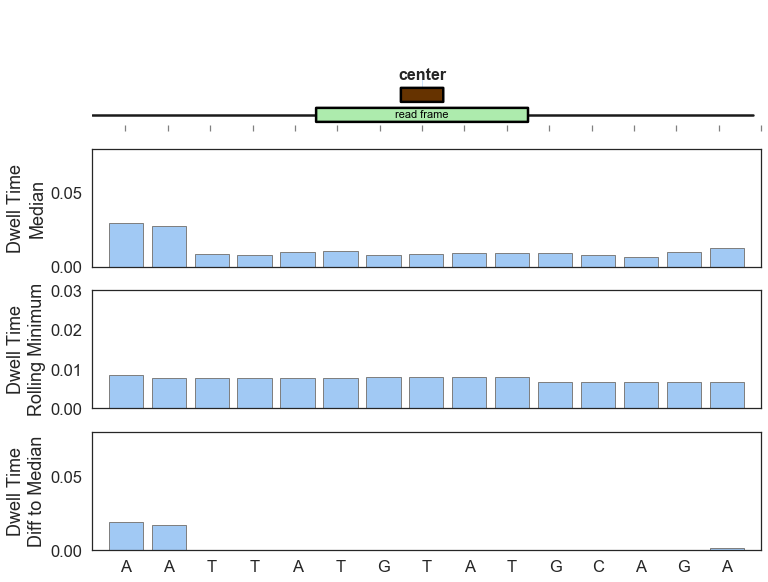

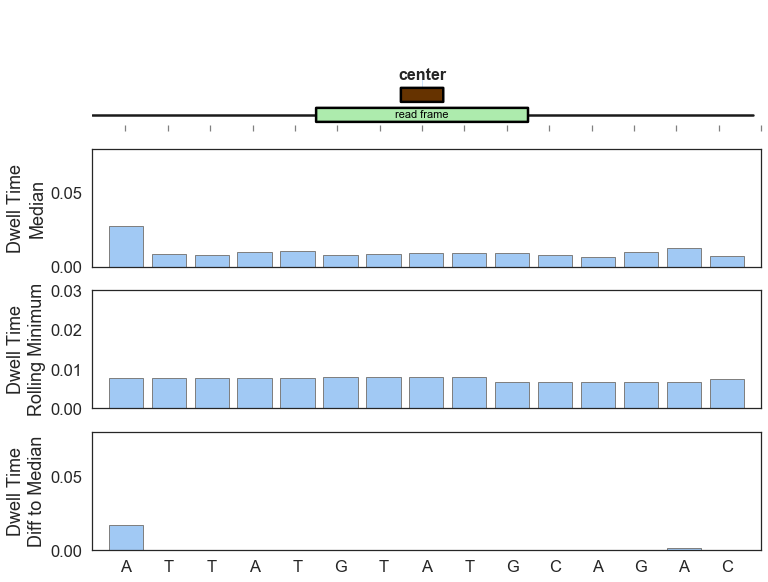

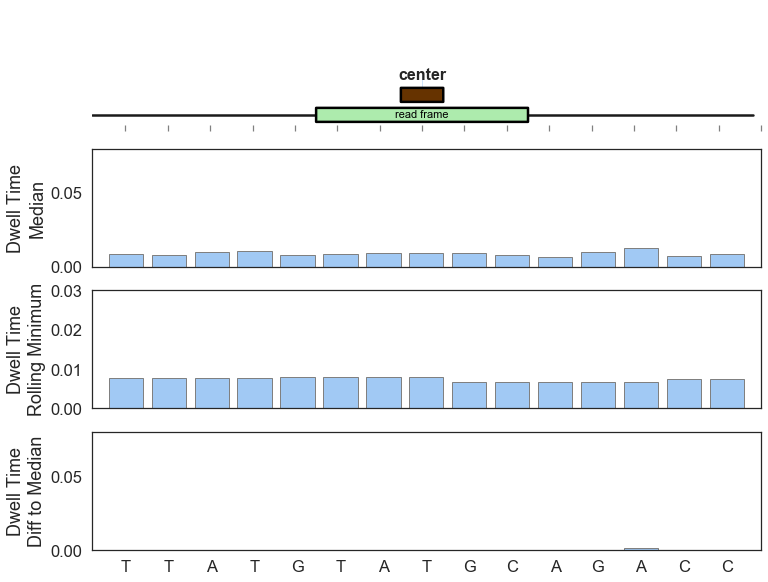

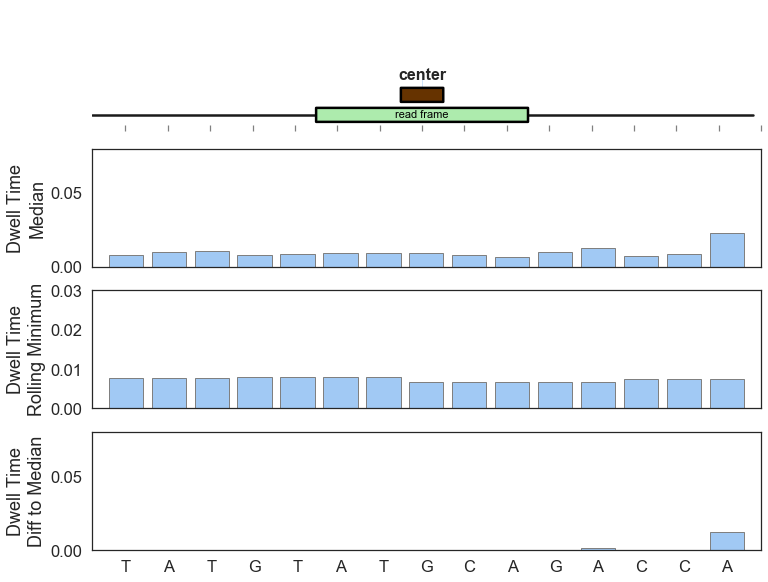

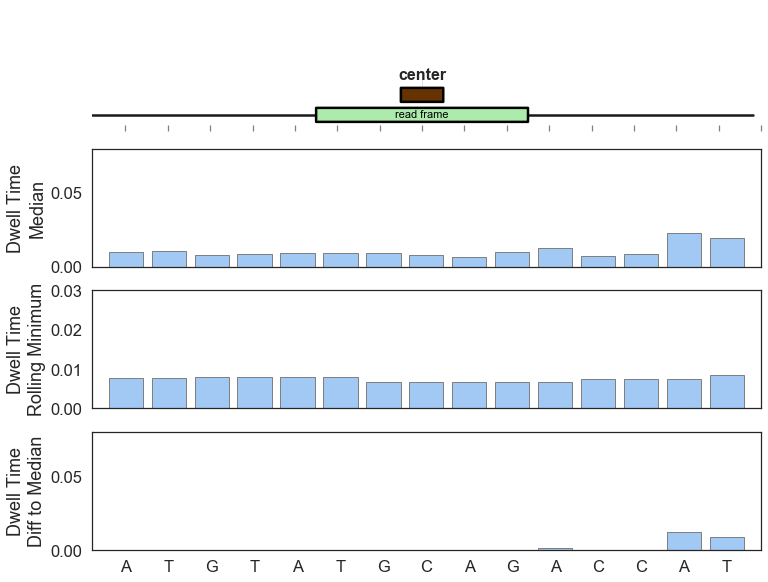

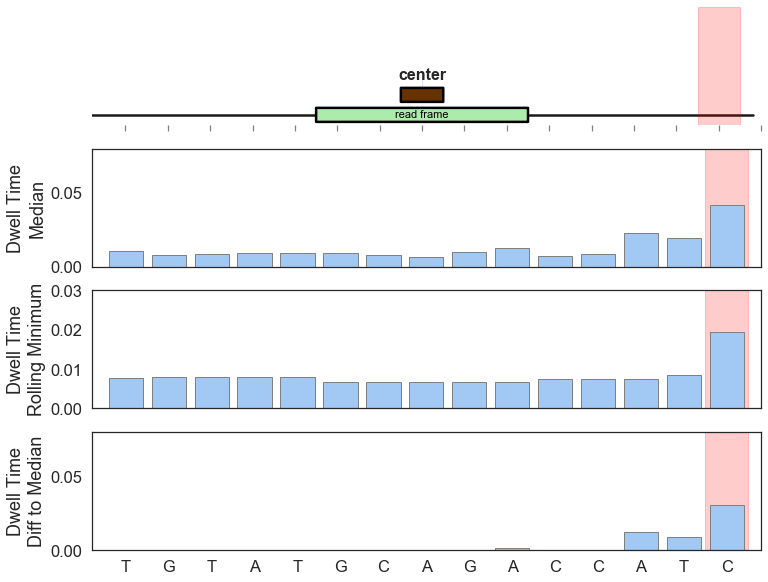

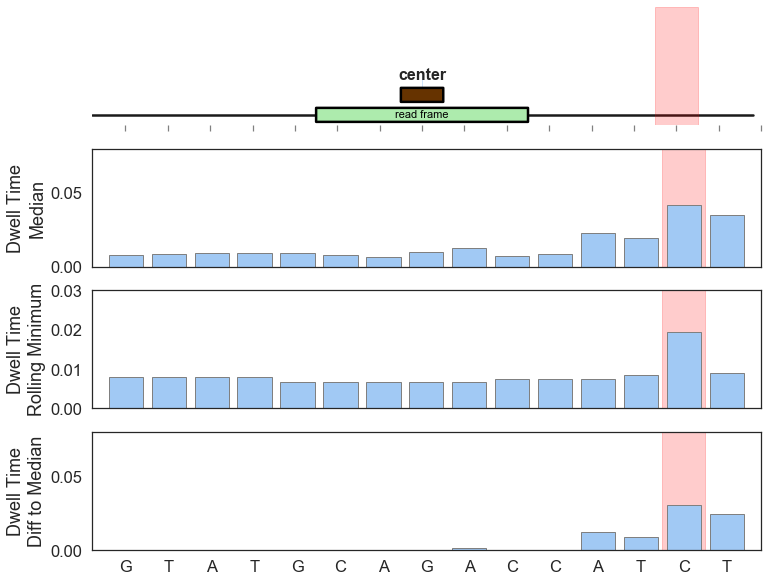

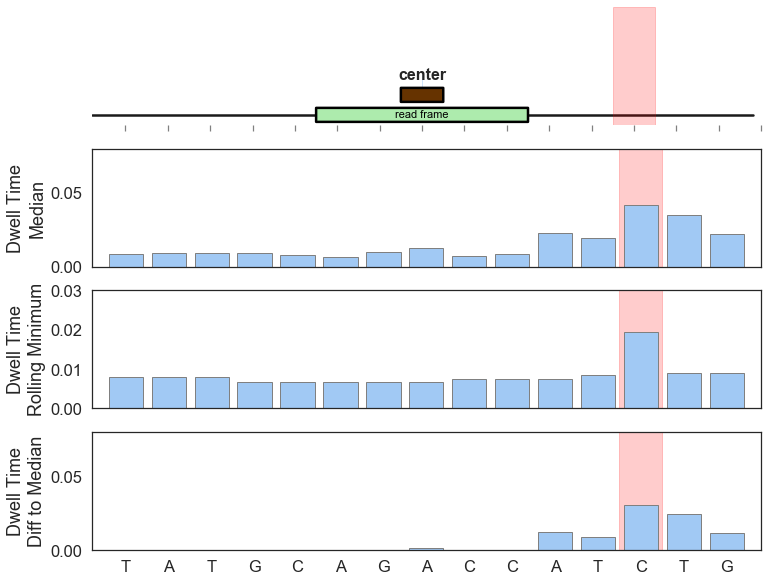

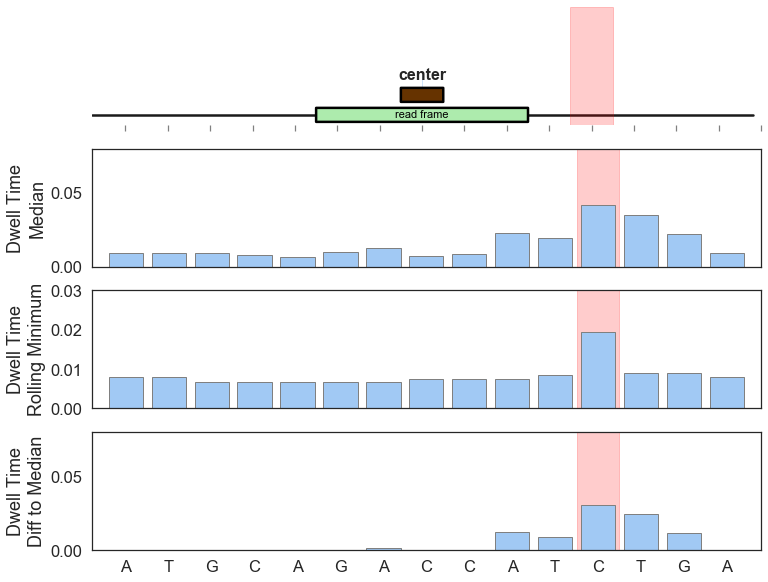

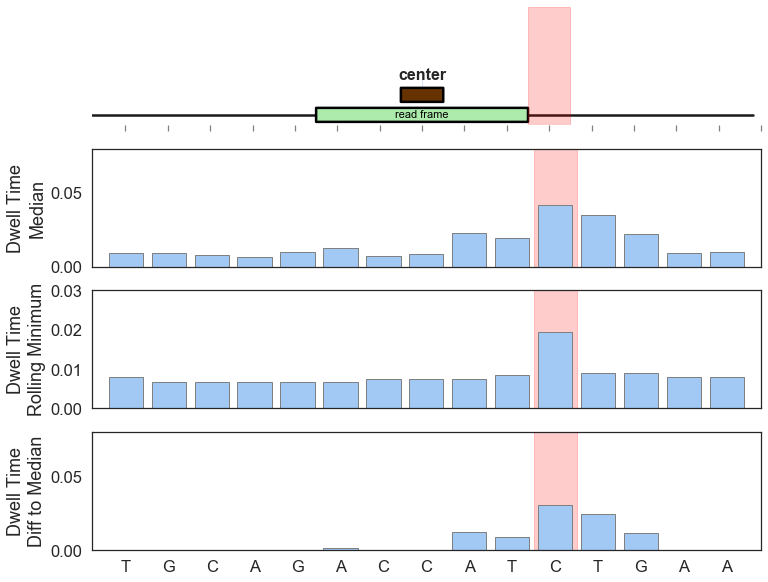

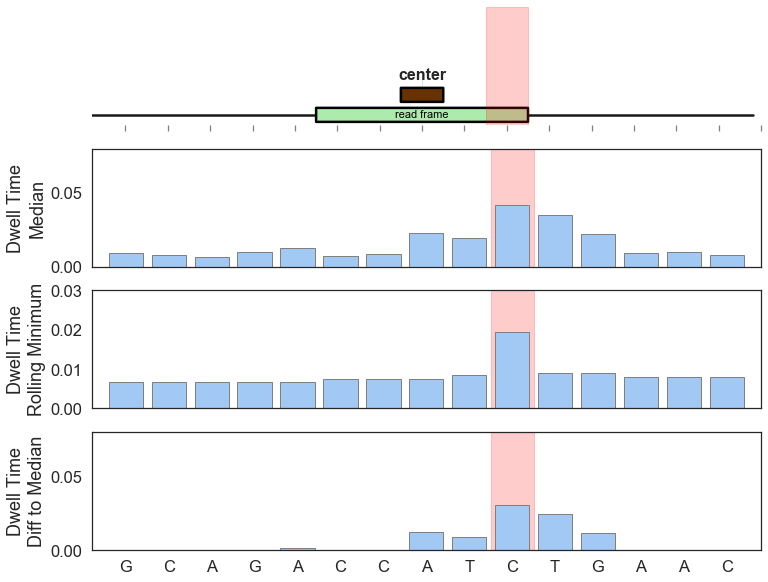

In [487]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('gif/sequencing_plot.gif', [sequencing_plot(i) for i in range(181)], fps=2, subrectangles=True)

In [396]:
imageio.mimsave

<function imageio.core.functions.mimwrite(uri, ims, format=None, **kwargs)>